## Objectives of the practical work

The objective is to get hands on experience on the fundamental elements of neural networks:
 
 - perceptron architecture (linear regression)
 - loss function
 - empirical loss
 - gradient descent

For this we will implement from scratch the data-structure and algorithms to train a perceptron. Note that slides related to the perceptron and neural networks in general are available on [moodle](https://moodle.insa-toulouse.fr/course/view.php?id=1822#section-2).

## Dataset

The objective of the regression is the prediction of the hydrodynamic performance of sailing yachts from dimensions and velocity.
The **inputs** are linked to dimension and hydrodynamics characteristics:
1. Longitudinal position of the center of buoyancy
(*flottabilité*), adimensional.
2. Prismatic coefficient, adimensional.
3. Length-displacement ratio, adimensional.
4. Beam -draught ratio ((*tiran d’eau*), adimensional.
5. Length-beam ratio, adimensional.
6. Froude number, adimensional

**Target value/predicted value (Output)** = Residuary resistance per unit weight of
displacement, adimensional

In [1]:
# Import some useful libraries and functions

import numpy as np
import pandas
import matplotlib.pyplot as plt 

def print_stats(dataset):
    """Print statistics of a dataset"""
    print(pandas.DataFrame(dataset).describe())


In [2]:
# Download the data set and place in the current folder (works on linux only)
filename = 'yacht_hydrodynamics.data'

import os.path
import requests

if not os.path.exists(filename):
    print("Downloading dataset...")
    r = requests.get('https://arbimo.github.io/tp-supervised-learning/tp2/' + filename)
    open(filename , 'wb').write(r.content)
    
print('Dataset available')

Dataset available


### Explore the dataset

- how many examples are there in the dataset?
- how many features for each example?
- what is the ground truth of the 10th example

In [3]:
# loads the dataset and slip between inputs (X) and ground truth (Y)
dataset = np.genfromtxt("yacht_hydrodynamics.data", delimiter='')
X = dataset[:, :-1] # examples features
Y = dataset[:, -1]  # ground truth

# Print the first 5 examples
for i in range(0,5):
    print(f"f({X[i]}) = {Y[i]}")

f([-5.    0.6   4.78  4.24  3.15  0.35]) = 8.62
f([-5.     0.565  4.77   3.99   3.15   0.15 ]) = 0.18
f([-2.3    0.565  4.78   5.35   2.76   0.15 ]) = 0.29
f([-5.     0.6    4.78   4.24   3.15   0.325]) = 6.2
f([0.    0.53  4.78  3.75  3.15  0.175]) = 0.59


In [4]:
#Nombre d'exemples présents dans le dataset
print("taille dataset:", len(X))

taille dataset: 308


In [4]:
#Pour chaque exemple, nombre de features sélectionnées
#On les retrouve ici:
# 1. Longitudinal position of the center of buoyancy (flottabilité), adimensional.
# 2. Prismatic coefficient, adimensional.
# 3. Length-displacement ratio, adimensional.
# 4. Beam -draught ratio ((tiran d’eau), adimensional.
# 5. Length-beam ratio, adimensional.
# 6. Froude number, adimensional
print("nombre de features:", len(X[0]))

nombre de features: 6


In [6]:
# Ground truth est un terme utilisé en statistique et en apprentissage automatique qui signifie que l'on vérifie l'exactitude des résultats de l'apprentissage automatique par rapport au monde réel.
# Voici celui du 10ème exemple
print(f"f({X[9]}) = {Y[9]}")

f([-5.     0.565  4.77   3.99   3.15   0.25 ]) = 1.83


The following command adds a column to the inputs.

- what is in the value added this column?
- why are we doing this?

In [5]:
X = np.insert(X, 0, np.ones((len(X))), axis= 1)
print_stats(X)


           0           1           2           3           4           5  \
count  308.0  308.000000  308.000000  308.000000  308.000000  308.000000   
mean     1.0   -2.381818    0.564136    4.788636    3.936818    3.206818   
std      0.0    1.513219    0.023290    0.253057    0.548193    0.247998   
min      1.0   -5.000000    0.530000    4.340000    2.810000    2.730000   
25%      1.0   -2.400000    0.546000    4.770000    3.750000    3.150000   
50%      1.0   -2.300000    0.565000    4.780000    3.955000    3.150000   
75%      1.0   -2.300000    0.574000    5.100000    4.170000    3.510000   
max      1.0    0.000000    0.600000    5.140000    5.350000    3.640000   

                6  
count  308.000000  
mean     0.287500  
std      0.100942  
min      0.125000  
25%      0.200000  
50%      0.287500  
75%      0.375000  
max      0.450000  


In [11]:
#On a rajouté des 1 pour avoir une référence de base concernant performance hydrodynalique
print(X[0]) #On a rajouté une colonne avec que des 1 tout devant, c'est une référence de base à ce que l'on essaie
print(X[1]) #de prédire

[ 1.   -5.    0.6   4.78  4.24  3.15  0.35]
[ 1.    -5.     0.565  4.77   3.99   3.15   0.15 ]


## Creating the perceptron

![Perceptron for regression](https://arbimo.github.io/tp-supervised-learning/tp2/perceptron-regression.png)

We now want to define a perceptron, that is, a function of the form: 

$h_w(x) = w_0 + w_1 \times x_1 + \dots + w_n \times x_n$

- Complete the code snippet below to:
  - create the vector of weight `w`
  - implement the `h` function that evaluate an example based on the vector of weights
  - check if this works on a few examples

In [12]:
#Nombre de poids
N = 7
w = np.zeros(N) # définition du vecteur poids W avec tous les poids à 0

# Définition de la fonction d'approximation de Y grâce aux entrées X, à notre référence de base X0 et à notre 
def h(w, x): # vecteur poids
    return np.dot(w,x)

In [15]:
# print the ground truth and the evaluation of h_w on the first example
h(w,X[0])

0.0

## Loss function

Complete the definiton of the loss function below such that, for a **single** example `x` with ground truth `y`, it returns the $L_2$ loss of $h_w$ on `x`.

In [17]:
# Nous allons implémenter plusieurs loss, la L1, L2 et la loss 0/1
# pour à la fin pouvoir voir l'impact du choix de la loss sur la descente de gradient
#Définition de la loss 2 L2
def loss_2(w, x, y):
    y_predic = h(w,x)
    
    # Test en cas d'explosion du Y_predict
    if y_predic > 10e6:
        print("Y predict", y_predic)
    return (y-y_predic)**2

In [19]:
loss_2(w,X[0],Y[0])

74.30439999999999

In [20]:
#Définition de la loss 1 L1
def loss_1(w, x, y):
    y_predic = h(w,x)
    
    # Test en cas d'explosion du Y_predict
    if y_predic > 10e6:
        print("Y predict", y_predic)
    return abs(y-y_predic)

In [21]:
loss_1(w,X[0],Y[0])

8.62

In [24]:
#Définition de la loss 1 L1
def loss_01(w, x, y):
    y_predic = h(w,x)
        # Test en cas d'explosion du Y_predict
    if y_predic > 10e6:
        print("Y predict", y_predic)
    
    if y_predic==y:
        return 0
    else:
        return 1

In [25]:
loss_01(w,X[0],Y[0])

1

## Empirical loss

Complete the function below to compute the empirical loss of $h_w$ on a **set** of examples $X$ with associated ground truths $Y$.

In [27]:
# Ne connaissant pas la probabilité de redistribution parmis les exemples,
#  nous n'utiliserons pas la loss generalisée mais plutôt la loss empirique
# Définition de la loss empirique
def emp_loss(w, X, Y, loss):
    emp_l = 0
    for i in range(0,len(X)):
        emp_l = emp_l + loss(w, X[i], Y[i])
    return emp_l/len(X)

In [28]:
# Valeur de la loss empirique en utilisant nos ensemble X et Y avec la loss 2
emp_loss(w,X,Y, loss_2)

339.2467464285712

In [32]:
# Valeur de la loss empirique en utilisant nos ensemble X et Y avec la loss 1
emp_loss(w,X,Y, loss_1)

10.495357142857156

In [31]:
# Valeur de la loss empirique en utilisant nos ensemble X et Y avec la loss 0/1
emp_loss(w,X,Y, loss_01)

1.0

## Gradient update

A gradient update is of the form: $w \gets w + dw$

- Complete the function below so that it computes the $dw$ term (the 'update') based on a set of examples `(X, Y)` the step (`alpha`)

If you are not sure about the gradient computation, check out the [perceptron slides](https://moodle.insa-toulouse.fr/pluginfile.php/120391/mod_resource/content/1/cm1.pdf) on [Moodle](https://moodle.insa-toulouse.fr/course/view.php?id=1822) (in particular, slide 26). Make sure this computation is clear to you!

In [33]:
#Mise à jour du vecteur de poids avec le pas alpha
def compute_update(w, X, Y, alpha):
    
    for j in range(0, len(X)):
        for i in range(0,len(w)):
            w[i] = w[i] + alpha * (Y[j]-h(w,X[j]))*X[j,i]
        
    return w
                   

compute_update(w, X, Y, alpha = 10e-7)

array([ 0.00320675, -0.00750108,  0.0018059 ,  0.01535208,  0.01259179,
        0.0102817 ,  0.00130237])

## Gradient descent

Now implement the gradient descent algorithm that will:

- repeatedly apply an update the weights 
- stops when a max number of iterations is reached (do not consider early stopping for now)
- returns the final vector of weights

In [134]:
def descent(w_init, X, Y, loss, alpha, max_iter):
    
    w = np.copy(w_init)
    w_prec = np.zeros(N)
    iterateur = []
    i = 0
    iterateur.append(i)
    
    Loss = []
    Loss.append(emp_loss(w, X, Y,loss))
    
    # On pourrait rajouter un critère de convergence lorsque le vecteur poids ne change quasi plus ou la norme
    # np.linalg.norm(w_prec-w)>= (degrès de précision) OU emp_loss(w, X, Y)>= degrés de précision
    while i < max_iter:
        w_prec = np.copy(w)
        w=compute_update(w, X, Y, alpha)
        Loss.append(emp_loss(w, X, Y,loss))
        i=i+1
        iterateur.append(i)
        
    #On retourne le nombre d'itérations nécéssaires, un tableau contenant les différents passages dans la boucles
    # en vue d'un affichage, la valeur de la Loss ainsi que le vecteur poids
    return i, iterateur, Loss, w

## Exploitation

You gradient descent is now complete and you can exploit it to train your perceptron.

- Train your perceptron to get a model.
- Visualize the evolution of the loss on the training set. Has it converged?
- Try training for several choices of `alpha` and `max_iter`. What seem like a reasonable choice?
- What is the loss associated with the final model?
- Is the final model the optimal one for a perceptron?


In [135]:
# TODO
W = np.zeros(N) # On initialise le vecteur poids qu'avec des 0

#Loss 2 utilisée
nb_ite_1, suivi_it_1, Loss_1, w_1 = descent(W, X, Y, loss_2, 10e-7, 10000)
nb_ite_2, suivi_it_2, Loss_2, w_2 = descent(W, X, Y, loss_2, 10e-7, 30000)
nb_ite_3, suivi_it_3, Loss_3, w_3 = descent(W, X, Y, loss_2, 10e-5, 10000)
nb_ite_4, suivi_it_4, Loss_4, w_4 = descent(W, X, Y, loss_2, 10e-5, 30000)
nb_ite_11, suivi_it_11, Loss_11, w_11 = descent(W, X, Y, loss_2, 10e-3, 10000)
nb_ite_22, suivi_it_22, Loss_22, w_22 = descent(W, X, Y, loss_2, 10e-3, 30000)
nb_ite_111, suivi_it_111, Loss_111, w_111 = descent(W, X, Y, loss_2, 10e-1, 10000)
nb_ite_222, suivi_it_222, Loss_222, w_222 = descent(W, X, Y, loss_2, 10e-1, 30000)

#Loss 1 utilisée
nb_ite_5, suivi_it_5, Loss_5, w_5 = descent(W, X, Y, loss_1, 10e-7, 10000)
nb_ite_6, suivi_it_6, Loss_6, w_6 = descent(W, X, Y, loss_1, 10e-7, 30000)
nb_ite_7, suivi_it_7, Loss_7, w_7 = descent(W, X, Y, loss_1, 10e-5, 10000)
nb_ite_8, suivi_it_8, Loss_8, w_8 = descent(W, X, Y, loss_1, 10e-5, 30000)
nb_ite_55, suivi_it_55, Loss_55, w_55 = descent(W, X, Y, loss_1, 10e-3, 10000)
nb_ite_66, suivi_it_66, Loss_66, w_66 = descent(W, X, Y, loss_1, 10e-3, 30000)
nb_ite_555, suivi_it_555, Loss_555, w_555 = descent(W, X, Y, loss_1, 10e-1, 10000)
nb_ite_666, suivi_it_666, Loss_666, w_666 = descent(W, X, Y, loss_1, 10e-1, 30000)

#Loss 0/1 utilisée
nb_ite_9, suivi_it_9, Loss_9, w_9 = descent(W, X, Y, loss_01, 10e-7, 10000)
nb_ite_10, suivi_it_10, Loss_10, w_10 = descent(W, X, Y, loss_01, 10e-7, 30000)
nb_ite_11, suivi_it_11, Loss_11, w_11 = descent(W, X, Y, loss_01, 10e-5, 10000)
nb_ite_12, suivi_it_12, Loss_12, w_12 = descent(W, X, Y, loss_01, 10e-5, 30000)

In [197]:
# Nous allons utiliser l'indicateur r2 pour évaluer la précision des prédictions de notre modèle
# Plus le R2 est proche de 1, plus notre modèle a été précis
from sklearn.metrics import r2_score

In [137]:
# Affichage de l'évolution de la loss en fonction des itérations
def print_Loss(suivi_it, Loss):
    plt.plot(suivi_it, Loss)
    plt.xlabel("Nombre itérations")
    plt.ylabel("Valeur de la loss")

In [138]:
# Code sample that can be used to visualize the difference between the ground truth and the prediction
def print_accurancy_model(w, number_sample):
    num_samples_to_plot = number_sample
    plt.plot(Y[0:num_samples_to_plot], 'ro', label='y')
    yw = [h(w,x) for x in X]
    plt.plot(yw[0:num_samples_to_plot], 'bx', label='$\hat{y}$')
    plt.legend()
    plt.xlabel("Examples")
    plt.ylabel("f(examples)")

In [180]:
# Fonction permettant le calcul du r2
def r2(w, number_sample):
    num_samples_to_plot = number_sample
    yw = [h(w,x) for x in X]
    return r2_score(Y[0:num_samples_to_plot],yw[0:num_samples_to_plot])

## Exemples avec la loss 2:

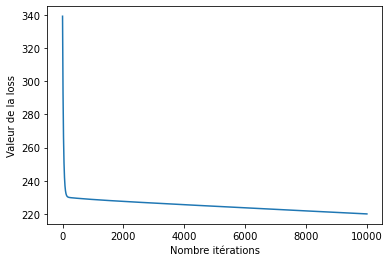

In [139]:
print_Loss(suivi_it_1, Loss_1)

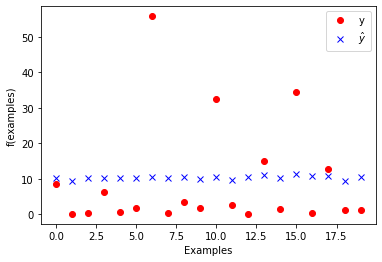

In [140]:
print_accurancy_model(w_1, 20)

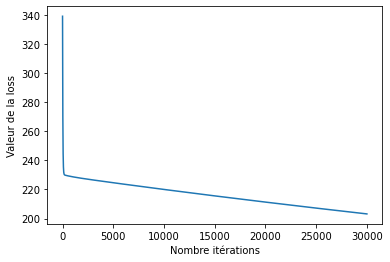

In [141]:
print_Loss(suivi_it_2, Loss_2)

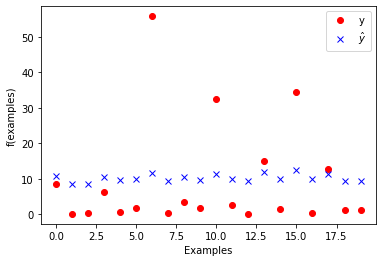

In [142]:
print_accurancy_model(w_2, 20)

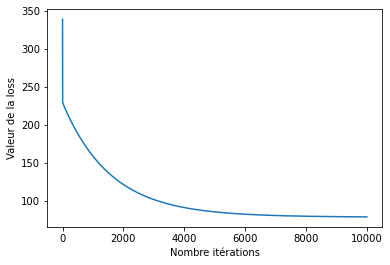

In [143]:
print_Loss(suivi_it_3, Loss_3)

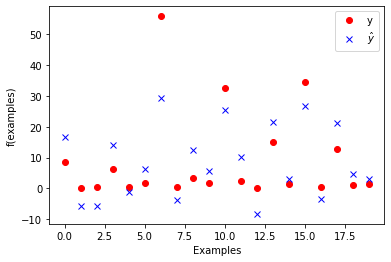

In [144]:
print_accurancy_model(w_3, 20)

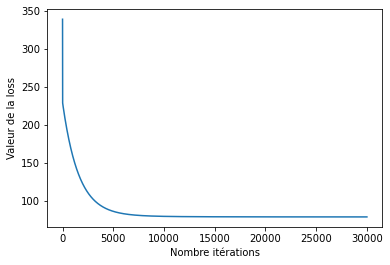

In [145]:
print_Loss(suivi_it_4, Loss_4)

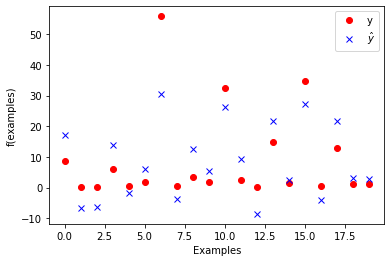

In [146]:
print_accurancy_model(w_4, 20)

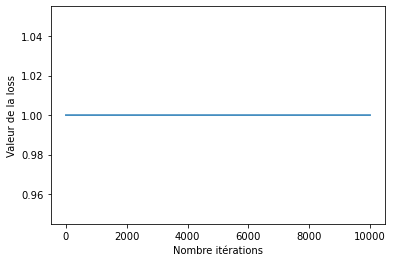

In [147]:
print_Loss(suivi_it_11, Loss_11)

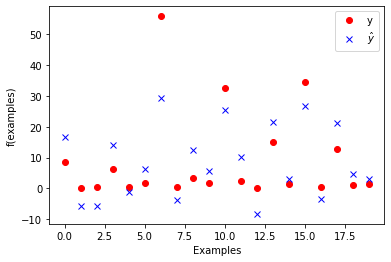

In [148]:
print_accurancy_model(w_11, 20)

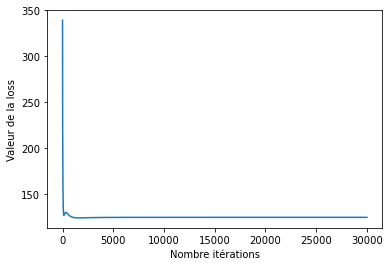

In [149]:
print_Loss(suivi_it_22, Loss_22)

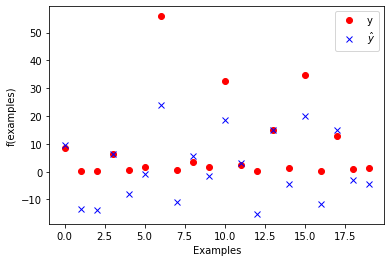

In [150]:
print_accurancy_model(w_22, 20)

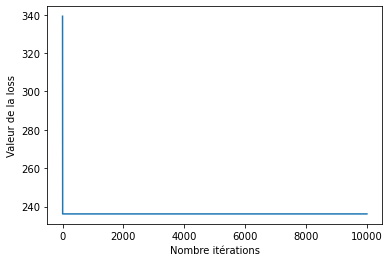

In [151]:
print_Loss(suivi_it_111, Loss_111)

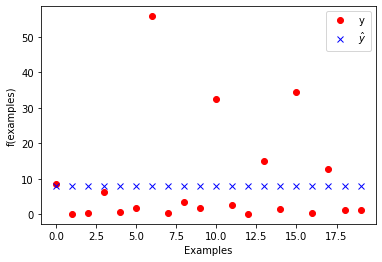

In [152]:
print_accurancy_model(w_111, 20)

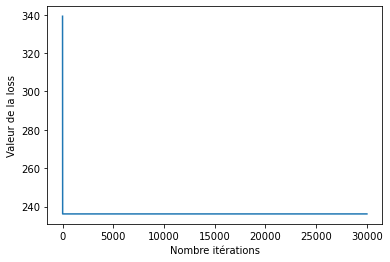

In [153]:
print_Loss(suivi_it_222, Loss_222)

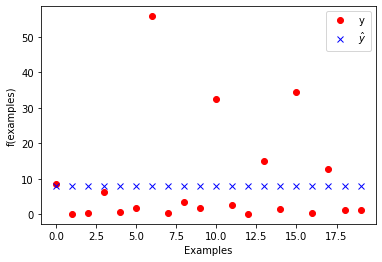

In [154]:
print_accurancy_model(w_222, 20)

In [204]:
print("w1 R2:", r2(w_1,100))
print("w2 R2:", r2(w_2,100))
print("w3 R2:", r2(w_3,100))
print("w4 R2:", r2(w_4,100))
print("w11 R2:", r2(w_11,100))
print("w22 R2:", r2(w_22,100))
print("w111 R2:", r2(w_111,100))
print("w222 R2:", r2(w_222,100))

# Nous avons qu'en utilisant w3, w4, w11 les modèles les plus précis

w1 R2: 0.008778762418283792
w2 R2: 0.08561182202566953
w3 R2: 0.6538120988949359
w4 R2: 0.6556073044248025
w11 R2: 0.6538120988949359
w22 R2: 0.4514779398431268
w111 R2: -0.001379412883961706
w222 R2: -0.0013794914185594198


## Exemples Loss 1 :

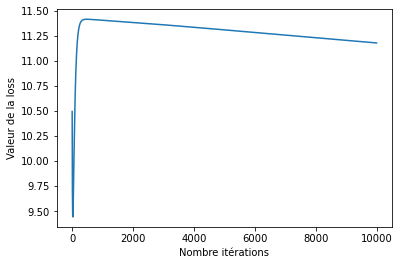

In [155]:
print_Loss(suivi_it_5, Loss_5)

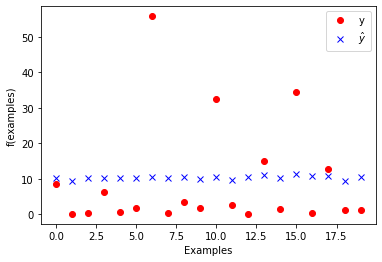

In [156]:
print_accurancy_model(w_5, 20)

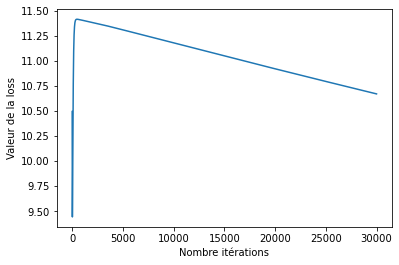

In [157]:
print_Loss(suivi_it_6, Loss_6)

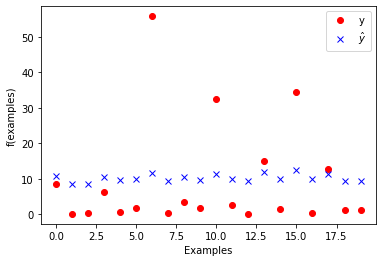

In [158]:
print_accurancy_model(w_6, 20)

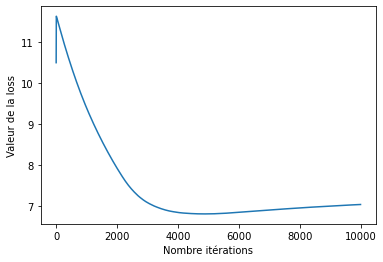

In [159]:
print_Loss(suivi_it_7, Loss_7)

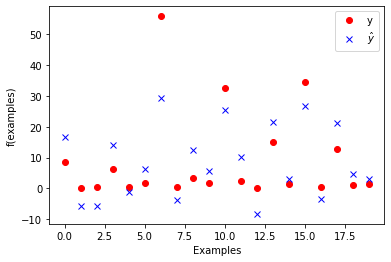

In [160]:
print_accurancy_model(w_7, 20)

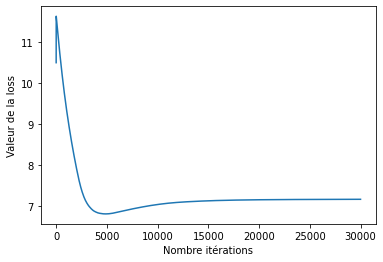

In [161]:
print_Loss(suivi_it_8, Loss_8)

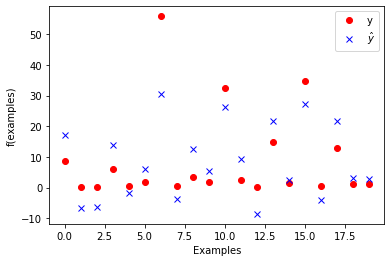

In [162]:
print_accurancy_model(w_8, 20)

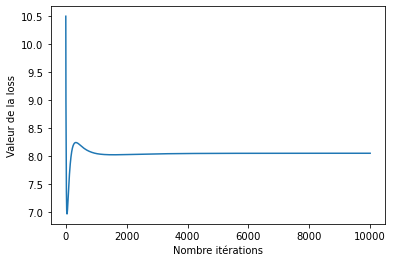

In [163]:
print_Loss(suivi_it_55, Loss_55)

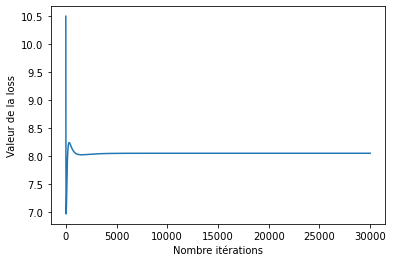

In [164]:
print_Loss(suivi_it_66, Loss_66)

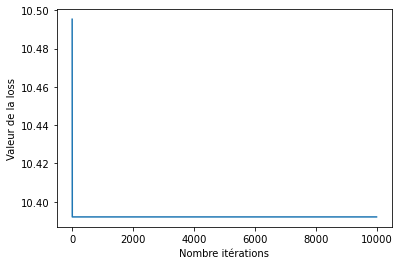

In [165]:
print_Loss(suivi_it_555, Loss_555)

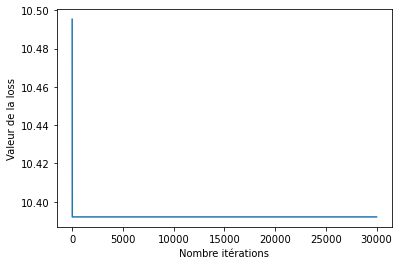

In [166]:
print_Loss(suivi_it_666, Loss_666)

In [205]:
print("w5 R2:", r2(w_5,100))
print("w6 R2:", r2(w_6,100))
print("w7 R2:", r2(w_7,100))
print("w8 R2:", r2(w_8,100))
print("w55 R2:", r2(w_55,100))
print("w66 R2:", r2(w_66,100))
print("w555 R2:", r2(w_555,100))
print("w666 R2:", r2(w_666,100))

# Nous avons qu'en utilisant w3, w4, w11 les modèles les plus précis

w5 R2: 0.008778762418283792
w6 R2: 0.08561182202566953
w7 R2: 0.6538120988949359
w8 R2: 0.6556073044248025
w55 R2: 0.45147710354944015
w66 R2: 0.4514779398431268
w555 R2: -0.001379412883961706
w666 R2: -0.0013794914185594198


## Exemples Loss 0/1

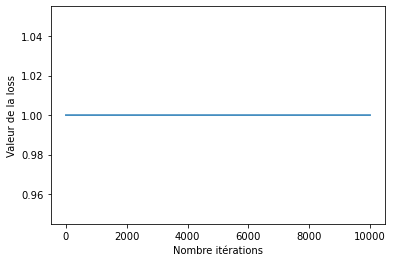

In [167]:
print_Loss(suivi_it_9, Loss_9)

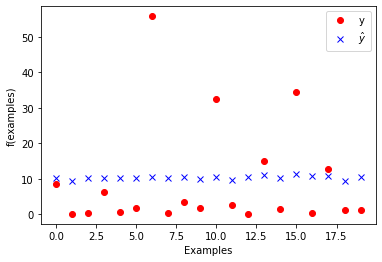

In [168]:
print_accurancy_model(w_9, 20)

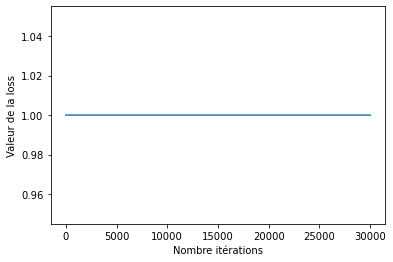

In [169]:
print_Loss(suivi_it_10, Loss_10)

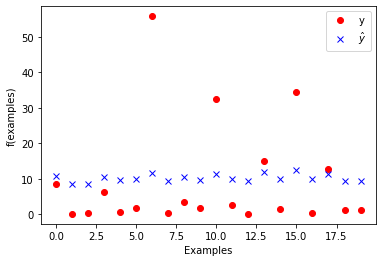

In [170]:
print_accurancy_model(w_10, 20)

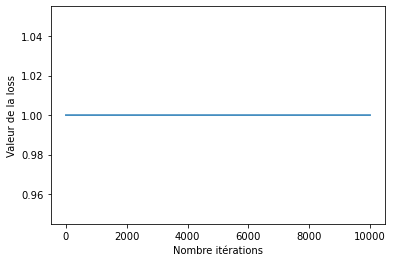

In [171]:
print_Loss(suivi_it_11, Loss_11)

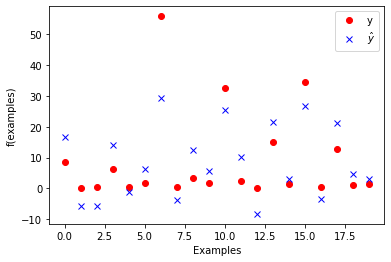

In [172]:
print_accurancy_model(w_11, 20)

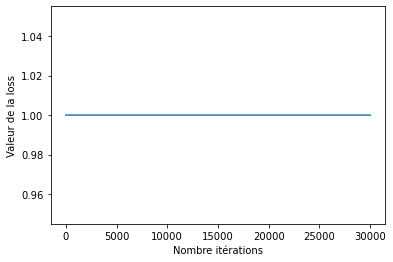

In [173]:
print_Loss(suivi_it_12, Loss_12)

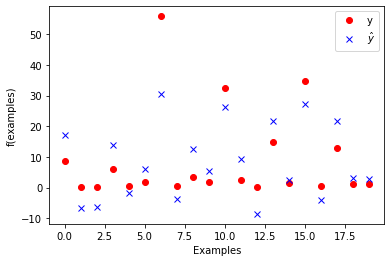

In [174]:
print_accurancy_model(w_12, 20)

## Modèle sélectionné:


In [207]:
# Pour avoir un compromis entre précision et vitesse d'exécution
nb_ite_f, suivi_it_f, Loss_f, w_f = descent(W, X, Y, loss_2, 10e-5, 8000)
print("R2 du modèle sélectionné:", r2(w_f,100))

R2 du modèle sélectionné: 0.650604672508211


## Conclusion des différentes expérimentations

Nous avons travaillé avec 3 normes: L1, L2, L0/1.
La convergence de la descente de gradient dépend du pas que nous avons choisi. En effet, ce dernier impacte non seulement la convergence mais aussi la rapidité de convergence en fonction de s'il est trop petit ou grand.

Nous allons surtout pouvoir analyser le comportement de L1, L2 faute d'avoir un algorithme de descente de gradient se contentant d'avoir comme critère de sortie de boucle un nombre max d'itérations.
Dans quelques cas, avec un bon pas, nous avons convergence de la loss vers une valeur minimale ce qui fait que selon le pas alpha, la loss employée, le maximum d'itérations à faire peut être réduit augmentant ainsi les performances de notre modèle tout en gardant une bonne précision. Voici pour les deux loss, le meilleur paramétrage testé.

Pour la loss 2: (meilleur modèle R2 = 0.6556073044248025) Alpha = 10e-5, max itérations = 30000
Remarque, on peut descendre le maximum d'itération entre 8000 et 10000 sans que cela ne change profondément la précision de notre modèle.

Pour la loss 1: (meilleur modèle R2 = 0.6556073044248025) Alpha = 10e-5, max itérations = 30000
Remarque, on peut descendre le maximum d'itération vers 15000.

En utilisant la loss 2 on converge plus rapidement qu'avec la loss 1. Nous sélectionnons donc un modèle avec la loss 2 (voir ci-dessus)

Le modèle final n'est pas optimal pour un perceptron. Par exemple, pour la descente du gradient, la condition de sortie est uniquement basée sur le nombre d'itérations max. Ce critère tout seul est insuffisant pour optimiser l'algorithme de descente de gradient. On peut par exemple rajouter comme critère d'arrêt la convergence du vecteur poids vers un degré de précision en travaillant avec la norme des variations de ce vecteur à chaque itération.
Nous pouvons également modifier la fonction d'activation du perceptron en chosissant certaines avec de très bonnes propriétés comme la fonction logisitique, la fonction tanh...




# Going further

The following are extensions of the work previously done. If attempting them **do not modify** the code you produced above so that it can be evaluated.

### Improvements to gradient descent

Consider improving the gradient descent with:

 - Stochastic Gradient Descent (SGD), which means selecting a subset of the examples for training
 - Detection of convergence to halt the algorithm before the maximum number of iterations


### Data normalization

Different input features can have different units, and very different ranges.
Within the perceptron computation, these values will be summed together.
While gradient descent is normally able to deal with this (by adapting the weights of the perceptron for each input feature), standardizing the input features usually eases the perceptron training, and can sometimes improve accuracy.




```python
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(copy=True) 
X_normalized = sc.fit_transform(X)
```

Try applying a standard normalization to the input features (make sure that you keep a feature column that is always equal to 1). Is the convergence faster ? Try to quantify this speed-up. What about accuracy ?

In [296]:
from datetime import datetime

def sgd_descent(w_init, X, Y, loss, alpha, tolerance, max_iter):
    
    init_time = datetime.now()
    
    w = np.copy(w_init)
    w_prec = np.zeros(N)
    iterateur = []
    i = 0
    iterateur.append(i)
    
    Loss = []
    Loss.append(emp_loss(w, X, Y,loss))
    
    nb_sub = len(Y)
    
    emp_prec = 3000
    # On pourrait rajouter un critère de convergence lorsque le vecteur poids ne change quasi plus ou la norme
    #  OU emp_loss(w, X, Y)>= degrés de précision
    while abs(emp_loss(w, X, Y,loss)-emp_prec)>= tolerance and i < max_iter:
        w_prec = np.copy(w)
        emp_prec = emp_loss(w, X, Y,loss)
        k = 0
        for k in range(nb_sub):
            rand_int = np.random.randint(nb_sub/4,nb_sub)
            Xk = X[rand_int,:].reshape(1,X.shape[1])
            Yk = Y[rand_int].reshape(1,1)
            w=compute_update(w, Xk, Yk, alpha)
        Loss.append(emp_loss(w, X, Y,loss))
        print("i:", i)
        print("loss:", emp_loss(w, X, Y,loss))
        print("critere:", abs(emp_loss(w, X, Y,loss)-emp_prec))
        i=i+1
        iterateur.append(i)
        
        fin_time = datetime.now()
        
        print("Temps exécution:", fin_time-init_time)
        
    #On retourne le nombre d'itérations nécéssaires, un tableau contenant les différents passages dans la boucles
    # en vue d'un affichage, la valeur de la Loss ainsi que le vecteur poids
    return i, iterateur, Loss, w

In [297]:
W_sgd = np.ones(N)
nb_ite_k, suivi_it_k, Loss_k, w_k = sgd_descent(W, X, Y, loss_2, 10e-5, 1e-6, 10000)
print(r2(w_k,100))
print(nb_ite_k)

i: 0
loss: 233.71229840465622
critere: 105.53444802391499
Temps exécution: 0:00:00.021188
i: 1
loss: 230.13284099099917
critere: 3.579457413657053
Temps exécution: 0:00:00.046682
i: 2
loss: 230.80377852436584
critere: 0.6709375333666685
Temps exécution: 0:00:00.077241
i: 3
loss: 229.60765158973186
critere: 1.1961269346339805
Temps exécution: 0:00:00.095896
i: 4
loss: 230.09403427200897
critere: 0.48638268227711023
Temps exécution: 0:00:00.113329
i: 5
loss: 229.69696350511794
critere: 0.3970707668910336
Temps exécution: 0:00:00.130274
i: 6
loss: 229.03439808240637
critere: 0.662565422711566
Temps exécution: 0:00:00.147554
i: 7
loss: 233.41835242481395
critere: 4.383954342407577
Temps exécution: 0:00:00.164958
i: 8
loss: 229.16082231332592
critere: 4.257530111488023
Temps exécution: 0:00:00.182126
i: 9
loss: 231.53059893967227
critere: 2.3697766263463507
Temps exécution: 0:00:00.199470
i: 10
loss: 230.04180360213414
critere: 1.4887953375381358
Temps exécution: 0:00:00.216529
i: 11
loss: 

i: 101
loss: 222.07627092412574
critere: 2.306233449412474
Temps exécution: 0:00:01.940091
i: 102
loss: 228.55043136388608
critere: 6.47416043976034
Temps exécution: 0:00:01.958540
i: 103
loss: 222.65242695464366
critere: 5.898004409242418
Temps exécution: 0:00:01.985322
i: 104
loss: 219.34976600048188
critere: 3.30266095416178
Temps exécution: 0:00:02.003252
i: 105
loss: 219.43506947463632
critere: 0.08530347415444339
Temps exécution: 0:00:02.021307
i: 106
loss: 220.0311721844744
critere: 0.5961027098380782
Temps exécution: 0:00:02.039301
i: 107
loss: 222.51639645513328
critere: 2.4852242706588754
Temps exécution: 0:00:02.058176
i: 108
loss: 223.44367550286168
critere: 0.9272790477284047
Temps exécution: 0:00:02.075829
i: 109
loss: 219.69929681981745
critere: 3.744378683044232
Temps exécution: 0:00:02.097714
i: 110
loss: 219.11172887475067
critere: 0.5875679450667803
Temps exécution: 0:00:02.115415
i: 111
loss: 218.76929541896078
critere: 0.3424334557898874
Temps exécution: 0:00:02.15

i: 200
loss: 213.33679220955318
critere: 2.153222902908084
Temps exécution: 0:00:04.195958
i: 201
loss: 214.63183992922373
critere: 1.2950477196705492
Temps exécution: 0:00:04.220044
i: 202
loss: 215.1509662574728
critere: 0.5191263282490581
Temps exécution: 0:00:04.238560
i: 203
loss: 211.94983145710808
critere: 3.201134800364713
Temps exécution: 0:00:04.258550
i: 204
loss: 210.62504901760113
critere: 1.3247824395069472
Temps exécution: 0:00:04.277015
i: 205
loss: 211.5287198929665
critere: 0.9036708753653784
Temps exécution: 0:00:04.295663
i: 206
loss: 210.55971460030108
critere: 0.9690052926654289
Temps exécution: 0:00:04.320199
i: 207
loss: 212.92077184620425
critere: 2.3610572459031687
Temps exécution: 0:00:04.338371
i: 208
loss: 210.18715643583843
critere: 2.7336154103658146
Temps exécution: 0:00:04.355478
i: 209
loss: 210.1144309771434
critere: 0.07272545869503233
Temps exécution: 0:00:04.374818
i: 210
loss: 210.53310527995865
critere: 0.41867430281524776
Temps exécution: 0:00:0

i: 290
loss: 204.4396081399202
critere: 3.8994075500909275
Temps exécution: 0:00:05.902816
i: 291
loss: 205.33963664645353
critere: 0.9000285065333173
Temps exécution: 0:00:05.928650
i: 292
loss: 203.3145622814099
critere: 2.025074365043622
Temps exécution: 0:00:05.950849
i: 293
loss: 204.17268348298242
critere: 0.8581212015725157
Temps exécution: 0:00:05.967535
i: 294
loss: 203.56818603042598
critere: 0.6044974525564442
Temps exécution: 0:00:05.984635
i: 295
loss: 203.04053898928703
critere: 0.5276470411389482
Temps exécution: 0:00:06.001814
i: 296
loss: 203.59763448096078
critere: 0.5570954916737492
Temps exécution: 0:00:06.018854
i: 297
loss: 202.86951106638205
critere: 0.7281234145787323
Temps exécution: 0:00:06.035990
i: 298
loss: 203.17344299257897
critere: 0.303931926196924
Temps exécution: 0:00:06.052974
i: 299
loss: 203.31281325796994
critere: 0.13937026539096564
Temps exécution: 0:00:06.069709
i: 300
loss: 202.63032622210918
critere: 0.6824870358607598
Temps exécution: 0:00:0

i: 387
loss: 196.13013746440782
critere: 1.0811881619880523
Temps exécution: 0:00:07.794311
i: 388
loss: 195.89113992595009
critere: 0.2389975384577383
Temps exécution: 0:00:07.818833
i: 389
loss: 195.7523964970907
critere: 0.13874342885938518
Temps exécution: 0:00:07.839268
i: 390
loss: 197.8244773082351
critere: 2.0720808111443887
Temps exécution: 0:00:07.857933
i: 391
loss: 196.24125657657729
critere: 1.5832207316578035
Temps exécution: 0:00:07.876442
i: 392
loss: 196.50377696933754
critere: 0.2625203927602513
Temps exécution: 0:00:07.894556
i: 393
loss: 195.4430124166147
critere: 1.0607645527228442
Temps exécution: 0:00:07.912542
i: 394
loss: 196.14751673220042
critere: 0.7045043155857229
Temps exécution: 0:00:07.931094
i: 395
loss: 195.55542435451005
critere: 0.5920923776903635
Temps exécution: 0:00:07.949753
i: 396
loss: 195.5259712338619
critere: 0.029453120648156528
Temps exécution: 0:00:07.968260
i: 397
loss: 195.31283613515504
critere: 0.2131350987068572
Temps exécution: 0:00

i: 484
loss: 193.37862580331677
critere: 4.540032623279217
Temps exécution: 0:00:09.790734
i: 485
loss: 188.65994602550722
critere: 4.718679777809541
Temps exécution: 0:00:09.813383
i: 486
loss: 188.65791837029312
critere: 0.0020276552141069715
Temps exécution: 0:00:09.843626
i: 487
loss: 188.523997826224
critere: 0.13392054406912735
Temps exécution: 0:00:09.861820
i: 488
loss: 188.53031853910127
critere: 0.006320712877283086
Temps exécution: 0:00:09.879127
i: 489
loss: 189.13873751992887
critere: 0.6084189808275937
Temps exécution: 0:00:09.897292
i: 490
loss: 189.7923884258918
critere: 0.6536509059629338
Temps exécution: 0:00:09.923093
i: 491
loss: 192.44494987383564
critere: 2.652561447943839
Temps exécution: 0:00:09.942379
i: 492
loss: 188.5753742199967
critere: 3.8695756538389503
Temps exécution: 0:00:09.960698
i: 493
loss: 188.27822416752835
critere: 0.29715005246833925
Temps exécution: 0:00:09.978813
i: 494
loss: 188.2242427852191
critere: 0.05398138230924587
Temps exécution: 0:0

i: 579
loss: 182.1252358254911
critere: 0.031139367636342286
Temps exécution: 0:00:12.168730
i: 580
loss: 182.9502926585713
critere: 0.8250568330801968
Temps exécution: 0:00:12.195885
i: 581
loss: 182.79672879486944
critere: 0.15356386370186215
Temps exécution: 0:00:12.221972
i: 582
loss: 181.9005921109139
critere: 0.8961366839555467
Temps exécution: 0:00:12.239883
i: 583
loss: 184.86730454753328
critere: 2.966712436619389
Temps exécution: 0:00:12.257946
i: 584
loss: 182.06479274736688
critere: 2.8025118001664
Temps exécution: 0:00:12.275781
i: 585
loss: 181.71202157748763
critere: 0.3527711698792473
Temps exécution: 0:00:12.294113
i: 586
loss: 181.60364807031166
critere: 0.10837350717596905
Temps exécution: 0:00:12.311910
i: 587
loss: 182.30393999758843
critere: 0.7002919272767656
Temps exécution: 0:00:12.329978
i: 588
loss: 181.5965162420306
critere: 0.7074237555578406
Temps exécution: 0:00:12.347890
i: 589
loss: 181.49479213361374
critere: 0.10172410841684609
Temps exécution: 0:00:1

i: 672
loss: 179.2279937454774
critere: 2.9876966014078334
Temps exécution: 0:00:14.122140
i: 673
loss: 176.80360303395895
critere: 2.4243907115184413
Temps exécution: 0:00:14.158443
i: 674
loss: 176.64976409060225
critere: 0.15383894335670334
Temps exécution: 0:00:14.193199
i: 675
loss: 176.62411651770753
critere: 0.02564757289471231
Temps exécution: 0:00:14.218088
i: 676
loss: 175.9103953579456
critere: 0.7137211597619455
Temps exécution: 0:00:14.238079
i: 677
loss: 177.16479415623067
critere: 1.2543987982850808
Temps exécution: 0:00:14.256516
i: 678
loss: 178.15842527736214
critere: 0.9936311211314717
Temps exécution: 0:00:14.276900
i: 679
loss: 175.90070988642836
critere: 2.2577153909337824
Temps exécution: 0:00:14.300364
i: 680
loss: 180.2131010532783
critere: 4.312391166849949
Temps exécution: 0:00:14.318300
i: 681
loss: 175.45925596727577
critere: 4.753845086002542
Temps exécution: 0:00:14.344221
i: 682
loss: 176.39192625654672
critere: 0.9326702892709591
Temps exécution: 0:00:1

i: 763
loss: 171.1171943901437
critere: 1.4431900944048266
Temps exécution: 0:00:16.290262
i: 764
loss: 170.4983251081994
critere: 0.6188692819443133
Temps exécution: 0:00:16.311520
i: 765
loss: 173.06228317047302
critere: 2.5639580622736275
Temps exécution: 0:00:16.333314
i: 766
loss: 172.45349474477752
critere: 0.6087884256955078
Temps exécution: 0:00:16.350396
i: 767
loss: 170.5596714170427
critere: 1.8938233277348218
Temps exécution: 0:00:16.367482
i: 768
loss: 169.9711728808763
critere: 0.5884985361663837
Temps exécution: 0:00:16.386262
i: 769
loss: 170.5222046900715
critere: 0.5510318091951945
Temps exécution: 0:00:16.407179
i: 770
loss: 172.5028267071071
critere: 1.9806220170355857
Temps exécution: 0:00:16.438544
i: 771
loss: 170.03485651821447
critere: 2.4679701888926218
Temps exécution: 0:00:16.471683
i: 772
loss: 170.15137787427278
critere: 0.11652135605831404
Temps exécution: 0:00:16.509943
i: 773
loss: 170.09939299735913
critere: 0.05198487691365017
Temps exécution: 0:00:16

i: 860
loss: 165.72466358527475
critere: 0.25327214289612243
Temps exécution: 0:00:18.667051
i: 861
loss: 166.70736356185742
critere: 0.9826999765826656
Temps exécution: 0:00:18.691199
i: 862
loss: 168.1394533639821
critere: 1.4320898021246933
Temps exécution: 0:00:18.709706
i: 863
loss: 166.80550430186545
critere: 1.333949062116659
Temps exécution: 0:00:18.728411
i: 864
loss: 165.82542100386337
critere: 0.9800832980020857
Temps exécution: 0:00:18.746599
i: 865
loss: 165.23636454760768
critere: 0.5890564562556904
Temps exécution: 0:00:18.765032
i: 866
loss: 165.4515644717785
critere: 0.21519992417083245
Temps exécution: 0:00:18.783279
i: 867
loss: 164.58582284167096
critere: 0.86574163010755
Temps exécution: 0:00:18.801704
i: 868
loss: 165.01026841332492
critere: 0.4244455716539619
Temps exécution: 0:00:18.819994
i: 869
loss: 166.70577396263383
critere: 1.6955055493089048
Temps exécution: 0:00:18.838239
i: 870
loss: 167.36516629667432
critere: 0.6593923340404899
Temps exécution: 0:00:1

i: 959
loss: 159.65723928725035
critere: 0.09594816987649324
Temps exécution: 0:00:20.576725
i: 960
loss: 159.50567771013178
critere: 0.15156157711857077
Temps exécution: 0:00:20.600471
i: 961
loss: 160.10174123876425
critere: 0.5960635286324703
Temps exécution: 0:00:20.619898
i: 962
loss: 159.22389859350852
critere: 0.8778426452557255
Temps exécution: 0:00:20.638330
i: 963
loss: 159.16306006941102
critere: 0.06083852409750534
Temps exécution: 0:00:20.657055
i: 964
loss: 159.42961104181651
critere: 0.2665509724054971
Temps exécution: 0:00:20.675620
i: 965
loss: 159.21089463909618
critere: 0.21871640272033233
Temps exécution: 0:00:20.694144
i: 966
loss: 159.04222694226468
critere: 0.1686676968315055
Temps exécution: 0:00:20.712595
i: 967
loss: 159.002151301269
critere: 0.04007564099566707
Temps exécution: 0:00:20.731230
i: 968
loss: 159.61365935272715
critere: 0.611508051458145
Temps exécution: 0:00:20.749808
i: 969
loss: 160.3404610559078
critere: 0.7268017031806551
Temps exécution: 0:

i: 1058
loss: 154.53950610860048
critere: 1.7454064354082277
Temps exécution: 0:00:22.504022
i: 1059
loss: 159.95932249618474
critere: 5.419816387584262
Temps exécution: 0:00:22.524432
i: 1060
loss: 154.4552622384158
critere: 5.504060257768941
Temps exécution: 0:00:22.546984
i: 1061
loss: 154.7212964945264
critere: 0.2660342561106006
Temps exécution: 0:00:22.566538
i: 1062
loss: 154.4026000975335
critere: 0.3186963969928911
Temps exécution: 0:00:22.585817
i: 1063
loss: 154.43648439265476
critere: 0.03388429512125413
Temps exécution: 0:00:22.604478
i: 1064
loss: 154.74728569872426
critere: 0.31080130606949297
Temps exécution: 0:00:22.623169
i: 1065
loss: 154.3366294083245
critere: 0.41065629039974283
Temps exécution: 0:00:22.642179
i: 1066
loss: 154.2894364199918
critere: 0.047192988332710684
Temps exécution: 0:00:22.660831
i: 1067
loss: 154.22784066787136
critere: 0.06159575212043933
Temps exécution: 0:00:22.679326
i: 1068
loss: 157.23457598177998
critere: 3.006735313908621
Temps exécu

i: 1153
loss: 149.95124974335295
critere: 1.2044504837119803
Temps exécution: 0:00:24.913711
i: 1154
loss: 149.8447752908988
critere: 0.10647445245413678
Temps exécution: 0:00:24.939260
i: 1155
loss: 150.04711764554688
critere: 0.20234235464806716
Temps exécution: 0:00:24.958565
i: 1156
loss: 150.07093074457757
critere: 0.023813099030689955
Temps exécution: 0:00:24.977793
i: 1157
loss: 149.74029560016348
critere: 0.3306351444140887
Temps exécution: 0:00:24.997081
i: 1158
loss: 150.81728906354428
critere: 1.076993463380802
Temps exécution: 0:00:25.015980
i: 1159
loss: 150.10401525643098
critere: 0.7132738071132962
Temps exécution: 0:00:25.035239
i: 1160
loss: 150.22633125312544
critere: 0.12231599669445359
Temps exécution: 0:00:25.054317
i: 1161
loss: 149.59416315030148
critere: 0.6321681028239539
Temps exécution: 0:00:25.073561
i: 1162
loss: 150.12229911365995
critere: 0.5281359633584657
Temps exécution: 0:00:25.092572
i: 1163
loss: 149.67891280304468
critere: 0.4433863106152671
Temps 

i: 1244
loss: 146.6096823926322
critere: 0.23718269785820212
Temps exécution: 0:00:27.321645
i: 1245
loss: 146.5832301012295
critere: 0.02645229140270544
Temps exécution: 0:00:27.357864
i: 1246
loss: 145.96845362293303
critere: 0.6147764782964771
Temps exécution: 0:00:27.384822
i: 1247
loss: 145.80240747674486
critere: 0.16604614618816527
Temps exécution: 0:00:27.403684
i: 1248
loss: 146.17531126903893
critere: 0.37290379229406767
Temps exécution: 0:00:27.423263
i: 1249
loss: 145.97976654263962
critere: 0.1955447263993051
Temps exécution: 0:00:27.441865
i: 1250
loss: 146.22957627390724
critere: 0.24980973126761796
Temps exécution: 0:00:27.460607
i: 1251
loss: 146.59576668493264
critere: 0.36619041102539995
Temps exécution: 0:00:27.479472
i: 1252
loss: 147.5418636818637
critere: 0.9460969969310611
Temps exécution: 0:00:27.498157
i: 1253
loss: 147.2308650794789
critere: 0.3109986023848137
Temps exécution: 0:00:27.516708
i: 1254
loss: 145.62331621181568
critere: 1.607548867663212
Temps ex

i: 1333
loss: 142.41602002159505
critere: 0.13876612395520738
Temps exécution: 0:00:29.090340
i: 1334
loss: 143.0339455216807
critere: 0.6179255000856472
Temps exécution: 0:00:29.111069
i: 1335
loss: 144.76144305861985
critere: 1.727497536939154
Temps exécution: 0:00:29.133212
i: 1336
loss: 142.0112398139031
critere: 2.7502032447167437
Temps exécution: 0:00:29.151588
i: 1337
loss: 142.11153231789086
critere: 0.10029250398775957
Temps exécution: 0:00:29.170191
i: 1338
loss: 142.3465802695428
critere: 0.23504795165194992
Temps exécution: 0:00:29.188491
i: 1339
loss: 142.16969062914004
critere: 0.1768896404027771
Temps exécution: 0:00:29.207143
i: 1340
loss: 143.17583328211933
critere: 1.0061426529792925
Temps exécution: 0:00:29.225675
i: 1341
loss: 142.52610975698767
critere: 0.6497235251316624
Temps exécution: 0:00:29.244086
i: 1342
loss: 141.82248199192588
critere: 0.7036277650617819
Temps exécution: 0:00:29.262663
i: 1343
loss: 141.96166360008937
critere: 0.1391816081634829
Temps exéc

i: 1431
loss: 138.3306087605366
critere: 0.05011572509923212
Temps exécution: 0:00:31.495232
i: 1432
loss: 138.79025719301205
critere: 0.4596484324754613
Temps exécution: 0:00:31.516479
i: 1433
loss: 138.39513278286836
critere: 0.39512441014369415
Temps exécution: 0:00:31.536016
i: 1434
loss: 138.51372938824946
critere: 0.11859660538110006
Temps exécution: 0:00:31.554939
i: 1435
loss: 138.5716668834899
critere: 0.05793749524045211
Temps exécution: 0:00:31.574000
i: 1436
loss: 138.66666847691815
critere: 0.09500159342823622
Temps exécution: 0:00:31.593281
i: 1437
loss: 138.41947898626515
critere: 0.24718949065299967
Temps exécution: 0:00:31.612303
i: 1438
loss: 138.4654091919149
critere: 0.045930205649739264
Temps exécution: 0:00:31.631106
i: 1439
loss: 138.14774101526487
critere: 0.3176681766500167
Temps exécution: 0:00:31.650204
i: 1440
loss: 137.9984725072298
critere: 0.14926850803507818
Temps exécution: 0:00:31.669109
i: 1441
loss: 138.06326738116545
critere: 0.06479487393565364
Tem

i: 1520
loss: 137.61262368383936
critere: 1.9429249525866794
Temps exécution: 0:00:33.452696
i: 1521
loss: 134.9083395471491
critere: 2.704284136690262
Temps exécution: 0:00:33.496917
i: 1522
loss: 134.84976805792974
critere: 0.05857148921936073
Temps exécution: 0:00:33.540904
i: 1523
loss: 134.9002227767144
critere: 0.05045471878466401
Temps exécution: 0:00:33.588572
i: 1524
loss: 135.06403350621684
critere: 0.16381072950244402
Temps exécution: 0:00:33.642137
i: 1525
loss: 134.78290462480658
critere: 0.28112888141026815
Temps exécution: 0:00:33.681465
i: 1526
loss: 137.15461875838608
critere: 2.371714133579502
Temps exécution: 0:00:33.701342
i: 1527
loss: 136.0388709222671
critere: 1.1157478361189703
Temps exécution: 0:00:33.728761
i: 1528
loss: 135.20005705380592
critere: 0.8388138684611874
Temps exécution: 0:00:33.748505
i: 1529
loss: 135.03652776189668
critere: 0.16352929190924215
Temps exécution: 0:00:33.768260
i: 1530
loss: 137.0430528091272
critere: 2.006525047230525
Temps exécu

i: 1616
loss: 132.10810003554002
critere: 0.440929066520539
Temps exécution: 0:00:35.560593
i: 1617
loss: 134.4414331619906
critere: 2.333333126450583
Temps exécution: 0:00:35.586517
i: 1618
loss: 131.96540475892573
critere: 2.4760284030648734
Temps exécution: 0:00:35.612052
i: 1619
loss: 131.36080211497048
critere: 0.6046026439552463
Temps exécution: 0:00:35.631015
i: 1620
loss: 131.48687582950603
critere: 0.1260737145355506
Temps exécution: 0:00:35.649719
i: 1621
loss: 131.43813357076453
critere: 0.04874225874149829
Temps exécution: 0:00:35.668631
i: 1622
loss: 132.1513713556081
critere: 0.7132377848435567
Temps exécution: 0:00:35.687266
i: 1623
loss: 131.81156182858965
critere: 0.3398095270184456
Temps exécution: 0:00:35.706033
i: 1624
loss: 131.49824232140557
critere: 0.313319507184076
Temps exécution: 0:00:35.724809
i: 1625
loss: 131.34172847013306
critere: 0.15651385127250705
Temps exécution: 0:00:35.743590
i: 1626
loss: 131.17921245079503
critere: 0.16251601933802817
Temps exécu

i: 1711
loss: 129.0588978219199
critere: 0.6467432731478766
Temps exécution: 0:00:37.579816
i: 1712
loss: 129.1280957480814
critere: 0.06919792616147902
Temps exécution: 0:00:37.615864
i: 1713
loss: 128.9807821801079
critere: 0.14731356797349804
Temps exécution: 0:00:37.651815
i: 1714
loss: 128.74564389053995
critere: 0.23513828956794214
Temps exécution: 0:00:37.687643
i: 1715
loss: 128.28530139364892
critere: 0.46034249689103035
Temps exécution: 0:00:37.709326
i: 1716
loss: 128.19057523870148
critere: 0.09472615494743764
Temps exécution: 0:00:37.731356
i: 1717
loss: 128.24707119446498
critere: 0.056495955763494976
Temps exécution: 0:00:37.750533
i: 1718
loss: 128.43551615721654
critere: 0.18844496275156075
Temps exécution: 0:00:37.769279
i: 1719
loss: 128.24227236314448
critere: 0.19324379407206038
Temps exécution: 0:00:37.788454
i: 1720
loss: 128.05721472379398
critere: 0.18505763935050368
Temps exécution: 0:00:37.807162
i: 1721
loss: 128.15296089037395
critere: 0.09574616657997126
T

i: 1800
loss: 125.72906548984889
critere: 0.4622713651223904
Temps exécution: 0:00:39.462863
i: 1801
loss: 125.74521016993462
critere: 0.016144680085730556
Temps exécution: 0:00:39.487159
i: 1802
loss: 125.71136500040544
critere: 0.03384516952918659
Temps exécution: 0:00:39.505670
i: 1803
loss: 126.0666689725731
critere: 0.3553039721676612
Temps exécution: 0:00:39.524555
i: 1804
loss: 125.53992279088223
critere: 0.5267461816908678
Temps exécution: 0:00:39.543199
i: 1805
loss: 129.25215321335332
critere: 3.7122304224710945
Temps exécution: 0:00:39.562067
i: 1806
loss: 125.706101103313
critere: 3.5460521100403213
Temps exécution: 0:00:39.580827
i: 1807
loss: 125.63753262114825
critere: 0.06856848216474987
Temps exécution: 0:00:39.599789
i: 1808
loss: 125.35614558768265
critere: 0.2813870334656059
Temps exécution: 0:00:39.618369
i: 1809
loss: 125.32334806246548
critere: 0.032797525217162615
Temps exécution: 0:00:39.637198
i: 1810
loss: 125.29855410419488
critere: 0.02479395827060671
Temps

i: 1888
loss: 123.08674960141774
critere: 0.10086641251025696
Temps exécution: 0:00:41.182709
i: 1889
loss: 123.21177554924108
critere: 0.12502594782334597
Temps exécution: 0:00:41.202616
i: 1890
loss: 123.03654524173102
critere: 0.17523030751006274
Temps exécution: 0:00:41.223374
i: 1891
loss: 123.01204746552767
critere: 0.024497776203347144
Temps exécution: 0:00:41.242225
i: 1892
loss: 122.9691125054376
critere: 0.042934960090079244
Temps exécution: 0:00:41.260943
i: 1893
loss: 123.49271516848411
critere: 0.5236026630465176
Temps exécution: 0:00:41.279623
i: 1894
loss: 123.80768059789273
critere: 0.31496542940861616
Temps exécution: 0:00:41.298147
i: 1895
loss: 122.89482838729715
critere: 0.9128522105955739
Temps exécution: 0:00:41.316878
i: 1896
loss: 125.42745812117862
critere: 2.532629733881464
Temps exécution: 0:00:41.335358
i: 1897
loss: 123.2010091290923
critere: 2.2264489920863184
Temps exécution: 0:00:41.354176
i: 1898
loss: 123.09502073265018
critere: 0.10598839644211466
Tem

i: 1976
loss: 120.72668000964279
critere: 0.0559676084883165
Temps exécution: 0:00:42.913395
i: 1977
loss: 120.79946042606457
critere: 0.07278041642177868
Temps exécution: 0:00:42.937370
i: 1978
loss: 120.87917563000023
critere: 0.07971520393566323
Temps exécution: 0:00:42.956058
i: 1979
loss: 120.58514288625692
critere: 0.29403274374331545
Temps exécution: 0:00:42.975062
i: 1980
loss: 120.67947175918918
critere: 0.094328872932266
Temps exécution: 0:00:42.993719
i: 1981
loss: 120.55483672579007
critere: 0.12463503339911597
Temps exécution: 0:00:43.012513
i: 1982
loss: 121.35893086808954
critere: 0.8040941422994763
Temps exécution: 0:00:43.031140
i: 1983
loss: 120.61795178094098
critere: 0.7409790871485598
Temps exécution: 0:00:43.050342
i: 1984
loss: 120.63093002166474
critere: 0.012978240723754197
Temps exécution: 0:00:43.069029
i: 1985
loss: 122.13099063696245
critere: 1.5000606152977127
Temps exécution: 0:00:43.087698
i: 1986
loss: 120.75581391014191
critere: 1.3751767268205413
Temp

i: 2064
loss: 118.25685090809148
critere: 0.3398591863988685
Temps exécution: 0:00:44.649269
i: 2065
loss: 118.32884183123772
critere: 0.07199092314624522
Temps exécution: 0:00:44.670189
i: 2066
loss: 118.43025456631032
critere: 0.10141273507259996
Temps exécution: 0:00:44.692652
i: 2067
loss: 119.27556221497453
critere: 0.8453076486642033
Temps exécution: 0:00:44.711655
i: 2068
loss: 120.63180599744862
critere: 1.3562437824740954
Temps exécution: 0:00:44.730411
i: 2069
loss: 118.23959862567374
critere: 2.3922073717748873
Temps exécution: 0:00:44.749349
i: 2070
loss: 119.58228519602548
critere: 1.342686570351745
Temps exécution: 0:00:44.768178
i: 2071
loss: 118.13546144952129
critere: 1.4468237465041938
Temps exécution: 0:00:44.786927
i: 2072
loss: 118.9732675399128
critere: 0.8378060903915099
Temps exécution: 0:00:44.805520
i: 2073
loss: 118.33703116408486
critere: 0.6362363758279344
Temps exécution: 0:00:44.825142
i: 2074
loss: 119.09017878552497
critere: 0.7531476214401067
Temps exé

i: 2152
loss: 116.27258015517205
critere: 0.15780574085299293
Temps exécution: 0:00:46.380963
i: 2153
loss: 116.29479415723885
critere: 0.022214002066803573
Temps exécution: 0:00:46.403236
i: 2154
loss: 116.05492826254562
critere: 0.2398658946932386
Temps exécution: 0:00:46.421896
i: 2155
loss: 116.2912064010885
critere: 0.23627813854288604
Temps exécution: 0:00:46.440897
i: 2156
loss: 116.03444620954372
critere: 0.25676019154478524
Temps exécution: 0:00:46.459688
i: 2157
loss: 116.04446262136035
critere: 0.01001641181663615
Temps exécution: 0:00:46.482540
i: 2158
loss: 117.41996439059866
critere: 1.375501769238312
Temps exécution: 0:00:46.502097
i: 2159
loss: 116.29349001953854
critere: 1.1264743710601266
Temps exécution: 0:00:46.521191
i: 2160
loss: 116.1688722088266
critere: 0.12461781071193911
Temps exécution: 0:00:46.539920
i: 2161
loss: 117.65954053450285
critere: 1.4906683256762534
Temps exécution: 0:00:46.558623
i: 2162
loss: 116.0845135526644
critere: 1.5750269818384481
Temps 

i: 2240
loss: 114.03238563209712
critere: 0.12869014812338264
Temps exécution: 0:00:48.113545
i: 2241
loss: 114.03019390945751
critere: 0.002191722639608429
Temps exécution: 0:00:48.135131
i: 2242
loss: 114.3783961152696
critere: 0.34820220581208616
Temps exécution: 0:00:48.157437
i: 2243
loss: 114.18068892057143
critere: 0.1977071946981681
Temps exécution: 0:00:48.176517
i: 2244
loss: 114.38715117700924
critere: 0.2064622564378169
Temps exécution: 0:00:48.195495
i: 2245
loss: 114.0210097919007
critere: 0.36614138510854843
Temps exécution: 0:00:48.214459
i: 2246
loss: 113.95854123423848
critere: 0.06246855766221415
Temps exécution: 0:00:48.233330
i: 2247
loss: 114.18013840933693
critere: 0.22159717509845223
Temps exécution: 0:00:48.252213
i: 2248
loss: 114.95914080209286
critere: 0.7790023927559275
Temps exécution: 0:00:48.270904
i: 2249
loss: 114.95295760386038
critere: 0.006183198232477594
Temps exécution: 0:00:48.290469
i: 2250
loss: 113.83992169155225
critere: 1.1130359123081348
Te

i: 2328
loss: 112.10121269635167
critere: 0.06805872163948834
Temps exécution: 0:00:49.855960
i: 2329
loss: 112.52762394507923
critere: 0.4264112487275611
Temps exécution: 0:00:49.879441
i: 2330
loss: 112.06110604907067
critere: 0.4665178960085541
Temps exécution: 0:00:49.899035
i: 2331
loss: 112.03839256541697
critere: 0.022713483653703292
Temps exécution: 0:00:49.918185
i: 2332
loss: 112.24622630174528
critere: 0.20783373632831115
Temps exécution: 0:00:49.937028
i: 2333
loss: 112.44062930780522
critere: 0.1944030060599431
Temps exécution: 0:00:49.956138
i: 2334
loss: 112.32672570724421
critere: 0.11390360056101656
Temps exécution: 0:00:49.974989
i: 2335
loss: 112.35002663755314
critere: 0.023300930308934653
Temps exécution: 0:00:49.994375
i: 2336
loss: 112.14485950129287
critere: 0.20516713626027183
Temps exécution: 0:00:50.013194
i: 2337
loss: 111.85891953118723
critere: 0.28593997010564465
Temps exécution: 0:00:50.032262
i: 2338
loss: 112.12603745345237
critere: 0.2671179222651432


i: 2416
loss: 111.3059790547741
critere: 0.8426266762162697
Temps exécution: 0:00:51.590640
i: 2417
loss: 110.1834346093836
critere: 1.1225444453905027
Temps exécution: 0:00:51.612286
i: 2418
loss: 110.41393438581238
critere: 0.23049977642878616
Temps exécution: 0:00:51.632008
i: 2419
loss: 110.49342491632635
critere: 0.07949053051396504
Temps exécution: 0:00:51.651292
i: 2420
loss: 110.160191878635
critere: 0.33323303769134327
Temps exécution: 0:00:51.669928
i: 2421
loss: 110.35260043958466
critere: 0.19240856094965864
Temps exécution: 0:00:51.688854
i: 2422
loss: 110.49838134365235
critere: 0.14578090406769206
Temps exécution: 0:00:51.707670
i: 2423
loss: 110.18787662251256
critere: 0.3105047211397931
Temps exécution: 0:00:51.726624
i: 2424
loss: 110.03918078384179
critere: 0.14869583867077552
Temps exécution: 0:00:51.745260
i: 2425
loss: 110.01882796567263
critere: 0.020352818169158127
Temps exécution: 0:00:51.764223
i: 2426
loss: 110.11946805171961
critere: 0.1006400860469796
Temps

i: 2504
loss: 108.48207525869967
critere: 0.73332513797709
Temps exécution: 0:00:53.313372
i: 2505
loss: 108.74825757015891
critere: 0.26618231145924653
Temps exécution: 0:00:53.338871
i: 2506
loss: 109.10229874082985
critere: 0.3540411706709392
Temps exécution: 0:00:53.357669
i: 2507
loss: 108.43503225604607
critere: 0.6672664847837808
Temps exécution: 0:00:53.376595
i: 2508
loss: 108.6379201501061
critere: 0.2028878940600265
Temps exécution: 0:00:53.395318
i: 2509
loss: 108.40344412781836
critere: 0.2344760222877369
Temps exécution: 0:00:53.414313
i: 2510
loss: 110.37788686182421
critere: 1.974442734005848
Temps exécution: 0:00:53.433265
i: 2511
loss: 108.35521186892383
critere: 2.0226749929003773
Temps exécution: 0:00:53.452439
i: 2512
loss: 108.34614977161623
critere: 0.009062097307605654
Temps exécution: 0:00:53.471092
i: 2513
loss: 108.32227294420727
critere: 0.023876827408955137
Temps exécution: 0:00:53.490345
i: 2514
loss: 108.32306010803251
critere: 0.000787163825236803
Temps 

i: 2592
loss: 107.07674600071933
critere: 0.1703036658899606
Temps exécution: 0:00:55.052939
i: 2593
loss: 108.31502383580346
critere: 1.2382778350841335
Temps exécution: 0:00:55.073252
i: 2594
loss: 107.93579334352157
critere: 0.37923049228189143
Temps exécution: 0:00:55.094800
i: 2595
loss: 106.98819973620151
critere: 0.9475936073200586
Temps exécution: 0:00:55.113874
i: 2596
loss: 106.85088888066103
critere: 0.13731085554047695
Temps exécution: 0:00:55.132514
i: 2597
loss: 107.40060255661939
critere: 0.5497136759583583
Temps exécution: 0:00:55.151603
i: 2598
loss: 106.80484271480928
critere: 0.5957598418101071
Temps exécution: 0:00:55.170252
i: 2599
loss: 107.17482654853212
critere: 0.3699838337228414
Temps exécution: 0:00:55.189162
i: 2600
loss: 106.76335536819937
critere: 0.41147118033275376
Temps exécution: 0:00:55.208117
i: 2601
loss: 106.75552517157067
critere: 0.007830196628702879
Temps exécution: 0:00:55.227334
i: 2602
loss: 106.77716187367028
critere: 0.021636702099613103
Te

i: 2680
loss: 107.85129418243235
critere: 1.1044730338127948
Temps exécution: 0:00:56.776333
i: 2681
loss: 105.34835526063283
critere: 2.502938921799526
Temps exécution: 0:00:56.800017
i: 2682
loss: 105.70084148689502
critere: 0.3524862262621866
Temps exécution: 0:00:56.818639
i: 2683
loss: 105.44323262629717
critere: 0.25760886059784127
Temps exécution: 0:00:56.837556
i: 2684
loss: 105.24367731776695
critere: 0.19955530853022196
Temps exécution: 0:00:56.856223
i: 2685
loss: 106.2388539394569
critere: 0.99517662168995
Temps exécution: 0:00:56.875000
i: 2686
loss: 106.01859630036014
critere: 0.22025763909675788
Temps exécution: 0:00:56.893656
i: 2687
loss: 105.80811914195796
critere: 0.21047715840218473
Temps exécution: 0:00:56.912362
i: 2688
loss: 105.24643316977766
critere: 0.5616859721802996
Temps exécution: 0:00:56.931077
i: 2689
loss: 105.42395466768389
critere: 0.17752149790622695
Temps exécution: 0:00:56.949865
i: 2690
loss: 105.17994630062783
critere: 0.244008367056054
Temps exé

i: 2768
loss: 103.87050400987302
critere: 0.5216438554827789
Temps exécution: 0:00:58.516656
i: 2769
loss: 104.62662835958331
critere: 0.7561243497102907
Temps exécution: 0:00:58.538198
i: 2770
loss: 105.81437127002026
critere: 1.1877429104369526
Temps exécution: 0:00:58.560018
i: 2771
loss: 104.00700910927218
critere: 1.8073621607480845
Temps exécution: 0:00:58.579017
i: 2772
loss: 104.72985996009388
critere: 0.7228508508217004
Temps exécution: 0:00:58.597642
i: 2773
loss: 104.01281958814596
critere: 0.7170403719479168
Temps exécution: 0:00:58.616772
i: 2774
loss: 104.55529216923239
critere: 0.5424725810864288
Temps exécution: 0:00:58.635473
i: 2775
loss: 103.87243185040896
critere: 0.6828603188234297
Temps exécution: 0:00:58.654446
i: 2776
loss: 104.11985312872407
critere: 0.24742127831511596
Temps exécution: 0:00:58.673193
i: 2777
loss: 103.7499672818766
critere: 0.36988584684748105
Temps exécution: 0:00:58.692016
i: 2778
loss: 103.72343325515548
critere: 0.026534026721108717
Temps 

i: 2856
loss: 102.8742997917157
critere: 0.33131607674663144
Temps exécution: 0:01:00.251203
i: 2857
loss: 102.99893998484643
critere: 0.12464019313073038
Temps exécution: 0:01:00.272369
i: 2858
loss: 102.84819658702486
critere: 0.15074339782157153
Temps exécution: 0:01:00.293102
i: 2859
loss: 102.54735733617404
critere: 0.30083925085081376
Temps exécution: 0:01:00.312885
i: 2860
loss: 103.28200480077263
critere: 0.7346474645985808
Temps exécution: 0:01:00.332274
i: 2861
loss: 102.69672787265985
critere: 0.5852769281127763
Temps exécution: 0:01:00.351245
i: 2862
loss: 102.61817514551566
critere: 0.07855272714418504
Temps exécution: 0:01:00.369913
i: 2863
loss: 103.25385234957969
critere: 0.6356772040640237
Temps exécution: 0:01:00.388772
i: 2864
loss: 102.38365274121837
critere: 0.8701996083613182
Temps exécution: 0:01:00.407288
i: 2865
loss: 103.78660287990671
critere: 1.4029501386883396
Temps exécution: 0:01:00.426246
i: 2866
loss: 102.34156941224661
critere: 1.445033467660096
Temps 

i: 2944
loss: 101.54870319263033
critere: 0.19219813403772434
Temps exécution: 0:01:01.979344
i: 2945
loss: 101.39170783016957
critere: 0.15699536246076207
Temps exécution: 0:01:01.999852
i: 2946
loss: 101.16797759599493
critere: 0.22373023417463855
Temps exécution: 0:01:02.020455
i: 2947
loss: 101.18684816680731
critere: 0.01887057081238197
Temps exécution: 0:01:02.039718
i: 2948
loss: 101.83109042991471
critere: 0.644242263107401
Temps exécution: 0:01:02.058666
i: 2949
loss: 101.15941473668543
critere: 0.6716756932292753
Temps exécution: 0:01:02.077748
i: 2950
loss: 101.23530627999152
critere: 0.07589154330608494
Temps exécution: 0:01:02.097064
i: 2951
loss: 101.1086828881032
critere: 0.12662339188831595
Temps exécution: 0:01:02.116240
i: 2952
loss: 101.57666609141863
critere: 0.467983203315427
Temps exécution: 0:01:02.135243
i: 2953
loss: 101.15800022537996
critere: 0.4186658660386655
Temps exécution: 0:01:02.154244
i: 2954
loss: 102.10944893103643
critere: 0.9514487056564604
Temps 

i: 3032
loss: 100.25144493223192
critere: 1.4730952006281655
Temps exécution: 0:01:03.724970
i: 3033
loss: 100.042641639582
critere: 0.20880329264991815
Temps exécution: 0:01:03.748035
i: 3034
loss: 100.18016506808571
critere: 0.13752342850371235
Temps exécution: 0:01:03.767086
i: 3035
loss: 100.30298111531097
critere: 0.12281604722525685
Temps exécution: 0:01:03.786652
i: 3036
loss: 99.91731000398948
critere: 0.3856711113214857
Temps exécution: 0:01:03.805822
i: 3037
loss: 101.00364605651569
critere: 1.0863360525262067
Temps exécution: 0:01:03.824987
i: 3038
loss: 99.90404284162187
critere: 1.0996032148938184
Temps exécution: 0:01:03.843801
i: 3039
loss: 100.4081387718052
critere: 0.5040959301833254
Temps exécution: 0:01:03.862858
i: 3040
loss: 100.3888151471389
critere: 0.01932362466629911
Temps exécution: 0:01:03.881852
i: 3041
loss: 99.98250278981634
critere: 0.40631235732256243
Temps exécution: 0:01:03.900583
i: 3042
loss: 99.86983466322732
critere: 0.11266812658901415
Temps exécu

i: 3131
loss: 98.83365339954955
critere: 0.07314187468470834
Temps exécution: 0:01:05.697674
i: 3132
loss: 99.11029697787178
critere: 0.2766435783222363
Temps exécution: 0:01:05.717018
i: 3133
loss: 99.25647836900409
critere: 0.146181391132302
Temps exécution: 0:01:05.736218
i: 3134
loss: 98.85852705877552
critere: 0.39795131022856367
Temps exécution: 0:01:05.755262
i: 3135
loss: 98.79060708842088
critere: 0.06791997035463737
Temps exécution: 0:01:05.774308
i: 3136
loss: 98.90310426960964
critere: 0.11249718118875762
Temps exécution: 0:01:05.793350
i: 3137
loss: 98.63087383992757
critere: 0.2722304296820681
Temps exécution: 0:01:05.812427
i: 3138
loss: 99.54522959127488
critere: 0.9143557513473013
Temps exécution: 0:01:05.831462
i: 3139
loss: 98.62178793487843
critere: 0.9234416563964487
Temps exécution: 0:01:05.850562
i: 3140
loss: 98.76873936268284
critere: 0.14695142780441017
Temps exécution: 0:01:05.869443
i: 3141
loss: 98.61608803466783
critere: 0.15265132801501125
Temps exécution

i: 3228
loss: 98.65547823975155
critere: 1.0775356225432233
Temps exécution: 0:01:07.621376
i: 3229
loss: 97.86939777978847
critere: 0.786080459963074
Temps exécution: 0:01:07.646478
i: 3230
loss: 97.59138158409348
critere: 0.27801619569498826
Temps exécution: 0:01:07.665826
i: 3231
loss: 97.976066012175
critere: 0.3846844280815134
Temps exécution: 0:01:07.685218
i: 3232
loss: 97.58699290498275
critere: 0.38907310719224597
Temps exécution: 0:01:07.704400
i: 3233
loss: 97.63430365758411
critere: 0.04731075260136208
Temps exécution: 0:01:07.723914
i: 3234
loss: 97.6450300901703
critere: 0.010726432586182
Temps exécution: 0:01:07.743032
i: 3235
loss: 97.49827571399575
critere: 0.1467543761745418
Temps exécution: 0:01:07.762869
i: 3236
loss: 98.23650748851273
critere: 0.7382317745169757
Temps exécution: 0:01:07.782018
i: 3237
loss: 97.87480782756506
critere: 0.36169966094766437
Temps exécution: 0:01:07.801615
i: 3238
loss: 97.4751074334927
critere: 0.3997003940723687
Temps exécution: 0:01:

i: 3326
loss: 96.40147036084575
critere: 0.06190043467759665
Temps exécution: 0:01:09.586314
i: 3327
loss: 96.38188484702323
critere: 0.01958551382251983
Temps exécution: 0:01:09.611012
i: 3328
loss: 97.2867528584121
critere: 0.9048680113888707
Temps exécution: 0:01:09.630742
i: 3329
loss: 96.37196805954953
critere: 0.9147847988625699
Temps exécution: 0:01:09.650294
i: 3330
loss: 96.76482552706146
critere: 0.39285746751193074
Temps exécution: 0:01:09.669671
i: 3331
loss: 96.49802059989456
critere: 0.26680492716690196
Temps exécution: 0:01:09.689449
i: 3332
loss: 96.37206168961428
critere: 0.12595891028027495
Temps exécution: 0:01:09.708671
i: 3333
loss: 96.35880997318215
critere: 0.013251716432137073
Temps exécution: 0:01:09.727797
i: 3334
loss: 96.32686687671787
critere: 0.031943096464274845
Temps exécution: 0:01:09.747440
i: 3335
loss: 96.40702359948942
critere: 0.08015672277154806
Temps exécution: 0:01:09.766521
i: 3336
loss: 96.37521100743503
critere: 0.03181259205439346
Temps exéc

i: 3422
loss: 95.83811782231606
critere: 0.43102111042801994
Temps exécution: 0:01:11.520788
i: 3423
loss: 95.34897510743019
critere: 0.48914271488587246
Temps exécution: 0:01:11.545618
i: 3424
loss: 97.18761963944178
critere: 1.8386445320115854
Temps exécution: 0:01:11.565001
i: 3425
loss: 96.20995503012486
critere: 0.9776646093169177
Temps exécution: 0:01:11.584736
i: 3426
loss: 95.30631262717456
critere: 0.9036424029502967
Temps exécution: 0:01:11.603787
i: 3427
loss: 95.3349892803184
critere: 0.028676653143833164
Temps exécution: 0:01:11.623208
i: 3428
loss: 95.39469738665765
critere: 0.05970810633925794
Temps exécution: 0:01:11.642421
i: 3429
loss: 95.32993075224242
critere: 0.06476663441523556
Temps exécution: 0:01:11.661908
i: 3430
loss: 95.31705419086654
critere: 0.012876561375875895
Temps exécution: 0:01:11.681442
i: 3431
loss: 96.30798619896957
critere: 0.9909320081030302
Temps exécution: 0:01:11.700751
i: 3432
loss: 95.45976813576925
critere: 0.8482180632003207
Temps exécuti

i: 3519
loss: 94.3893189326545
critere: 0.9722251712629486
Temps exécution: 0:01:13.472006
i: 3520
loss: 94.94161260571354
critere: 0.5522936730590402
Temps exécution: 0:01:13.494537
i: 3521
loss: 95.3009675421727
critere: 0.3593549364591553
Temps exécution: 0:01:13.514560
i: 3522
loss: 94.67807978907538
critere: 0.6228877530973165
Temps exécution: 0:01:13.533920
i: 3523
loss: 94.50342691857941
critere: 0.17465287049597578
Temps exécution: 0:01:13.553411
i: 3524
loss: 94.69830469179014
critere: 0.19487777321073452
Temps exécution: 0:01:13.572412
i: 3525
loss: 94.88387944406723
critere: 0.1855747522770912
Temps exécution: 0:01:13.591744
i: 3526
loss: 94.57881638754726
critere: 0.3050630565199697
Temps exécution: 0:01:13.610809
i: 3527
loss: 94.75826602837576
critere: 0.17944964082849424
Temps exécution: 0:01:13.630479
i: 3528
loss: 94.35479765159808
critere: 0.4034683767776812
Temps exécution: 0:01:13.649980
i: 3529
loss: 94.37031727203271
critere: 0.015519620434631065
Temps exécution: 

i: 3609
loss: 93.71556734201553
critere: 0.3898646598021571
Temps exécution: 0:01:15.289363
i: 3610
loss: 93.59682613410928
critere: 0.11874120790625398
Temps exécution: 0:01:15.313284
i: 3611
loss: 93.5746873577003
critere: 0.022138776408979766
Temps exécution: 0:01:15.332453
i: 3612
loss: 93.48479666448296
critere: 0.08989069321734178
Temps exécution: 0:01:15.351636
i: 3613
loss: 93.57174725784049
critere: 0.0869505933575283
Temps exécution: 0:01:15.370925
i: 3614
loss: 94.45429867245196
critere: 0.8825514146114699
Temps exécution: 0:01:15.389750
i: 3615
loss: 94.17697826801401
critere: 0.27732040443794403
Temps exécution: 0:01:15.408621
i: 3616
loss: 93.57450447239702
critere: 0.6024737956169872
Temps exécution: 0:01:15.427781
i: 3617
loss: 93.88599795110748
critere: 0.3114934787104602
Temps exécution: 0:01:15.446923
i: 3618
loss: 93.94882399605378
critere: 0.0628260449462914
Temps exécution: 0:01:15.465828
i: 3619
loss: 94.65432255835645
critere: 0.7054985623026795
Temps exécution:

i: 3702
loss: 92.93584134462307
critere: 0.19677699520033798
Temps exécution: 0:01:17.195945
i: 3703
loss: 93.02237504717847
critere: 0.08653370255539983
Temps exécution: 0:01:17.229638
i: 3704
loss: 92.68140236190774
critere: 0.340972685270728
Temps exécution: 0:01:17.248643
i: 3705
loss: 93.37667913406729
critere: 0.695276772159545
Temps exécution: 0:01:17.268046
i: 3706
loss: 92.69621849025701
critere: 0.680460643810278
Temps exécution: 0:01:17.287012
i: 3707
loss: 93.33718736390028
critere: 0.6409688736432742
Temps exécution: 0:01:17.306251
i: 3708
loss: 93.11068875610225
critere: 0.22649860779803532
Temps exécution: 0:01:17.325335
i: 3709
loss: 92.95986951068753
critere: 0.15081924541472347
Temps exécution: 0:01:17.344487
i: 3710
loss: 92.77235341133463
critere: 0.18751609935289082
Temps exécution: 0:01:17.363335
i: 3711
loss: 92.77126304299554
critere: 0.0010903683390921515
Temps exécution: 0:01:17.382410
i: 3712
loss: 92.57516198061928
critere: 0.19610106237625757
Temps exécutio

i: 3799
loss: 92.43058727334795
critere: 0.22853248352484457
Temps exécution: 0:01:19.140713
i: 3800
loss: 91.82044094648978
critere: 0.610146326858171
Temps exécution: 0:01:19.162458
i: 3801
loss: 91.92392776009034
critere: 0.10348681360055423
Temps exécution: 0:01:19.184472
i: 3802
loss: 93.5897715392521
critere: 1.6658437791617615
Temps exécution: 0:01:19.203146
i: 3803
loss: 91.81431595478159
critere: 1.7754555844705067
Temps exécution: 0:01:19.222294
i: 3804
loss: 91.76810665521973
critere: 0.046209299561866146
Temps exécution: 0:01:19.241011
i: 3805
loss: 91.95532280468626
critere: 0.1872161494665363
Temps exécution: 0:01:19.260056
i: 3806
loss: 91.9700411285319
critere: 0.01471832384564209
Temps exécution: 0:01:19.278640
i: 3807
loss: 92.24085572574688
critere: 0.27081459721497936
Temps exécution: 0:01:19.297619
i: 3808
loss: 92.34838718313621
critere: 0.10753145738932801
Temps exécution: 0:01:19.316160
i: 3809
loss: 92.23681819303236
critere: 0.11156899010384791
Temps exécution

i: 3898
loss: 91.19020235644618
critere: 0.06479069565074269
Temps exécution: 0:01:21.101629
i: 3899
loss: 91.8224268879793
critere: 0.6322245315331259
Temps exécution: 0:01:21.124372
i: 3900
loss: 91.15985297436983
critere: 0.6625739136094779
Temps exécution: 0:01:21.144199
i: 3901
loss: 91.48675994349081
critere: 0.3269069691209836
Temps exécution: 0:01:21.163235
i: 3902
loss: 91.44118038961302
critere: 0.04557955387778634
Temps exécution: 0:01:21.182027
i: 3903
loss: 92.01925498847258
critere: 0.5780745988595584
Temps exécution: 0:01:21.201320
i: 3904
loss: 91.22362282488744
critere: 0.7956321635851396
Temps exécution: 0:01:21.220361
i: 3905
loss: 90.94913019956283
critere: 0.27449262532461205
Temps exécution: 0:01:21.239835
i: 3906
loss: 91.19695364096744
critere: 0.24782344140460566
Temps exécution: 0:01:21.259079
i: 3907
loss: 90.95274083058405
critere: 0.24421281038338805
Temps exécution: 0:01:21.278276
i: 3908
loss: 90.92838933083536
critere: 0.024351499748689776
Temps exécutio

i: 3989
loss: 91.75110225667567
critere: 1.3837898021789954
Temps exécution: 0:01:23.001241
i: 3990
loss: 90.3483415314161
critere: 1.4027607252595686
Temps exécution: 0:01:23.026733
i: 3991
loss: 90.47642288358392
critere: 0.12808135216782546
Temps exécution: 0:01:23.047475
i: 3992
loss: 90.40568131411936
critere: 0.070741569464559
Temps exécution: 0:01:23.067242
i: 3993
loss: 90.46965139152705
critere: 0.06397007740768856
Temps exécution: 0:01:23.091832
i: 3994
loss: 91.04204280213851
critere: 0.5723914106114592
Temps exécution: 0:01:23.111960
i: 3995
loss: 91.50444619528841
critere: 0.46240339314989853
Temps exécution: 0:01:23.131403
i: 3996
loss: 90.33876934037228
critere: 1.1656768549161285
Temps exécution: 0:01:23.150903
i: 3997
loss: 90.30993109448207
critere: 0.028838245890213443
Temps exécution: 0:01:23.171038
i: 3998
loss: 90.56088580357638
critere: 0.25095470909431583
Temps exécution: 0:01:23.190372
i: 3999
loss: 90.8495579816531
critere: 0.2886721780767232
Temps exécution: 

i: 4083
loss: 90.18979471475195
critere: 0.4134922664113958
Temps exécution: 0:01:25.176093
i: 4084
loss: 89.81182503153839
critere: 0.37796968321356417
Temps exécution: 0:01:25.214218
i: 4085
loss: 89.70020978523095
critere: 0.11161524630743713
Temps exécution: 0:01:25.238114
i: 4086
loss: 90.08644846096792
critere: 0.386238675736962
Temps exécution: 0:01:25.257575
i: 4087
loss: 89.6295212505057
critere: 0.4569272104622115
Temps exécution: 0:01:25.276910
i: 4088
loss: 89.640251139731
critere: 0.010729889225302713
Temps exécution: 0:01:25.296834
i: 4089
loss: 89.60895202754871
critere: 0.031299112182296085
Temps exécution: 0:01:25.316615
i: 4090
loss: 89.72553076129425
critere: 0.11657873374554129
Temps exécution: 0:01:25.335765
i: 4091
loss: 90.15156606451296
critere: 0.4260353032187112
Temps exécution: 0:01:25.355152
i: 4092
loss: 89.59094353803232
critere: 0.5606225264806426
Temps exécution: 0:01:25.374146
i: 4093
loss: 90.91691681856796
critere: 1.325973280535635
Temps exécution: 0

i: 4174
loss: 90.83312817461332
critere: 1.085789915991711
Temps exécution: 0:01:27.114788
i: 4175
loss: 89.37466861187583
critere: 1.4584595627374881
Temps exécution: 0:01:27.145959
i: 4176
loss: 89.96519674701214
critere: 0.5905281351363101
Temps exécution: 0:01:27.182321
i: 4177
loss: 89.13688403404582
critere: 0.8283127129663228
Temps exécution: 0:01:27.206730
i: 4178
loss: 89.38227163115835
critere: 0.24538759711252567
Temps exécution: 0:01:27.226142
i: 4179
loss: 90.55379598452505
critere: 1.1715243533667064
Temps exécution: 0:01:27.246127
i: 4180
loss: 89.39806601448502
critere: 1.1557299700400279
Temps exécution: 0:01:27.265221
i: 4181
loss: 88.99330106240585
critere: 0.4047649520791765
Temps exécution: 0:01:27.284530
i: 4182
loss: 89.62225337395195
critere: 0.6289523115461009
Temps exécution: 0:01:27.303557
i: 4183
loss: 89.03093166476337
critere: 0.591321709188577
Temps exécution: 0:01:27.323733
i: 4184
loss: 89.2692529013494
critere: 0.23832123658603166
Temps exécution: 0:01

i: 4265
loss: 88.48258488286143
critere: 0.018781588725573783
Temps exécution: 0:01:29.013712
i: 4266
loss: 88.53509439174849
critere: 0.052509508887055745
Temps exécution: 0:01:29.035614
i: 4267
loss: 89.17157283149179
critere: 0.6364784397432999
Temps exécution: 0:01:29.055007
i: 4268
loss: 88.99115844707924
critere: 0.18041438441254343
Temps exécution: 0:01:29.074130
i: 4269
loss: 90.2652899957201
critere: 1.2741315486408524
Temps exécution: 0:01:29.093359
i: 4270
loss: 88.45856531949654
critere: 1.8067246762235527
Temps exécution: 0:01:29.112260
i: 4271
loss: 88.59151556223925
critere: 0.13295024274270872
Temps exécution: 0:01:29.131462
i: 4272
loss: 88.55903141018207
critere: 0.03248415205717947
Temps exécution: 0:01:29.150386
i: 4273
loss: 89.25122834100769
critere: 0.6921969308256166
Temps exécution: 0:01:29.169495
i: 4274
loss: 88.55408236892109
critere: 0.6971459720866022
Temps exécution: 0:01:29.188536
i: 4275
loss: 88.6749247433716
critere: 0.12084237445051826
Temps exécutio

i: 4364
loss: 87.9834332354486
critere: 0.9597107202968118
Temps exécution: 0:01:30.934301
i: 4365
loss: 88.05215828041763
critere: 0.0687250449690282
Temps exécution: 0:01:30.956346
i: 4366
loss: 87.93839155875862
critere: 0.11376672165900459
Temps exécution: 0:01:30.976554
i: 4367
loss: 88.20137058542177
critere: 0.262979026663146
Temps exécution: 0:01:30.994568
i: 4368
loss: 88.06476147879619
critere: 0.1366091066255848
Temps exécution: 0:01:31.012465
i: 4369
loss: 87.97361228173146
critere: 0.09114919706472335
Temps exécution: 0:01:31.030524
i: 4370
loss: 88.15084523167783
critere: 0.1772329499463723
Temps exécution: 0:01:31.048665
i: 4371
loss: 88.21089734696083
critere: 0.06005211528299981
Temps exécution: 0:01:31.067281
i: 4372
loss: 88.40805291647236
critere: 0.1971555695115228
Temps exécution: 0:01:31.085071
i: 4373
loss: 88.01390803869447
critere: 0.3941448777778902
Temps exécution: 0:01:31.103440
i: 4374
loss: 87.87351821232441
critere: 0.14038982637005404
Temps exécution: 0

loss: 87.47755826196361
critere: 0.0629903687384683
Temps exécution: 0:01:32.802621
i: 4460
loss: 87.68841420192686
critere: 0.21085593996325258
Temps exécution: 0:01:32.822176
i: 4461
loss: 87.8408644785201
critere: 0.1524502765932425
Temps exécution: 0:01:32.842815
i: 4462
loss: 87.48807438143245
critere: 0.35279009708764875
Temps exécution: 0:01:32.861838
i: 4463
loss: 88.55796558971977
critere: 1.0698912082873164
Temps exécution: 0:01:32.880822
i: 4464
loss: 87.48442706584014
critere: 1.073538523879634
Temps exécution: 0:01:32.899635
i: 4465
loss: 87.41278872396055
critere: 0.0716383418795914
Temps exécution: 0:01:32.918163
i: 4466
loss: 87.62702391894358
critere: 0.21423519498303278
Temps exécution: 0:01:32.936661
i: 4467
loss: 88.10847540862787
critere: 0.4814514896842894
Temps exécution: 0:01:32.955019
i: 4468
loss: 90.69905142697962
critere: 2.5905760183517543
Temps exécution: 0:01:32.973125
i: 4469
loss: 87.66923804134343
critere: 3.0298133856361886
Temps exécution: 0:01:32.99

i: 4549
loss: 86.97867207585718
critere: 0.09730469887281856
Temps exécution: 0:01:34.960306
i: 4550
loss: 87.02838731999069
critere: 0.04971524413350892
Temps exécution: 0:01:34.981913
i: 4551
loss: 87.03402773452665
critere: 0.005640414535960758
Temps exécution: 0:01:35.004596
i: 4552
loss: 87.44731049476891
critere: 0.41328276024226795
Temps exécution: 0:01:35.024999
i: 4553
loss: 87.21032132981729
critere: 0.23698916495162337
Temps exécution: 0:01:35.045624
i: 4554
loss: 88.60514589896316
critere: 1.394824569145868
Temps exécution: 0:01:35.065433
i: 4555
loss: 86.9863421471882
critere: 1.618803751774962
Temps exécution: 0:01:35.085090
i: 4556
loss: 86.92203559044532
critere: 0.06430655674287777
Temps exécution: 0:01:35.104428
i: 4557
loss: 86.9237628525847
critere: 0.0017272621393829013
Temps exécution: 0:01:35.124027
i: 4558
loss: 87.18908507695186
critere: 0.2653222243671536
Temps exécution: 0:01:35.143819
i: 4559
loss: 87.05874434152248
critere: 0.13034073542937108
Temps exécuti

i: 4647
loss: 86.46841770520024
critere: 0.043722808902714405
Temps exécution: 0:01:37.076388
i: 4648
loss: 86.52300804100831
critere: 0.054590335808072155
Temps exécution: 0:01:37.097459
i: 4649
loss: 86.43402587825409
critere: 0.08898216275422044
Temps exécution: 0:01:37.119873
i: 4650
loss: 86.43186506716296
critere: 0.002160811091130199
Temps exécution: 0:01:37.139545
i: 4651
loss: 86.9614955547175
critere: 0.5296304875545417
Temps exécution: 0:01:37.159181
i: 4652
loss: 86.46937530344353
critere: 0.49212025127397396
Temps exécution: 0:01:37.178997
i: 4653
loss: 86.37147768380306
critere: 0.09789761964046306
Temps exécution: 0:01:37.198901
i: 4654
loss: 86.40100297087201
critere: 0.029525287068949524
Temps exécution: 0:01:37.218466
i: 4655
loss: 88.06622443629925
critere: 1.665221465427237
Temps exécution: 0:01:37.238076
i: 4656
loss: 87.68777907526356
critere: 0.3784453610356877
Temps exécution: 0:01:37.257873
i: 4657
loss: 86.47055850718195
critere: 1.2172205680816148
Temps exécu

i: 4744
loss: 86.80109291923442
critere: 0.8455631172001574
Temps exécution: 0:01:39.023113
i: 4745
loss: 86.05201351464146
critere: 0.7490794045929619
Temps exécution: 0:01:39.044129
i: 4746
loss: 86.0035007556238
critere: 0.048512759017654616
Temps exécution: 0:01:39.065739
i: 4747
loss: 85.95533804811491
critere: 0.04816270750889373
Temps exécution: 0:01:39.085361
i: 4748
loss: 86.64582723469483
critere: 0.6904891865799243
Temps exécution: 0:01:39.104889
i: 4749
loss: 87.02462830253262
critere: 0.37880106783778444
Temps exécution: 0:01:39.124350
i: 4750
loss: 85.97646620282991
critere: 1.048162099702708
Temps exécution: 0:01:39.143881
i: 4751
loss: 86.12490539149933
critere: 0.14843918866941408
Temps exécution: 0:01:39.163147
i: 4752
loss: 85.95320867843137
critere: 0.1716967130679592
Temps exécution: 0:01:39.182301
i: 4753
loss: 86.27753886351057
critere: 0.3243301850792051
Temps exécution: 0:01:39.202199
i: 4754
loss: 86.2020817397863
critere: 0.07545712372427715
Temps exécution: 

i: 4840
loss: 85.60086913462166
critere: 0.05963818747837024
Temps exécution: 0:01:40.950626
i: 4841
loss: 85.60243408537137
critere: 0.0015649507497101922
Temps exécution: 0:01:40.972299
i: 4842
loss: 85.68433138162769
critere: 0.08189729625631514
Temps exécution: 0:01:40.992571
i: 4843
loss: 85.81338432060122
critere: 0.12905293897352976
Temps exécution: 0:01:41.011931
i: 4844
loss: 85.6380522591948
critere: 0.1753320614064222
Temps exécution: 0:01:41.031277
i: 4845
loss: 85.75127402184047
critere: 0.11322176264567929
Temps exécution: 0:01:41.050655
i: 4846
loss: 86.03357199317813
critere: 0.28229797133765544
Temps exécution: 0:01:41.069816
i: 4847
loss: 85.63352907661479
critere: 0.40004291656333635
Temps exécution: 0:01:41.089487
i: 4848
loss: 85.57109162249502
critere: 0.06243745411977386
Temps exécution: 0:01:41.108722
i: 4849
loss: 85.52368984541677
critere: 0.04740177707824955
Temps exécution: 0:01:41.128002
i: 4850
loss: 85.7325032653151
critere: 0.20881341989833402
Temps exéc

critere: 1.110543887001242
Temps exécution: 0:01:42.870856
i: 4937
loss: 85.30647398267575
critere: 0.05080231649998268
Temps exécution: 0:01:42.892075
i: 4938
loss: 85.14615648916424
critere: 0.16031749351151348
Temps exécution: 0:01:42.914702
i: 4939
loss: 85.57019538047263
critere: 0.4240388913083848
Temps exécution: 0:01:42.934280
i: 4940
loss: 85.37706529679905
critere: 0.1931300836735801
Temps exécution: 0:01:42.953611
i: 4941
loss: 85.38036573618932
critere: 0.0033004393902729134
Temps exécution: 0:01:42.973560
i: 4942
loss: 85.13526078388259
critere: 0.24510495230673257
Temps exécution: 0:01:42.993196
i: 4943
loss: 85.13086389894926
critere: 0.004396884933328238
Temps exécution: 0:01:43.013758
i: 4944
loss: 85.1489267064308
critere: 0.018062807481541654
Temps exécution: 0:01:43.032913
i: 4945
loss: 85.1248354685911
critere: 0.024091237839698465
Temps exécution: 0:01:43.052385
i: 4946
loss: 85.13626046923709
critere: 0.011425000645985506
Temps exécution: 0:01:43.071859
i: 4947
l

i: 5034
loss: 84.82572883571248
critere: 0.030999093217687346
Temps exécution: 0:01:44.835246
i: 5035
loss: 84.7886858308848
critere: 0.03704300482768019
Temps exécution: 0:01:44.856433
i: 5036
loss: 84.76750334878223
critere: 0.02118248210257434
Temps exécution: 0:01:44.876652
i: 5037
loss: 85.44414964283501
critere: 0.6766462940527873
Temps exécution: 0:01:44.895993
i: 5038
loss: 85.95455113066666
critere: 0.5104014878316434
Temps exécution: 0:01:44.915742
i: 5039
loss: 84.78641530938515
critere: 1.1681358212815098
Temps exécution: 0:01:44.935199
i: 5040
loss: 85.71304964981863
critere: 0.9266343404334805
Temps exécution: 0:01:44.954609
i: 5041
loss: 84.75653349966532
critere: 0.9565161501533055
Temps exécution: 0:01:44.974534
i: 5042
loss: 84.82216067472898
critere: 0.06562717506365345
Temps exécution: 0:01:44.993600
i: 5043
loss: 84.90996740767545
critere: 0.08780673294647556
Temps exécution: 0:01:45.012881
i: 5044
loss: 84.79313930269322
critere: 0.11682810498223262
Temps exécutio

i: 5131
loss: 84.70140829619695
critere: 1.079561108302272
Temps exécution: 0:01:46.788319
i: 5132
loss: 84.59580796614783
critere: 0.10560033004911418
Temps exécution: 0:01:46.809051
i: 5133
loss: 84.38979445932824
critere: 0.20601350681958763
Temps exécution: 0:01:46.831239
i: 5134
loss: 84.55462480004013
critere: 0.1648303407118874
Temps exécution: 0:01:46.850629
i: 5135
loss: 85.69064670307212
critere: 1.1360219030319882
Temps exécution: 0:01:46.870060
i: 5136
loss: 84.49485562266875
critere: 1.1957910804033673
Temps exécution: 0:01:46.889261
i: 5137
loss: 84.4898028976994
critere: 0.005052724969345945
Temps exécution: 0:01:46.908795
i: 5138
loss: 84.5027543748642
critere: 0.012951477164790504
Temps exécution: 0:01:46.927909
i: 5139
loss: 84.91492745603642
critere: 0.4121730811722273
Temps exécution: 0:01:46.947306
i: 5140
loss: 84.45484793291986
critere: 0.460079523116562
Temps exécution: 0:01:46.967316
i: 5141
loss: 85.72335660721
critere: 1.268508674290132
Temps exécution: 0:01:

i: 5230
loss: 84.17905266135126
critere: 0.11249114738880905
Temps exécution: 0:01:48.774102
i: 5231
loss: 84.07233805996555
critere: 0.10671460138571831
Temps exécution: 0:01:48.795100
i: 5232
loss: 84.30795038977244
critere: 0.23561232980689795
Temps exécution: 0:01:48.816798
i: 5233
loss: 84.05571784466537
critere: 0.25223254510707704
Temps exécution: 0:01:48.836209
i: 5234
loss: 84.04907314434934
critere: 0.006644700316030594
Temps exécution: 0:01:48.855281
i: 5235
loss: 84.0413842552976
critere: 0.007688889051735259
Temps exécution: 0:01:48.874652
i: 5236
loss: 84.6165828895787
critere: 0.5751986342810937
Temps exécution: 0:01:48.894004
i: 5237
loss: 84.1389851877241
critere: 0.4775977018545916
Temps exécution: 0:01:48.913185
i: 5238
loss: 84.18907458543627
critere: 0.05008939771217058
Temps exécution: 0:01:48.932310
i: 5239
loss: 84.19975843207845
critere: 0.010683846642180583
Temps exécution: 0:01:48.967203
i: 5240
loss: 84.46519165536272
critere: 0.265433223284262
Temps exécuti

i: 5322
loss: 83.79107042143117
critere: 0.017698093402628956
Temps exécution: 0:01:50.713220
i: 5323
loss: 83.7839589190414
critere: 0.007111502389776092
Temps exécution: 0:01:50.743795
i: 5324
loss: 84.22202714509602
critere: 0.43806822605462514
Temps exécution: 0:01:50.764623
i: 5325
loss: 84.17031224751207
critere: 0.05171489758394898
Temps exécution: 0:01:50.784085
i: 5326
loss: 83.80724425020823
critere: 0.363067997303844
Temps exécution: 0:01:50.803533
i: 5327
loss: 83.741219264549
critere: 0.06602498565922588
Temps exécution: 0:01:50.824360
i: 5328
loss: 83.78428130054154
critere: 0.04306203599253422
Temps exécution: 0:01:50.844582
i: 5329
loss: 83.89472203797258
critere: 0.11044073743104832
Temps exécution: 0:01:50.863909
i: 5330
loss: 83.88385583132381
critere: 0.010866206648771026
Temps exécution: 0:01:50.883203
i: 5331
loss: 83.73582287640514
critere: 0.1480329549186763
Temps exécution: 0:01:50.902533
i: 5332
loss: 83.78975626338337
critere: 0.05393338697822969
Temps exécut

i: 5417
loss: 83.50186408558497
critere: 0.8222673027096334
Temps exécution: 0:01:52.664341
i: 5418
loss: 83.64659548471357
critere: 0.14473139912860233
Temps exécution: 0:01:52.685148
i: 5419
loss: 83.57961515592994
critere: 0.0669803287836288
Temps exécution: 0:01:52.705658
i: 5420
loss: 83.58738621327791
critere: 0.007771057347966348
Temps exécution: 0:01:52.724798
i: 5421
loss: 83.9554447023437
critere: 0.3680584890657883
Temps exécution: 0:01:52.744153
i: 5422
loss: 83.81905814322693
critere: 0.13638655911677233
Temps exécution: 0:01:52.763543
i: 5423
loss: 83.68871825414952
critere: 0.1303398890774048
Temps exécution: 0:01:52.782914
i: 5424
loss: 83.49488610840339
critere: 0.1938321457461285
Temps exécution: 0:01:52.802116
i: 5425
loss: 83.54751138638771
critere: 0.05262527798431904
Temps exécution: 0:01:52.821497
i: 5426
loss: 83.49142468058177
critere: 0.056086705805938664
Temps exécution: 0:01:52.840480
i: 5427
loss: 84.0192295468363
critere: 0.5278048662545274
Temps exécution

i: 5515
loss: 83.5003784299455
critere: 0.26549490587109403
Temps exécution: 0:01:54.634234
i: 5516
loss: 83.24639692809716
critere: 0.2539815018483438
Temps exécution: 0:01:54.655963
i: 5517
loss: 83.30568661304595
critere: 0.059289684948794275
Temps exécution: 0:01:54.677034
i: 5518
loss: 83.59194400755001
critere: 0.2862573945040623
Temps exécution: 0:01:54.696871
i: 5519
loss: 83.81244764514048
critere: 0.22050363759046832
Temps exécution: 0:01:54.716189
i: 5520
loss: 83.33769680843031
critere: 0.4747508367101716
Temps exécution: 0:01:54.735215
i: 5521
loss: 83.23134826510388
critere: 0.10634854332643329
Temps exécution: 0:01:54.754482
i: 5522
loss: 83.25797009361874
critere: 0.0266218285148625
Temps exécution: 0:01:54.773968
i: 5523
loss: 83.34341563743753
critere: 0.08544554381879266
Temps exécution: 0:01:54.796781
i: 5524
loss: 83.22781914372217
critere: 0.1155964937153584
Temps exécution: 0:01:54.816434
i: 5525
loss: 84.22614616639257
critere: 0.9983270226703951
Temps exécution

i: 5613
loss: 83.03412419998071
critere: 0.040987604126286215
Temps exécution: 0:01:56.600724
i: 5614
loss: 83.01146343647768
critere: 0.02266076350302626
Temps exécution: 0:01:56.620534
i: 5615
loss: 83.3519951904547
critere: 0.34053175397701807
Temps exécution: 0:01:56.641018
i: 5616
loss: 83.68887384510525
critere: 0.33687865465054756
Temps exécution: 0:01:56.660359
i: 5617
loss: 83.85591151099544
critere: 0.16703766589019153
Temps exécution: 0:01:56.680025
i: 5618
loss: 83.3644413823541
critere: 0.491470128641339
Temps exécution: 0:01:56.699887
i: 5619
loss: 82.95222092632865
critere: 0.41222045602545165
Temps exécution: 0:01:56.719376
i: 5620
loss: 83.39876860567288
critere: 0.4465476793442349
Temps exécution: 0:01:56.738717
i: 5621
loss: 83.20518743657577
critere: 0.19358116909711498
Temps exécution: 0:01:56.758430
i: 5622
loss: 82.9910729097291
critere: 0.21411452684667154
Temps exécution: 0:01:56.777986
i: 5623
loss: 83.90151631864873
critere: 0.9104434089196332
Temps exécution

i: 5704
loss: 82.8397482184779
critere: 1.6850342393213253
Temps exécution: 0:01:58.461093
i: 5705
loss: 83.7198476077833
critere: 0.8800993893053999
Temps exécution: 0:01:58.482669
i: 5706
loss: 82.82390660030485
critere: 0.8959410074784415
Temps exécution: 0:01:58.504732
i: 5707
loss: 82.94825100255811
critere: 0.12434440225325716
Temps exécution: 0:01:58.524957
i: 5708
loss: 83.08488879210007
critere: 0.1366377895419646
Temps exécution: 0:01:58.544923
i: 5709
loss: 82.71952882366325
critere: 0.3653599684368203
Temps exécution: 0:01:58.564998
i: 5710
loss: 82.87576994986686
critere: 0.15624112620361075
Temps exécution: 0:01:58.584888
i: 5711
loss: 82.71242484918272
critere: 0.16334510068413977
Temps exécution: 0:01:58.604927
i: 5712
loss: 83.1349344640005
critere: 0.42250961481776983
Temps exécution: 0:01:58.624667
i: 5713
loss: 82.84930578928076
critere: 0.28562867471973163
Temps exécution: 0:01:58.644702
i: 5714
loss: 83.05438382529907
critere: 0.20507803601830688
Temps exécution: 

i: 5794
loss: 82.58414880248394
critere: 0.017769017924265995
Temps exécution: 0:02:00.301727
i: 5795
loss: 82.57497337841832
critere: 0.009175424065617221
Temps exécution: 0:02:00.323512
i: 5796
loss: 82.75265128773066
critere: 0.17767790931233662
Temps exécution: 0:02:00.345655
i: 5797
loss: 85.50939248573869
critere: 2.7567411980080294
Temps exécution: 0:02:00.365825
i: 5798
loss: 83.53637337711127
critere: 1.9730191086274118
Temps exécution: 0:02:00.385660
i: 5799
loss: 82.55840869223543
critere: 0.9779646848758432
Temps exécution: 0:02:00.405824
i: 5800
loss: 82.59267988957966
critere: 0.0342711973442249
Temps exécution: 0:02:00.425657
i: 5801
loss: 82.847484435722
critere: 0.2548045461423385
Temps exécution: 0:02:00.445727
i: 5802
loss: 82.55338916975224
critere: 0.29409526596975866
Temps exécution: 0:02:00.465634
i: 5803
loss: 82.52842864442577
critere: 0.024960525326463312
Temps exécution: 0:02:00.485715
i: 5804
loss: 82.51464543943554
critere: 0.013783204990232889
Temps exécut

i: 5884
loss: 82.73892550849483
critere: 0.2738271579635665
Temps exécution: 0:02:02.144232
i: 5885
loss: 83.01348934275045
critere: 0.27456383425561626
Temps exécution: 0:02:02.166030
i: 5886
loss: 82.35386600215948
critere: 0.6596233405909686
Temps exécution: 0:02:02.187699
i: 5887
loss: 82.8164341237744
critere: 0.4625681216149218
Temps exécution: 0:02:02.207842
i: 5888
loss: 84.25546230611943
critere: 1.4390281823450266
Temps exécution: 0:02:02.227770
i: 5889
loss: 82.32822118430822
critere: 1.9272411218112069
Temps exécution: 0:02:02.247773
i: 5890
loss: 82.34399649376526
critere: 0.015775309457040976
Temps exécution: 0:02:02.268034
i: 5891
loss: 82.65123437986298
critere: 0.30723788609772384
Temps exécution: 0:02:02.287963
i: 5892
loss: 82.45341036969052
critere: 0.19782401017246798
Temps exécution: 0:02:02.307670
i: 5893
loss: 82.32723308536752
critere: 0.12617728432299202
Temps exécution: 0:02:02.327567
i: 5894
loss: 82.58153884062813
critere: 0.25430575526060295
Temps exécutio

i: 5974
loss: 82.13402100161899
critere: 0.154711009402277
Temps exécution: 0:02:03.982598
i: 5975
loss: 82.16651130310846
critere: 0.032490301489474405
Temps exécution: 0:02:04.005354
i: 5976
loss: 83.08081090310169
critere: 0.9142995999932282
Temps exécution: 0:02:04.026072
i: 5977
loss: 82.35202558104636
critere: 0.7287853220553302
Temps exécution: 0:02:04.046164
i: 5978
loss: 82.4471667705221
critere: 0.0951411894757399
Temps exécution: 0:02:04.066491
i: 5979
loss: 82.16293656157606
critere: 0.2842302089460418
Temps exécution: 0:02:04.086338
i: 5980
loss: 82.68998464342462
critere: 0.5270480818485623
Temps exécution: 0:02:04.106025
i: 5981
loss: 82.24378971143446
critere: 0.44619493199016347
Temps exécution: 0:02:04.125933
i: 5982
loss: 82.12608571210728
critere: 0.11770399932717623
Temps exécution: 0:02:04.146154
i: 5983
loss: 82.12103176218089
critere: 0.005053949926391965
Temps exécution: 0:02:04.166066
i: 5984
loss: 83.33735943752212
critere: 1.2163276753412333
Temps exécution:

i: 6064
loss: 83.30979426767061
critere: 0.6967872637903838
Temps exécution: 0:02:05.822320
i: 6065
loss: 82.24877210265392
critere: 1.0610221650166949
Temps exécution: 0:02:05.843799
i: 6066
loss: 82.13034645619
critere: 0.11842564646391907
Temps exécution: 0:02:05.864915
i: 6067
loss: 82.21098647229202
critere: 0.08064001610202354
Temps exécution: 0:02:05.882032
i: 6068
loss: 82.2672022986799
critere: 0.05621582638788425
Temps exécution: 0:02:05.899039
i: 6069
loss: 82.09705311081488
critere: 0.17014918786502164
Temps exécution: 0:02:05.916708
i: 6070
loss: 81.99367335004021
critere: 0.10337976077467204
Temps exécution: 0:02:05.933737
i: 6071
loss: 82.15845574743625
critere: 0.1647823973960385
Temps exécution: 0:02:05.951258
i: 6072
loss: 81.94025045900834
critere: 0.2182052884279102
Temps exécution: 0:02:05.968709
i: 6073
loss: 82.34185284277825
critere: 0.4016023837699123
Temps exécution: 0:02:05.986219
i: 6074
loss: 84.1321035002724
critere: 1.7902506574941413
Temps exécution: 0:0

i: 6153
loss: 81.77343045557458
critere: 0.26744916177456446
Temps exécution: 0:02:07.469013
i: 6154
loss: 82.07954926721504
critere: 0.3061188116404594
Temps exécution: 0:02:07.488595
i: 6155
loss: 81.85149444289249
critere: 0.2280548243225553
Temps exécution: 0:02:07.510823
i: 6156
loss: 81.90270134109355
critere: 0.05120689820105895
Temps exécution: 0:02:07.528413
i: 6157
loss: 82.18129619486788
critere: 0.27859485377433657
Temps exécution: 0:02:07.547384
i: 6158
loss: 82.5576103542729
critere: 0.37631415940501256
Temps exécution: 0:02:07.565895
i: 6159
loss: 81.8709888397388
critere: 0.6866215145340959
Temps exécution: 0:02:07.583885
i: 6160
loss: 82.44215348263414
critere: 0.5711646428953401
Temps exécution: 0:02:07.601707
i: 6161
loss: 81.82245088213571
critere: 0.6197026004984281
Temps exécution: 0:02:07.619699
i: 6162
loss: 81.75738631120662
critere: 0.06506457092909557
Temps exécution: 0:02:07.637366
i: 6163
loss: 81.90005603378354
critere: 0.142669722576926
Temps exécution: 0

i: 6252
loss: 81.62972562311444
critere: 0.2968238521315385
Temps exécution: 0:02:09.316919
i: 6253
loss: 82.65543058247309
critere: 1.0257049593586487
Temps exécution: 0:02:09.338074
i: 6254
loss: 81.9151522245931
critere: 0.740278357879987
Temps exécution: 0:02:09.357233
i: 6255
loss: 81.64009486583767
critere: 0.2750573587554328
Temps exécution: 0:02:09.375337
i: 6256
loss: 81.742340534525
critere: 0.1022456686873312
Temps exécution: 0:02:09.393196
i: 6257
loss: 81.96180052097185
critere: 0.21945998644685005
Temps exécution: 0:02:09.411231
i: 6258
loss: 81.68211138813459
critere: 0.2796891328372624
Temps exécution: 0:02:09.429953
i: 6259
loss: 82.22242787411422
critere: 0.5403164859796306
Temps exécution: 0:02:09.447996
i: 6260
loss: 81.67506714467761
critere: 0.5473607294366047
Temps exécution: 0:02:09.466870
i: 6261
loss: 81.67775844726906
critere: 0.0026913025914439004
Temps exécution: 0:02:09.485228
i: 6262
loss: 81.70213964457199
critere: 0.024381197302929536
Temps exécution: 0

i: 6351
loss: 82.06142768522741
critere: 0.6105066384337619
Temps exécution: 0:02:11.191935
i: 6352
loss: 81.51392757376061
critere: 0.5475001114668032
Temps exécution: 0:02:11.211699
i: 6353
loss: 81.850133346735
critere: 0.33620577297439525
Temps exécution: 0:02:11.232015
i: 6354
loss: 81.44284784247034
critere: 0.4072855042646637
Temps exécution: 0:02:11.249862
i: 6355
loss: 81.48385475217047
critere: 0.04100690970012977
Temps exécution: 0:02:11.268003
i: 6356
loss: 81.84091588378462
critere: 0.3570611316141452
Temps exécution: 0:02:11.286530
i: 6357
loss: 82.27542734848417
critere: 0.43451146469955404
Temps exécution: 0:02:11.304538
i: 6358
loss: 81.71174812913566
critere: 0.563679219348515
Temps exécution: 0:02:11.322396
i: 6359
loss: 81.52170913446001
critere: 0.19003899467564622
Temps exécution: 0:02:11.340085
i: 6360
loss: 81.83449951959422
critere: 0.31279038513420687
Temps exécution: 0:02:11.358203
i: 6361
loss: 82.45872362122735
critere: 0.624224101633132
Temps exécution: 0:

i: 6450
loss: 81.29829765434349
critere: 0.04952704540062314
Temps exécution: 0:02:13.063990
i: 6451
loss: 81.4681932206946
critere: 0.1698955663511157
Temps exécution: 0:02:13.087530
i: 6452
loss: 81.35946107090426
critere: 0.10873214979034174
Temps exécution: 0:02:13.105512
i: 6453
loss: 81.41802639432
critere: 0.05856532341573484
Temps exécution: 0:02:13.123638
i: 6454
loss: 81.44093561883064
critere: 0.02290922451064148
Temps exécution: 0:02:13.141834
i: 6455
loss: 81.56099819452878
critere: 0.12006257569814238
Temps exécution: 0:02:13.160434
i: 6456
loss: 81.6267254352947
critere: 0.06572724076592351
Temps exécution: 0:02:13.178359
i: 6457
loss: 81.5125891192603
critere: 0.11413631603440422
Temps exécution: 0:02:13.196360
i: 6458
loss: 82.11492341649833
critere: 0.6023342972380306
Temps exécution: 0:02:13.214312
i: 6459
loss: 81.49458595621034
critere: 0.6203374602879848
Temps exécution: 0:02:13.232488
i: 6460
loss: 81.3350232669064
critere: 0.15956268930393946
Temps exécution: 0:

i: 6549
loss: 81.35328756423338
critere: 0.5105615050432135
Temps exécution: 0:02:14.932983
i: 6550
loss: 81.37032937204285
critere: 0.01704180780946274
Temps exécution: 0:02:14.956707
i: 6551
loss: 81.20084375878028
critere: 0.16948561326256595
Temps exécution: 0:02:14.974963
i: 6552
loss: 82.58532400858991
critere: 1.3844802498096271
Temps exécution: 0:02:14.992847
i: 6553
loss: 81.15720424025702
critere: 1.4281197683328912
Temps exécution: 0:02:15.010960
i: 6554
loss: 81.45365523970536
critere: 0.2964509994483393
Temps exécution: 0:02:15.029618
i: 6555
loss: 81.35928178986224
critere: 0.09437344984311835
Temps exécution: 0:02:15.047760
i: 6556
loss: 81.48503767716254
critere: 0.12575588730030063
Temps exécution: 0:02:15.065579
i: 6557
loss: 81.77856723347028
critere: 0.293529556307746
Temps exécution: 0:02:15.084023
i: 6558
loss: 81.16904350140322
critere: 0.6095237320670606
Temps exécution: 0:02:15.101894
i: 6559
loss: 81.15284049139568
critere: 0.016203010007544094
Temps exécution

i: 6648
loss: 81.00417936478117
critere: 0.3150406330844646
Temps exécution: 0:02:16.798529
i: 6649
loss: 80.99714334186632
critere: 0.007036022914846285
Temps exécution: 0:02:16.822206
i: 6650
loss: 82.20978865188113
critere: 1.212645310014807
Temps exécution: 0:02:16.840281
i: 6651
loss: 81.00768858630049
critere: 1.2021000655806375
Temps exécution: 0:02:16.858426
i: 6652
loss: 80.99539426001337
critere: 0.012294326287118906
Temps exécution: 0:02:16.876188
i: 6653
loss: 83.22724938957398
critere: 2.231855129560614
Temps exécution: 0:02:16.897492
i: 6654
loss: 82.01274354471389
critere: 1.2145058448600992
Temps exécution: 0:02:16.915440
i: 6655
loss: 81.46649896508634
critere: 0.5462445796275404
Temps exécution: 0:02:16.933440
i: 6656
loss: 81.28286329930769
critere: 0.18363566577865242
Temps exécution: 0:02:16.951522
i: 6657
loss: 81.31714534103862
critere: 0.03428204173093263
Temps exécution: 0:02:16.969605
i: 6658
loss: 81.07084568865771
critere: 0.24629965238091245
Temps exécution

i: 6747
loss: 80.88466121525761
critere: 0.6551683677073186
Temps exécution: 0:02:18.664534
i: 6748
loss: 80.86751659715314
critere: 0.017144618104467213
Temps exécution: 0:02:18.691323
i: 6749
loss: 80.87579817278237
critere: 0.008281575629226268
Temps exécution: 0:02:18.713819
i: 6750
loss: 81.73148435689653
critere: 0.8556861841141625
Temps exécution: 0:02:18.734014
i: 6751
loss: 80.86497049963701
critere: 0.8665138572595197
Temps exécution: 0:02:18.752260
i: 6752
loss: 81.1327697591292
critere: 0.2677992594921932
Temps exécution: 0:02:18.770179
i: 6753
loss: 81.0235642384609
critere: 0.10920552066829714
Temps exécution: 0:02:18.788804
i: 6754
loss: 80.90540994901605
critere: 0.11815428944485973
Temps exécution: 0:02:18.806790
i: 6755
loss: 80.8877582152788
critere: 0.01765173373725304
Temps exécution: 0:02:18.824906
i: 6756
loss: 80.92174435885168
critere: 0.033986143572889205
Temps exécution: 0:02:18.843122
i: 6757
loss: 80.84312978288845
critere: 0.07861457596322907
Temps exécuti

i: 6846
loss: 81.05826363173645
critere: 0.21118016717764476
Temps exécution: 0:02:20.574381
i: 6847
loss: 80.77031321351485
critere: 0.28795041822159817
Temps exécution: 0:02:20.594528
i: 6848
loss: 80.87597890823938
critere: 0.10566569472452159
Temps exécution: 0:02:20.616069
i: 6849
loss: 80.72455149658508
critere: 0.1514274116542964
Temps exécution: 0:02:20.634361
i: 6850
loss: 80.81628888835765
critere: 0.09173739177256834
Temps exécution: 0:02:20.652945
i: 6851
loss: 80.78785049278699
critere: 0.02843839557066019
Temps exécution: 0:02:20.671083
i: 6852
loss: 80.74857127760764
critere: 0.039279215179348625
Temps exécution: 0:02:20.689003
i: 6853
loss: 80.95129165245466
critere: 0.20272037484701855
Temps exécution: 0:02:20.707448
i: 6854
loss: 80.75072523132506
critere: 0.20056642112959366
Temps exécution: 0:02:20.725583
i: 6855
loss: 80.78749785165688
critere: 0.03677262033181705
Temps exécution: 0:02:20.743837
i: 6856
loss: 80.73873707662914
critere: 0.048760775027744785
Temps ex

i: 6942
loss: 80.66727869250963
critere: 0.4810550388002497
Temps exécution: 0:02:22.998602
i: 6943
loss: 80.83330928827233
critere: 0.16603059576270596
Temps exécution: 0:02:23.027049
i: 6944
loss: 80.65024194928726
critere: 0.18306733898506877
Temps exécution: 0:02:23.061314
i: 6945
loss: 80.6398190839543
critere: 0.010422865332969877
Temps exécution: 0:02:23.097317
i: 6946
loss: 81.01303482984619
critere: 0.37321574589189765
Temps exécution: 0:02:23.132490
i: 6947
loss: 80.96806115192727
critere: 0.04497367791891804
Temps exécution: 0:02:23.170634
i: 6948
loss: 80.68643140528691
critere: 0.28162974664036255
Temps exécution: 0:02:23.207697
i: 6949
loss: 80.70383546837306
critere: 0.017404063086146948
Temps exécution: 0:02:23.241537
i: 6950
loss: 81.17347361962028
critere: 0.4696381512472243
Temps exécution: 0:02:23.266588
i: 6951
loss: 80.76726204600796
critere: 0.40621157361232463
Temps exécution: 0:02:23.287736
i: 6952
loss: 80.6773984219669
critere: 0.08986362404105819
Temps exécu

i: 7034
loss: 80.51641578272462
critere: 0.30421349679831167
Temps exécution: 0:02:25.148993
i: 7035
loss: 80.63641740524852
critere: 0.12000162252390112
Temps exécution: 0:02:25.176575
i: 7036
loss: 80.5569304415563
critere: 0.07948696369221864
Temps exécution: 0:02:25.215917
i: 7037
loss: 80.51535475201193
critere: 0.04157568954437352
Temps exécution: 0:02:25.253044
i: 7038
loss: 80.80334546865208
critere: 0.2879907166401523
Temps exécution: 0:02:25.286899
i: 7039
loss: 80.61131435933517
critere: 0.1920311093169147
Temps exécution: 0:02:25.319894
i: 7040
loss: 80.61411205719122
critere: 0.002797697856053105
Temps exécution: 0:02:25.360662
i: 7041
loss: 80.83812367573957
critere: 0.22401161854834584
Temps exécution: 0:02:25.404923
i: 7042
loss: 80.589699496338
critere: 0.24842417940156736
Temps exécution: 0:02:25.431945
i: 7043
loss: 80.5416287616858
critere: 0.048070734652199576
Temps exécution: 0:02:25.452955
i: 7044
loss: 81.6961896998376
critere: 1.1545609381518034
Temps exécution

i: 7128
loss: 81.65972284607975
critere: 1.0186164001374607
Temps exécution: 0:02:27.505561
i: 7129
loss: 80.83644247869653
critere: 0.8232803673832194
Temps exécution: 0:02:27.527858
i: 7130
loss: 80.85254869496401
critere: 0.016106216267488094
Temps exécution: 0:02:27.551348
i: 7131
loss: 80.48105959740136
critere: 0.3714890975626588
Temps exécution: 0:02:27.572135
i: 7132
loss: 80.76353380402918
critere: 0.28247420662782474
Temps exécution: 0:02:27.592035
i: 7133
loss: 82.80695537947206
critere: 2.0434215754428777
Temps exécution: 0:02:27.612633
i: 7134
loss: 80.60732976275911
critere: 2.19962561671295
Temps exécution: 0:02:27.633049
i: 7135
loss: 80.64795993404938
critere: 0.040630171290274575
Temps exécution: 0:02:27.667128
i: 7136
loss: 80.7134607020977
critere: 0.06550076804832372
Temps exécution: 0:02:27.706035
i: 7137
loss: 80.67738645009983
critere: 0.036074251997874285
Temps exécution: 0:02:27.737688
i: 7138
loss: 80.53592201453868
critere: 0.14146443556114718
Temps exécutio

i: 7219
loss: 81.0328497709473
critere: 0.6060180101317485
Temps exécution: 0:02:30.303524
i: 7220
loss: 80.42969735717782
critere: 0.6031524137694788
Temps exécution: 0:02:30.328306
i: 7221
loss: 80.43308689772874
critere: 0.003389540550926995
Temps exécution: 0:02:30.353228
i: 7222
loss: 80.3723560756375
critere: 0.06073082209124436
Temps exécution: 0:02:30.374906
i: 7223
loss: 80.73697904727027
critere: 0.3646229716327696
Temps exécution: 0:02:30.403473
i: 7224
loss: 80.35071292415601
critere: 0.3862661231142539
Temps exécution: 0:02:30.445459
i: 7225
loss: 80.44956990204443
critere: 0.09885697788841696
Temps exécution: 0:02:30.476635
i: 7226
loss: 80.44149795119844
critere: 0.008071950845987885
Temps exécution: 0:02:30.513950
i: 7227
loss: 81.05096242038141
critere: 0.6094644691829672
Temps exécution: 0:02:30.567042
i: 7228
loss: 80.39455961824949
critere: 0.6564028021319217
Temps exécution: 0:02:30.612130
i: 7229
loss: 80.44844181326667
critere: 0.053882195017180834
Temps exécutio

i: 7309
loss: 80.28024845377745
critere: 0.024526561669603097
Temps exécution: 0:02:32.890973
i: 7310
loss: 80.28965168936516
critere: 0.009403235587711833
Temps exécution: 0:02:32.915014
i: 7311
loss: 80.25064452825492
critere: 0.03900716111023428
Temps exécution: 0:02:32.936610
i: 7312
loss: 80.88062231025985
critere: 0.6299777820049286
Temps exécution: 0:02:32.957158
i: 7313
loss: 81.17836741171475
critere: 0.2977451014548933
Temps exécution: 0:02:32.979236
i: 7314
loss: 80.24740952898495
critere: 0.9309578827297997
Temps exécution: 0:02:32.999588
i: 7315
loss: 80.25732048295285
critere: 0.009910953967903424
Temps exécution: 0:02:33.019957
i: 7316
loss: 80.2461903774587
critere: 0.011130105494146392
Temps exécution: 0:02:33.040171
i: 7317
loss: 80.30411536525249
critere: 0.057924987793782634
Temps exécution: 0:02:33.060859
i: 7318
loss: 80.25748357360649
critere: 0.04663179164599285
Temps exécution: 0:02:33.080850
i: 7319
loss: 80.26429642996125
critere: 0.006812856354756036
Temps e

critere: 0.7490275278596243
Temps exécution: 0:02:35.256083
i: 7400
loss: 80.42651595781416
critere: 0.3410145561920217
Temps exécution: 0:02:35.286857
i: 7401
loss: 80.18415044625876
critere: 0.24236551155540553
Temps exécution: 0:02:35.330150
i: 7402
loss: 80.20277188191018
critere: 0.0186214356514256
Temps exécution: 0:02:35.366749
i: 7403
loss: 80.23799630544293
critere: 0.035224423532753235
Temps exécution: 0:02:35.401842
i: 7404
loss: 80.42605775495328
critere: 0.18806144951034298
Temps exécution: 0:02:35.432993
i: 7405
loss: 80.27740762858508
critere: 0.14865012636819586
Temps exécution: 0:02:35.454952
i: 7406
loss: 80.83021758659847
critere: 0.5528099580133841
Temps exécution: 0:02:35.481599
i: 7407
loss: 80.20241192154974
critere: 0.6278056650487258
Temps exécution: 0:02:35.503244
i: 7408
loss: 80.20229852043748
critere: 0.00011340111225877081
Temps exécution: 0:02:35.539276
i: 7409
loss: 80.27620718985246
critere: 0.0739086694149762
Temps exécution: 0:02:35.578570
i: 7410
los

i: 7492
loss: 81.33600524014349
critere: 1.0778535576573773
Temps exécution: 0:02:37.879028
i: 7493
loss: 82.24821959779145
critere: 0.9122143576479544
Temps exécution: 0:02:37.905265
i: 7494
loss: 80.08829391091645
critere: 2.159925686874999
Temps exécution: 0:02:37.925954
i: 7495
loss: 80.0871053417144
critere: 0.0011885692020427996
Temps exécution: 0:02:37.946804
i: 7496
loss: 80.1416990530013
critere: 0.05459371128689838
Temps exécution: 0:02:37.967163
i: 7497
loss: 80.29881127353072
critere: 0.1571122205294131
Temps exécution: 0:02:37.989044
i: 7498
loss: 80.08827378131593
critere: 0.21053749221478313
Temps exécution: 0:02:38.009404
i: 7499
loss: 80.08790652264811
critere: 0.00036725866782205685
Temps exécution: 0:02:38.030254
i: 7500
loss: 80.3771625979316
critere: 0.2892560752834896
Temps exécution: 0:02:38.050359
i: 7501
loss: 80.20709883999493
critere: 0.17006375793667416
Temps exécution: 0:02:38.070791
i: 7502
loss: 80.51284721673669
critere: 0.3057483767417608
Temps exécutio

i: 7589
loss: 80.3615069644857
critere: 0.32390606714959347
Temps exécution: 0:02:40.151877
i: 7590
loss: 80.20407394408508
critere: 0.15743302040061735
Temps exécution: 0:02:40.174423
i: 7591
loss: 80.27781668381527
critere: 0.07374273973019285
Temps exécution: 0:02:40.202229
i: 7592
loss: 80.65657462361979
critere: 0.37875793980451533
Temps exécution: 0:02:40.222204
i: 7593
loss: 80.03379830704922
critere: 0.6227763165705653
Temps exécution: 0:02:40.240992
i: 7594
loss: 80.13085242040977
critere: 0.09705411336054226
Temps exécution: 0:02:40.259591
i: 7595
loss: 80.10803723851838
critere: 0.022815181891388647
Temps exécution: 0:02:40.278597
i: 7596
loss: 80.31754250915066
critere: 0.20950527063227753
Temps exécution: 0:02:40.297418
i: 7597
loss: 80.10161127783917
critere: 0.21593123131148673
Temps exécution: 0:02:40.316093
i: 7598
loss: 81.22102766299055
critere: 1.119416385151382
Temps exécution: 0:02:40.335298
i: 7599
loss: 80.08170627053629
critere: 1.1393213924542636
Temps exécuti

loss: 79.99998653973672
critere: 0.07884678993424643
Temps exécution: 0:02:42.039892
i: 7683
loss: 79.9777401030878
critere: 0.02224643664892767
Temps exécution: 0:02:42.066952
i: 7684
loss: 79.97938140725591
critere: 0.0016413041681175855
Temps exécution: 0:02:42.090771
i: 7685
loss: 80.06886989401262
critere: 0.08948848675670718
Temps exécution: 0:02:42.109960
i: 7686
loss: 80.66577954405939
critere: 0.5969096500467685
Temps exécution: 0:02:42.128872
i: 7687
loss: 80.18777904053954
critere: 0.47800050351985135
Temps exécution: 0:02:42.147844
i: 7688
loss: 80.05478330532462
critere: 0.13299573521491936
Temps exécution: 0:02:42.166676
i: 7689
loss: 80.00739265764817
critere: 0.04739064767645118
Temps exécution: 0:02:42.185543
i: 7690
loss: 80.0639066700108
critere: 0.05651401236262643
Temps exécution: 0:02:42.204234
i: 7691
loss: 79.95893348921146
critere: 0.10497318079933393
Temps exécution: 0:02:42.222853
i: 7692
loss: 79.96276620241359
critere: 0.003832713202129412
Temps exécution: 

i: 7773
loss: 80.19808684822179
critere: 0.1163345879631521
Temps exécution: 0:02:43.942589
i: 7774
loss: 79.94960710134586
critere: 0.24847974687592966
Temps exécution: 0:02:43.971134
i: 7775
loss: 80.46399034803109
critere: 0.5143832466852274
Temps exécution: 0:02:43.993723
i: 7776
loss: 79.92083023772516
critere: 0.5431601103059336
Temps exécution: 0:02:44.013531
i: 7777
loss: 79.8994863129955
critere: 0.02134392472964919
Temps exécution: 0:02:44.032182
i: 7778
loss: 80.08039832385445
critere: 0.18091201085894681
Temps exécution: 0:02:44.054014
i: 7779
loss: 80.11430015112639
critere: 0.033901827271932916
Temps exécution: 0:02:44.072612
i: 7780
loss: 80.2011883482394
critere: 0.08688819711301221
Temps exécution: 0:02:44.091857
i: 7781
loss: 80.41971787248832
critere: 0.2185295242489218
Temps exécution: 0:02:44.111881
i: 7782
loss: 79.93070489891494
critere: 0.4890129735733808
Temps exécution: 0:02:44.131609
i: 7783
loss: 80.50741687263456
critere: 0.5767119737196253
Temps exécution:

i: 7869
loss: 79.85797333093309
critere: 0.3026537683747108
Temps exécution: 0:02:45.862623
i: 7870
loss: 80.21894169553188
critere: 0.36096836459879
Temps exécution: 0:02:45.883426
i: 7871
loss: 80.10658166175492
critere: 0.1123600337769659
Temps exécution: 0:02:45.905675
i: 7872
loss: 79.85934367734727
critere: 0.2472379844076471
Temps exécution: 0:02:45.924400
i: 7873
loss: 80.21842072728175
critere: 0.3590770499344842
Temps exécution: 0:02:45.943090
i: 7874
loss: 80.24537713104517
critere: 0.026956403763421122
Temps exécution: 0:02:45.961511
i: 7875
loss: 79.85943051277721
critere: 0.3859466182679654
Temps exécution: 0:02:45.980497
i: 7876
loss: 79.83093946704328
critere: 0.028491045733929354
Temps exécution: 0:02:45.999198
i: 7877
loss: 79.83474790722941
critere: 0.003808440186134021
Temps exécution: 0:02:46.018148
i: 7878
loss: 79.91497696315058
critere: 0.08022905592116558
Temps exécution: 0:02:46.036708
i: 7879
loss: 80.3512925794781
critere: 0.43631561632751925
Temps exécution

i: 7967
loss: 79.81208736809644
critere: 0.035404359297714905
Temps exécution: 0:02:48.256730
i: 7968
loss: 79.78588001314127
critere: 0.026207354955175788
Temps exécution: 0:02:48.278405
i: 7969
loss: 80.06954122394895
critere: 0.28366121080767925
Temps exécution: 0:02:48.301084
i: 7970
loss: 79.80200385381953
critere: 0.2675373701294177
Temps exécution: 0:02:48.320247
i: 7971
loss: 80.09592974620512
critere: 0.2939258923855874
Temps exécution: 0:02:48.339734
i: 7972
loss: 79.7765474753848
critere: 0.3193822708203129
Temps exécution: 0:02:48.359081
i: 7973
loss: 79.78875320341061
critere: 0.012205728025804774
Temps exécution: 0:02:48.378501
i: 7974
loss: 79.88891943967786
critere: 0.10016623626725618
Temps exécution: 0:02:48.397900
i: 7975
loss: 79.77538657792101
critere: 0.11353286175685184
Temps exécution: 0:02:48.417086
i: 7976
loss: 80.05369743241158
critere: 0.27831085449057014
Temps exécution: 0:02:48.436340
i: 7977
loss: 79.81017887603639
critere: 0.24351855637519293
Temps exéc

i: 8060
loss: 79.76557870203152
critere: 0.047035118911836094
Temps exécution: 0:02:51.051729
i: 8061
loss: 80.01867437236548
critere: 0.25309567033396263
Temps exécution: 0:02:51.094958
i: 8062
loss: 79.75820940816347
critere: 0.2604649642020149
Temps exécution: 0:02:51.132612
i: 8063
loss: 79.74629643042702
critere: 0.011912977736443509
Temps exécution: 0:02:51.171534
i: 8064
loss: 79.9651498320393
critere: 0.21885340161227873
Temps exécution: 0:02:51.223045
i: 8065
loss: 79.79193984592554
critere: 0.17320998611376126
Temps exécution: 0:02:51.257355
i: 8066
loss: 79.85984626549744
critere: 0.06790641957189791
Temps exécution: 0:02:51.285142
i: 8067
loss: 79.74658606066242
critere: 0.11326020483501509
Temps exécution: 0:02:51.307048
i: 8068
loss: 79.92191911554144
critere: 0.17533305487901885
Temps exécution: 0:02:51.328624
i: 8069
loss: 79.72632474714298
critere: 0.19559436839846
Temps exécution: 0:02:51.349878
i: 8070
loss: 79.80493681963196
critere: 0.07861207248897983
Temps exécut

loss: 79.70006492327585
critere: 0.014719484465516075
Temps exécution: 0:02:53.214358
i: 8155
loss: 80.11339214908182
critere: 0.4133272258059719
Temps exécution: 0:02:53.254076
i: 8156
loss: 80.20026810499503
critere: 0.0868759559132144
Temps exécution: 0:02:53.291595
i: 8157
loss: 79.88335408276252
critere: 0.31691402223250975
Temps exécution: 0:02:53.315370
i: 8158
loss: 79.67736665403613
critere: 0.2059874287263881
Temps exécution: 0:02:53.336386
i: 8159
loss: 79.7394018596905
critere: 0.06203520565436804
Temps exécution: 0:02:53.357229
i: 8160
loss: 79.67770946819182
critere: 0.06169239149868133
Temps exécution: 0:02:53.378045
i: 8161
loss: 79.83055365560584
critere: 0.1528441874140185
Temps exécution: 0:02:53.398710
i: 8162
loss: 79.78400939123182
critere: 0.04654426437402037
Temps exécution: 0:02:53.419103
i: 8163
loss: 79.70509186975158
critere: 0.07891752148023556
Temps exécution: 0:02:53.440040
i: 8164
loss: 79.66937340247142
critere: 0.03571846728016226
Temps exécution: 0:02

i: 8243
loss: 80.00997510156162
critere: 1.3403176303334305
Temps exécution: 0:02:55.517614
i: 8244
loss: 80.20973850712866
critere: 0.1997634055670403
Temps exécution: 0:02:55.549254
i: 8245
loss: 79.78790237594745
critere: 0.4218361311812089
Temps exécution: 0:02:55.568845
i: 8246
loss: 79.63760089821196
critere: 0.1503014777354963
Temps exécution: 0:02:55.588312
i: 8247
loss: 79.9307501240161
critere: 0.29314922580414304
Temps exécution: 0:02:55.607521
i: 8248
loss: 79.71703800558193
critere: 0.2137121184341737
Temps exécution: 0:02:55.627417
i: 8249
loss: 79.63831640677769
critere: 0.07872159880423624
Temps exécution: 0:02:55.649404
i: 8250
loss: 80.1542590882494
critere: 0.5159426814717136
Temps exécution: 0:02:55.676839
i: 8251
loss: 79.75392512917226
critere: 0.40033395907714464
Temps exécution: 0:02:55.709338
i: 8252
loss: 79.98227550204456
critere: 0.2283503728722991
Temps exécution: 0:02:55.751256
i: 8253
loss: 80.23260765008202
critere: 0.25033214803745807
Temps exécution: 0

i: 8335
loss: 79.62534955895356
critere: 0.442731738097379
Temps exécution: 0:02:58.030810
i: 8336
loss: 79.75656619267384
critere: 0.13121663372028536
Temps exécution: 0:02:58.057851
i: 8337
loss: 80.06906685475612
critere: 0.3125006620822717
Temps exécution: 0:02:58.088616
i: 8338
loss: 79.75797165277251
critere: 0.31109520198360485
Temps exécution: 0:02:58.124105
i: 8339
loss: 79.72459285054087
critere: 0.03337880223163836
Temps exécution: 0:02:58.162744
i: 8340
loss: 79.61626842419864
critere: 0.10832442634223582
Temps exécution: 0:02:58.198238
i: 8341
loss: 79.59063432320006
critere: 0.025634100998573217
Temps exécution: 0:02:58.232386
i: 8342
loss: 79.91181544710567
critere: 0.32118112390560327
Temps exécution: 0:02:58.252427
i: 8343
loss: 79.60322072949884
critere: 0.3085947176068231
Temps exécution: 0:02:58.277281
i: 8344
loss: 79.88231035815804
critere: 0.27908962865919307
Temps exécution: 0:02:58.297166
i: 8345
loss: 79.594409713011
critere: 0.2879006451470332
Temps exécution

i: 8430
loss: 79.56237972257338
critere: 0.010711586425571795
Temps exécution: 0:03:00.134363
i: 8431
loss: 79.53815415319156
critere: 0.024225569381826517
Temps exécution: 0:03:00.157382
i: 8432
loss: 79.56575101780378
critere: 0.027596864612220884
Temps exécution: 0:03:00.186337
i: 8433
loss: 79.64985555034079
critere: 0.08410453253701178
Temps exécution: 0:03:00.205758
i: 8434
loss: 80.46960970977491
critere: 0.819754159434126
Temps exécution: 0:03:00.225066
i: 8435
loss: 79.57886935780236
critere: 0.8907403519725534
Temps exécution: 0:03:00.245557
i: 8436
loss: 79.55692010902187
critere: 0.021949248780487096
Temps exécution: 0:03:00.265991
i: 8437
loss: 79.60879609422405
critere: 0.05187598520217307
Temps exécution: 0:03:00.286631
i: 8438
loss: 79.64380290953606
critere: 0.035006815312016215
Temps exécution: 0:03:00.307070
i: 8439
loss: 79.57732824873457
critere: 0.06647466080148945
Temps exécution: 0:03:00.326557
i: 8440
loss: 79.97402564772153
critere: 0.39669739898695866
Temps e

i: 8520
loss: 79.54573752454397
critere: 0.03044603255580114
Temps exécution: 0:03:02.027849
i: 8521
loss: 79.77996772517709
critere: 0.23423020063312094
Temps exécution: 0:03:02.051877
i: 8522
loss: 79.67177061352696
critere: 0.10819711165012791
Temps exécution: 0:03:02.078709
i: 8523
loss: 79.51881589560531
critere: 0.15295471792164506
Temps exécution: 0:03:02.098523
i: 8524
loss: 79.60264599734218
critere: 0.083830101736865
Temps exécution: 0:03:02.117876
i: 8525
loss: 79.95295524147465
critere: 0.35030924413247533
Temps exécution: 0:03:02.137865
i: 8526
loss: 79.53686908294819
critere: 0.41608615852646835
Temps exécution: 0:03:02.156886
i: 8527
loss: 79.62135316489713
critere: 0.08448408194894341
Temps exécution: 0:03:02.176136
i: 8528
loss: 79.7289813049488
critere: 0.10762814005167343
Temps exécution: 0:03:02.195145
i: 8529
loss: 79.70261872915077
critere: 0.02636257579803214
Temps exécution: 0:03:02.214338
i: 8530
loss: 79.52042668509127
critere: 0.18219204405950506
Temps exécut

i: 8610
loss: 79.62861815822848
critere: 0.7500055442852727
Temps exécution: 0:03:03.905314
i: 8611
loss: 79.55376472307427
critere: 0.0748534351542105
Temps exécution: 0:03:03.937850
i: 8612
loss: 79.48704191001279
critere: 0.06672281306147454
Temps exécution: 0:03:03.961771
i: 8613
loss: 79.549732153646
critere: 0.06269024363321307
Temps exécution: 0:03:03.981097
i: 8614
loss: 80.17908201841695
critere: 0.6293498647709441
Temps exécution: 0:03:04.001361
i: 8615
loss: 79.61743169970342
critere: 0.5616503187135322
Temps exécution: 0:03:04.021249
i: 8616
loss: 79.47523332392015
critere: 0.14219837578326633
Temps exécution: 0:03:04.041826
i: 8617
loss: 79.76221154531069
critere: 0.28697822139054097
Temps exécution: 0:03:04.062620
i: 8618
loss: 79.83335258487618
critere: 0.07114103956548945
Temps exécution: 0:03:04.083074
i: 8619
loss: 79.70362133166803
critere: 0.12973125320814916
Temps exécution: 0:03:04.103782
i: 8620
loss: 79.50485887962515
critere: 0.19876245204288523
Temps exécution

i: 8703
loss: 79.46278793959239
critere: 0.17025892442644874
Temps exécution: 0:03:05.824125
i: 8704
loss: 79.45239263525849
critere: 0.01039530433389757
Temps exécution: 0:03:05.846490
i: 8705
loss: 79.44584408771598
critere: 0.006548547542507777
Temps exécution: 0:03:05.867027
i: 8706
loss: 79.80091687257966
critere: 0.35507278486367966
Temps exécution: 0:03:05.885982
i: 8707
loss: 79.42806127221111
critere: 0.3728556003685526
Temps exécution: 0:03:05.905154
i: 8708
loss: 79.53811222789966
critere: 0.11005095568854983
Temps exécution: 0:03:05.924556
i: 8709
loss: 79.4948858836455
critere: 0.04322634425416538
Temps exécution: 0:03:05.944668
i: 8710
loss: 79.78023851997085
critere: 0.28535263632535646
Temps exécution: 0:03:05.963594
i: 8711
loss: 79.44462932153019
critere: 0.3356091984406646
Temps exécution: 0:03:05.982692
i: 8712
loss: 79.43274902128606
critere: 0.011880300244129671
Temps exécution: 0:03:06.001591
i: 8713
loss: 79.43185527873057
critere: 0.0008937425554904621
Temps ex

i: 8800
loss: 79.38496593892049
critere: 0.013786242145812366
Temps exécution: 0:03:07.784751
i: 8801
loss: 79.43392428039317
critere: 0.04895834147268374
Temps exécution: 0:03:07.804811
i: 8802
loss: 80.33279167757753
critere: 0.898867397184361
Temps exécution: 0:03:07.830141
i: 8803
loss: 79.41304414097122
critere: 0.9197475366063088
Temps exécution: 0:03:07.849121
i: 8804
loss: 79.46374459299838
critere: 0.050700452027157894
Temps exécution: 0:03:07.868276
i: 8805
loss: 79.59678759824551
critere: 0.13304300524713142
Temps exécution: 0:03:07.888774
i: 8806
loss: 79.6139003176736
critere: 0.017112719428084233
Temps exécution: 0:03:07.907621
i: 8807
loss: 79.48624968332989
critere: 0.12765063434370916
Temps exécution: 0:03:07.926685
i: 8808
loss: 79.40003276566372
critere: 0.0862169176661638
Temps exécution: 0:03:07.945652
i: 8809
loss: 79.9711883820267
critere: 0.5711556163629723
Temps exécution: 0:03:07.964822
i: 8810
loss: 81.49257315827315
critere: 1.5213847762464496
Temps exécutio

i: 8889
loss: 79.86842346977123
critere: 0.018246785858892167
Temps exécution: 0:03:09.668227
i: 8890
loss: 79.4696562071738
critere: 0.3987672625974312
Temps exécution: 0:03:09.696095
i: 8891
loss: 79.47072162892671
critere: 0.0010654217529122434
Temps exécution: 0:03:09.735088
i: 8892
loss: 79.58045013702508
critere: 0.10972850809837098
Temps exécution: 0:03:09.773743
i: 8893
loss: 79.5409285056527
critere: 0.03952163137238074
Temps exécution: 0:03:09.814089
i: 8894
loss: 79.78961725934687
critere: 0.24868875369416799
Temps exécution: 0:03:09.852772
i: 8895
loss: 79.76332253961814
critere: 0.026294719728724658
Temps exécution: 0:03:09.901169
i: 8896
loss: 79.90685537719128
critere: 0.14353283757313307
Temps exécution: 0:03:09.937267
i: 8897
loss: 79.63256970335341
critere: 0.2742856738378663
Temps exécution: 0:03:09.986073
i: 8898
loss: 79.39073554473589
critere: 0.24183415861752167
Temps exécution: 0:03:10.028249
i: 8899
loss: 80.1801693389107
critere: 0.789433794174812
Temps exécut

i: 8987
loss: 79.58671145112996
critere: 0.12874426069124922
Temps exécution: 0:03:12.586945
i: 8988
loss: 79.40163767363921
critere: 0.18507377749074294
Temps exécution: 0:03:12.612373
i: 8989
loss: 79.40029969444141
critere: 0.0013379791977996547
Temps exécution: 0:03:12.634057
i: 8990
loss: 79.34128758951171
critere: 0.059012104929706766
Temps exécution: 0:03:12.655100
i: 8991
loss: 79.39521128218334
critere: 0.05392369267163133
Temps exécution: 0:03:12.682593
i: 8992
loss: 79.42964575186454
critere: 0.03443446968120156
Temps exécution: 0:03:12.719101
i: 8993
loss: 79.369227695421
critere: 0.06041805644353815
Temps exécution: 0:03:12.754102
i: 8994
loss: 79.4408263658732
critere: 0.0715986704522038
Temps exécution: 0:03:12.794669
i: 8995
loss: 79.38463284960993
critere: 0.05619351626327784
Temps exécution: 0:03:12.823273
i: 8996
loss: 79.35591207316432
critere: 0.028720776445609886
Temps exécution: 0:03:12.866850
i: 8997
loss: 79.34210301918593
critere: 0.013809053978391717
Temps ex

i: 9079
loss: 79.6630975527418
critere: 0.36141683065119423
Temps exécution: 0:03:15.451917
i: 9080
loss: 79.40782082580255
critere: 0.2552767269392575
Temps exécution: 0:03:15.486883
i: 9081
loss: 79.75775254833313
critere: 0.34993172253058447
Temps exécution: 0:03:15.536837
i: 9082
loss: 79.47492001139288
critere: 0.2828325369402478
Temps exécution: 0:03:15.563163
i: 9083
loss: 80.01555563348859
critere: 0.5406356220957065
Temps exécution: 0:03:15.586219
i: 9084
loss: 80.00778051494325
critere: 0.00777511854533941
Temps exécution: 0:03:15.608292
i: 9085
loss: 79.5656447395141
critere: 0.4421357754291506
Temps exécution: 0:03:15.630502
i: 9086
loss: 79.33523558896476
critere: 0.23040915054933464
Temps exécution: 0:03:15.653527
i: 9087
loss: 80.6232940426703
critere: 1.2880584537055313
Temps exécution: 0:03:15.681372
i: 9088
loss: 79.4158874563441
critere: 1.2074065863262007
Temps exécution: 0:03:15.716575
i: 9089
loss: 79.28081209885582
critere: 0.13507535748827593
Temps exécution: 0:

i: 9172
loss: 79.27812635192112
critere: 0.30838604825221694
Temps exécution: 0:03:18.286932
i: 9173
loss: 79.38022655990048
critere: 0.10210020797936181
Temps exécution: 0:03:18.319484
i: 9174
loss: 79.6932858149192
critere: 0.31305925501871457
Temps exécution: 0:03:18.361664
i: 9175
loss: 79.31459505933314
critere: 0.3786907555860495
Temps exécution: 0:03:18.401076
i: 9176
loss: 79.32561906250533
critere: 0.011024003172181551
Temps exécution: 0:03:18.426878
i: 9177
loss: 79.29508195799775
critere: 0.030537104507573076
Temps exécution: 0:03:18.449527
i: 9178
loss: 79.34766735737735
critere: 0.05258539937959483
Temps exécution: 0:03:18.471302
i: 9179
loss: 79.29163693973935
critere: 0.05603041763799865
Temps exécution: 0:03:18.494448
i: 9180
loss: 79.33185387950172
critere: 0.04021693976237373
Temps exécution: 0:03:18.521485
i: 9181
loss: 79.3719075145664
critere: 0.04005363506468029
Temps exécution: 0:03:18.543840
i: 9182
loss: 79.48603496491377
critere: 0.11412745034736815
Temps exéc

i: 9263
loss: 79.40897404408099
critere: 0.11147607895073008
Temps exécution: 0:03:21.149211
i: 9264
loss: 79.40049724614853
critere: 0.00847679793245959
Temps exécution: 0:03:21.184191
i: 9265
loss: 80.35201175767223
critere: 0.9515145115236976
Temps exécution: 0:03:21.222125
i: 9266
loss: 79.3737413439327
critere: 0.9782704137395228
Temps exécution: 0:03:21.262856
i: 9267
loss: 79.24543234058092
critere: 0.12830900335178796
Temps exécution: 0:03:21.302493
i: 9268
loss: 79.62791812502746
critere: 0.38248578444654413
Temps exécution: 0:03:21.343659
i: 9269
loss: 79.27464877825278
critere: 0.353269346774681
Temps exécution: 0:03:21.383715
i: 9270
loss: 79.26635109579313
critere: 0.008297682459655675
Temps exécution: 0:03:21.410216
i: 9271
loss: 79.2706769253281
critere: 0.004325829534977288
Temps exécution: 0:03:21.433514
i: 9272
loss: 79.46766359260083
critere: 0.19698666727272496
Temps exécution: 0:03:21.455784
i: 9273
loss: 79.31097299801377
critere: 0.15669059458706158
Temps exécuti

i: 9354
loss: 79.20116695186714
critere: 0.37481769498958784
Temps exécution: 0:03:23.612005
i: 9355
loss: 79.20660261435675
critere: 0.005435662489617243
Temps exécution: 0:03:23.638462
i: 9356
loss: 79.22344793419953
critere: 0.01684531984277271
Temps exécution: 0:03:23.668284
i: 9357
loss: 79.40170826927645
critere: 0.17826033507692784
Temps exécution: 0:03:23.705532
i: 9358
loss: 80.49498672389988
critere: 1.0932784546234302
Temps exécution: 0:03:23.739076
i: 9359
loss: 79.46399154137173
critere: 1.0309951825281587
Temps exécution: 0:03:23.777666
i: 9360
loss: 80.2707137749779
critere: 0.8067222336061803
Temps exécution: 0:03:23.814010
i: 9361
loss: 79.21127390736905
critere: 1.0594398676088588
Temps exécution: 0:03:23.843895
i: 9362
loss: 79.22521532253657
critere: 0.013941415167522564
Temps exécution: 0:03:23.883208
i: 9363
loss: 79.21518067633605
critere: 0.010034646200523412
Temps exécution: 0:03:23.915835
i: 9364
loss: 79.28582096218625
critere: 0.0706402858502031
Temps exécut

i: 9449
loss: 79.3412601669818
critere: 0.11306494340064432
Temps exécution: 0:03:26.533835
i: 9450
loss: 80.68830941304256
critere: 1.347049246060763
Temps exécution: 0:03:26.557550
i: 9451
loss: 79.28642892260707
critere: 1.401880490435488
Temps exécution: 0:03:26.578598
i: 9452
loss: 79.74728194092867
critere: 0.4608530183216004
Temps exécution: 0:03:26.613819
i: 9453
loss: 79.68243735397955
critere: 0.06484458694912121
Temps exécution: 0:03:26.651380
i: 9454
loss: 79.39838238774796
critere: 0.28405496623159365
Temps exécution: 0:03:26.687453
i: 9455
loss: 79.25441545656561
critere: 0.14396693118234793
Temps exécution: 0:03:26.725815
i: 9456
loss: 79.2605258397901
critere: 0.006110383224495308
Temps exécution: 0:03:26.764451
i: 9457
loss: 79.99253906993823
critere: 0.7320132301481266
Temps exécution: 0:03:26.790075
i: 9458
loss: 79.31729889548049
critere: 0.6752401744577412
Temps exécution: 0:03:26.827678
i: 9459
loss: 80.06981450807072
critere: 0.7525156125902299
Temps exécution: 0

i: 9539
loss: 79.15556195698015
critere: 0.0024435947182865903
Temps exécution: 0:03:29.400778
i: 9540
loss: 79.16020068997669
critere: 0.004638732996539829
Temps exécution: 0:03:29.433299
i: 9541
loss: 79.95129261841639
critere: 0.7910919284396982
Temps exécution: 0:03:29.473794
i: 9542
loss: 79.18764439320054
critere: 0.7636482252158459
Temps exécution: 0:03:29.514794
i: 9543
loss: 79.28784410319105
critere: 0.10019970999050543
Temps exécution: 0:03:29.541953
i: 9544
loss: 79.23446616797223
critere: 0.05337793521881906
Temps exécution: 0:03:29.564774
i: 9545
loss: 79.16748861582009
critere: 0.06697755215213874
Temps exécution: 0:03:29.587725
i: 9546
loss: 79.1610250696806
critere: 0.006463546139485743
Temps exécution: 0:03:29.614136
i: 9547
loss: 79.75897905092803
critere: 0.5979539812474286
Temps exécution: 0:03:29.641011
i: 9548
loss: 79.33602015946379
critere: 0.4229588914642477
Temps exécution: 0:03:29.679691
i: 9549
loss: 79.2601034305142
critere: 0.07591672894957924
Temps exécu

i: 9630
loss: 79.18675080586695
critere: 0.3459114694940979
Temps exécution: 0:03:31.956497
i: 9631
loss: 79.35645452085843
critere: 0.16970371499148484
Temps exécution: 0:03:31.979143
i: 9632
loss: 79.21458541992877
critere: 0.14186910092966798
Temps exécution: 0:03:32.007260
i: 9633
loss: 79.14988095628503
critere: 0.06470446364373572
Temps exécution: 0:03:32.030933
i: 9634
loss: 79.1502837664797
critere: 0.00040281019467158785
Temps exécution: 0:03:32.053203
i: 9635
loss: 79.72922054782126
critere: 0.5789367813415538
Temps exécution: 0:03:32.075895
i: 9636
loss: 79.59473141656477
critere: 0.13448913125648687
Temps exécution: 0:03:32.098122
i: 9637
loss: 80.0590024477246
critere: 0.46427103115982504
Temps exécution: 0:03:32.124928
i: 9638
loss: 79.56466434955557
critere: 0.49433809816902397
Temps exécution: 0:03:32.147128
i: 9639
loss: 79.13839412877375
critere: 0.42627022078181653
Temps exécution: 0:03:32.181637
i: 9640
loss: 79.14931037144339
critere: 0.0109162426696372
Temps exécu

i: 9719
loss: 79.81705529208465
critere: 0.6607329772005102
Temps exécution: 0:03:34.022411
i: 9720
loss: 79.27249840072535
critere: 0.5445568913592922
Temps exécution: 0:03:34.046566
i: 9721
loss: 79.16449337214412
critere: 0.10800502858123195
Temps exécution: 0:03:34.071861
i: 9722
loss: 79.23316876471608
critere: 0.06867539257196142
Temps exécution: 0:03:34.093771
i: 9723
loss: 79.17390689731474
critere: 0.059261867401346535
Temps exécution: 0:03:34.115459
i: 9724
loss: 79.40358382854917
critere: 0.22967693123443667
Temps exécution: 0:03:34.137200
i: 9725
loss: 79.14861167771734
critere: 0.2549721508318328
Temps exécution: 0:03:34.159018
i: 9726
loss: 79.30026231974978
critere: 0.15165064203243617
Temps exécution: 0:03:34.180921
i: 9727
loss: 79.12678853977044
critere: 0.17347377997933222
Temps exécution: 0:03:34.202469
i: 9728
loss: 79.60075227669962
critere: 0.4739637369291785
Temps exécution: 0:03:34.225300
i: 9729
loss: 79.12499347130502
critere: 0.47575880539460513
Temps exécut

i: 9812
loss: 79.82035872033104
critere: 0.6977029701260733
Temps exécution: 0:03:36.550677
i: 9813
loss: 79.22258237910947
critere: 0.5977763412215751
Temps exécution: 0:03:36.583371
i: 9814
loss: 79.19831989724108
critere: 0.02426248186839075
Temps exécution: 0:03:36.622599
i: 9815
loss: 79.15657498223737
critere: 0.041744915003704364
Temps exécution: 0:03:36.665238
i: 9816
loss: 79.19574367736969
critere: 0.03916869513231802
Temps exécution: 0:03:36.706380
i: 9817
loss: 79.11198195193987
critere: 0.08376172542982374
Temps exécution: 0:03:36.736603
i: 9818
loss: 79.28589677277563
critere: 0.17391482083576193
Temps exécution: 0:03:36.764728
i: 9819
loss: 79.11469968323213
critere: 0.17119708954349733
Temps exécution: 0:03:36.801305
i: 9820
loss: 79.22799952902587
critere: 0.11329984579373331
Temps exécution: 0:03:36.823731
i: 9821
loss: 79.11972607894344
critere: 0.10827345008242162
Temps exécution: 0:03:36.846768
i: 9822
loss: 79.14286740926734
critere: 0.023141330323895204
Temps exé

i: 9901
loss: 79.82869116026902
critere: 0.16808189211502622
Temps exécution: 0:03:39.348542
i: 9902
loss: 80.21494152509793
critere: 0.3862503648289106
Temps exécution: 0:03:39.378894
i: 9903
loss: 79.08718568650245
critere: 1.1277558385954762
Temps exécution: 0:03:39.425729
i: 9904
loss: 79.34916993713463
critere: 0.26198425063218167
Temps exécution: 0:03:39.463291
i: 9905
loss: 79.54741484697573
critere: 0.19824490984109389
Temps exécution: 0:03:39.498177
i: 9906
loss: 79.37145033302998
critere: 0.1759645139457433
Temps exécution: 0:03:39.520597
i: 9907
loss: 79.13105174804681
critere: 0.24039858498316846
Temps exécution: 0:03:39.543009
i: 9908
loss: 79.33987267313707
critere: 0.20882092509025085
Temps exécution: 0:03:39.571190
i: 9909
loss: 79.36542468414962
critere: 0.025552011012550224
Temps exécution: 0:03:39.598356
i: 9910
loss: 79.24071351782146
critere: 0.12471116632815438
Temps exécution: 0:03:39.620856
i: 9911
loss: 79.1336284034074
critere: 0.10708511441406188
Temps exécut

i: 9993
loss: 79.09928784741707
critere: 0.001673463061251823
Temps exécution: 0:03:41.913634
i: 9994
loss: 79.0617395529561
critere: 0.03754829446097574
Temps exécution: 0:03:41.943158
i: 9995
loss: 79.09441830605462
critere: 0.03267875309852286
Temps exécution: 0:03:41.983117
i: 9996
loss: 79.08555560396131
critere: 0.008862702093310304
Temps exécution: 0:03:42.018764
i: 9997
loss: 79.15681898593351
critere: 0.0712633819722015
Temps exécution: 0:03:42.059918
i: 9998
loss: 79.10399068469151
critere: 0.052828301242001885
Temps exécution: 0:03:42.101617
i: 9999
loss: 79.30130338809175
critere: 0.1973127034002431
Temps exécution: 0:03:42.147324
0.6542589056900432
10000


In [328]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(copy=True) 
X_normalized = sc.fit_transform(X)
X_normalized[:5,:1] = 1 # On remet la colonne que de 1 que nous n'avions plus
print(X_normalized[:5])

[[ 1.         -1.73302265  1.5423783  -0.03418367  0.55395671 -0.2294799
   0.62017367]
 [ 1.         -1.73302265  0.03714219 -0.07376475  0.09717082 -0.2294799
  -1.36438208]
 [ 1.          0.05415696  0.03714219 -0.03418367  2.58208609 -1.80462994
  -1.36438208]
 [ 1.         -1.73302265  1.5423783  -0.03418367  0.55395671 -0.2294799
   0.3721042 ]
 [ 1.          1.57656921 -1.46809393 -0.03418367 -0.34134364 -0.2294799
  -1.11631261]]


In [330]:
nb_ite_k_norm, suivi_it_k_norm, Loss_k_norm, w_k_norm = sgd_descent(W, X_normalized, Y, loss_2, 10e-5, 1e-6, 10000)

i: 0
loss: 327.5515664603148
critere: 11.695179968256411
Temps exécution: 0:00:00.020724
i: 1
loss: 319.89662407262114
critere: 7.654942387693666
Temps exécution: 0:00:00.060316
i: 2
loss: 311.5447624231532
critere: 8.351861649467935
Temps exécution: 0:00:00.078433
i: 3
loss: 305.7303806678229
critere: 5.8143817553303165
Temps exécution: 0:00:00.095175
i: 4
loss: 297.85312579200166
critere: 7.877254875821222
Temps exécution: 0:00:00.111562
i: 5
loss: 290.85024078160825
critere: 7.002885010393413
Temps exécution: 0:00:00.127984
i: 6
loss: 284.91450754314025
critere: 5.9357332384680035
Temps exécution: 0:00:00.144645
i: 7
loss: 279.2273691325119
critere: 5.687138410628336
Temps exécution: 0:00:00.161047
i: 8
loss: 273.06352344418104
critere: 6.163845688330866
Temps exécution: 0:00:00.177916
i: 9
loss: 268.23521295275725
critere: 4.828310491423792
Temps exécution: 0:00:00.201182
i: 10
loss: 262.5791370349321
critere: 5.656075917825149
Temps exécution: 0:00:00.217742
i: 11
loss: 258.174296

i: 96
loss: 190.24980870416297
critere: 0.050000527964300545
Temps exécution: 0:00:02.117602
i: 97
loss: 190.31542854377187
critere: 0.06561983960889961
Temps exécution: 0:00:02.146025
i: 98
loss: 190.42859988234943
critere: 0.11317133857755834
Temps exécution: 0:00:02.165656
i: 99
loss: 190.54357741196105
critere: 0.11497752961162178
Temps exécution: 0:00:02.184581
i: 100
loss: 190.51283778202483
critere: 0.030739629936221036
Temps exécution: 0:00:02.201512
i: 101
loss: 190.4329914508988
critere: 0.07984633112602069
Temps exécution: 0:00:02.218305
i: 102
loss: 190.39332526279253
critere: 0.0396661881062812
Temps exécution: 0:00:02.234975
i: 103
loss: 190.31957242042472
critere: 0.07375284236780999
Temps exécution: 0:00:02.252541
i: 104
loss: 190.3059627107676
critere: 0.013609709657117719
Temps exécution: 0:00:02.270459
i: 105
loss: 190.30657157712787
critere: 0.0006088663602668021
Temps exécution: 0:00:02.288461
i: 106
loss: 190.25869383186327
critere: 0.04787774526459998
Temps exécu

i: 190
loss: 190.2875599045004
critere: 0.07085552341720813
Temps exécution: 0:00:04.028353
i: 191
loss: 190.21711304708697
critere: 0.0704468574134296
Temps exécution: 0:00:04.055583
i: 192
loss: 190.3393151895784
critere: 0.12220214249143169
Temps exécution: 0:00:04.074176
i: 193
loss: 190.40003630969952
critere: 0.060721120121115746
Temps exécution: 0:00:04.092513
i: 194
loss: 190.32078426678652
critere: 0.07925204291299792
Temps exécution: 0:00:04.110256
i: 195
loss: 190.254073263589
critere: 0.06671100319752554
Temps exécution: 0:00:04.127858
i: 196
loss: 190.30206849464727
critere: 0.0479952310582803
Temps exécution: 0:00:04.144821
i: 197
loss: 190.4142853696448
critere: 0.11221687499752875
Temps exécution: 0:00:04.162719
i: 198
loss: 190.3282632371781
critere: 0.08602213246669521
Temps exécution: 0:00:04.183896
i: 199
loss: 190.46376045119183
critere: 0.13549721401372494
Temps exécution: 0:00:04.208693
i: 200
loss: 190.42159714798242
critere: 0.04216330320940642
Temps exécution:

i: 282
loss: 190.0055605929498
critere: 0.047745174152453274
Temps exécution: 0:00:05.965885
i: 283
loss: 190.08217276218676
critere: 0.07661216923696657
Temps exécution: 0:00:05.993653
i: 284
loss: 190.12777774665798
critere: 0.04560498447122541
Temps exécution: 0:00:06.018146
i: 285
loss: 190.06966896789444
critere: 0.058108778763539704
Temps exécution: 0:00:06.035825
i: 286
loss: 190.15459643028439
critere: 0.08492746238994187
Temps exécution: 0:00:06.052286
i: 287
loss: 190.169740001845
critere: 0.015143571560628288
Temps exécution: 0:00:06.068631
i: 288
loss: 190.21371379086344
critere: 0.043973789018423304
Temps exécution: 0:00:06.084968
i: 289
loss: 190.34828755514764
critere: 0.1345737642841982
Temps exécution: 0:00:06.101398
i: 290
loss: 190.47058906958677
critere: 0.12230151443912973
Temps exécution: 0:00:06.117558
i: 291
loss: 190.44895846102665
critere: 0.021630608560116116
Temps exécution: 0:00:06.133564
i: 292
loss: 190.47389903223527
critere: 0.024940571208617257
Temps e

i: 376
loss: 190.00662835287682
critere: 0.04731650969546308
Temps exécution: 0:00:07.641251
i: 377
loss: 190.0164354887464
critere: 0.009807135869579042
Temps exécution: 0:00:07.661636
i: 378
loss: 190.0300742974265
critere: 0.013638808680099146
Temps exécution: 0:00:07.683090
i: 379
loss: 190.08442122402994
critere: 0.054346926603443535
Temps exécution: 0:00:07.700046
i: 380
loss: 190.11904237631146
critere: 0.03462115228151674
Temps exécution: 0:00:07.716424
i: 381
loss: 190.06148911077042
critere: 0.05755326554103135
Temps exécution: 0:00:07.732666
i: 382
loss: 190.01338366804703
critere: 0.04810544272339712
Temps exécution: 0:00:07.748713
i: 383
loss: 190.07635846175725
critere: 0.06297479371022519
Temps exécution: 0:00:07.764754
i: 384
loss: 190.14943179211556
critere: 0.0730733303583122
Temps exécution: 0:00:07.780864
i: 385
loss: 190.1266434807013
critere: 0.022788311414274176
Temps exécution: 0:00:07.797539
i: 386
loss: 190.14735760961165
critere: 0.020714128910356067
Temps ex

i: 469
loss: 190.3933666115181
critere: 0.019680539019077514
Temps exécution: 0:00:09.309411
i: 470
loss: 190.41751202865294
critere: 0.024145417134832314
Temps exécution: 0:00:09.329497
i: 471
loss: 190.37175064272495
critere: 0.04576138592798884
Temps exécution: 0:00:09.351646
i: 472
loss: 190.28431214976715
critere: 0.08743849295780137
Temps exécution: 0:00:09.368356
i: 473
loss: 190.187279082269
critere: 0.09703306749815965
Temps exécution: 0:00:09.384998
i: 474
loss: 190.16662541433033
critere: 0.020653667938660192
Temps exécution: 0:00:09.401172
i: 475
loss: 190.15070210416562
critere: 0.015923310164708937
Temps exécution: 0:00:09.417420
i: 476
loss: 190.06346066500444
critere: 0.08724143916117555
Temps exécution: 0:00:09.433340
i: 477
loss: 190.0909500337936
critere: 0.027489368789161972
Temps exécution: 0:00:09.458683
i: 478
loss: 190.07557369695715
critere: 0.015376336836453675
Temps exécution: 0:00:09.490915
i: 479
loss: 190.1048095924854
critere: 0.029235895528245237
Temps e

critere: 0.032435216393565725
Temps exécution: 0:00:11.456388
i: 562
loss: 191.0587232387249
critere: 0.13443246778831508
Temps exécution: 0:00:11.478651
i: 563
loss: 191.1088519135248
critere: 0.05012867479990746
Temps exécution: 0:00:11.502588
i: 564
loss: 191.00530048599666
critere: 0.10355142752814572
Temps exécution: 0:00:11.519140
i: 565
loss: 191.0092973501695
critere: 0.003996864172847836
Temps exécution: 0:00:11.535498
i: 566
loss: 190.99927964739715
critere: 0.010017702772358916
Temps exécution: 0:00:11.551701
i: 567
loss: 190.93829659199648
critere: 0.06098305540066917
Temps exécution: 0:00:11.568687
i: 568
loss: 191.00818409789355
critere: 0.06988750589707138
Temps exécution: 0:00:11.585153
i: 569
loss: 191.044763192218
critere: 0.036579094324451944
Temps exécution: 0:00:11.601704
i: 570
loss: 191.05854419145984
critere: 0.013780999241845393
Temps exécution: 0:00:11.618224
i: 571
loss: 191.0434330587829
critere: 0.015111132676935313
Temps exécution: 0:00:11.635006
i: 572
lo

i: 657
loss: 191.00829709399275
critere: 0.007713100079058677
Temps exécution: 0:00:13.351097
i: 658
loss: 190.93971068404872
critere: 0.06858640994403231
Temps exécution: 0:00:13.375455
i: 659
loss: 191.00068527452007
critere: 0.060974590471346346
Temps exécution: 0:00:13.401903
i: 660
loss: 190.99393874310724
critere: 0.0067465314128298814
Temps exécution: 0:00:13.419404
i: 661
loss: 190.99883350439484
critere: 0.004894761287602023
Temps exécution: 0:00:13.436299
i: 662
loss: 191.0890468641237
critere: 0.0902133597288639
Temps exécution: 0:00:13.453346
i: 663
loss: 191.06214601857425
critere: 0.026900845549448604
Temps exécution: 0:00:13.470651
i: 664
loss: 190.99175265099072
critere: 0.07039336758353443
Temps exécution: 0:00:13.487789
i: 665
loss: 190.80368739360003
critere: 0.18806525739069002
Temps exécution: 0:00:13.505065
i: 666
loss: 190.85157188846824
critere: 0.04788449486821378
Temps exécution: 0:00:13.522305
i: 667
loss: 190.79661654189783
critere: 0.05495534657040935
Temps

i: 752
loss: 190.83111531029203
critere: 0.03511638216437518
Temps exécution: 0:00:15.271470
i: 753
loss: 190.8871287355899
critere: 0.056013425297862796
Temps exécution: 0:00:15.289906
i: 754
loss: 190.8376895710566
critere: 0.049439164533310986
Temps exécution: 0:00:15.314754
i: 755
loss: 190.84522772847606
critere: 0.007538157419475056
Temps exécution: 0:00:15.332635
i: 756
loss: 190.89016557565122
critere: 0.044937847175162915
Temps exécution: 0:00:15.350501
i: 757
loss: 190.88562839086163
critere: 0.004537184789597859
Temps exécution: 0:00:15.368289
i: 758
loss: 190.82973680384936
critere: 0.05589158701226893
Temps exécution: 0:00:15.385977
i: 759
loss: 190.71845452673756
critere: 0.11128227711179761
Temps exécution: 0:00:15.403611
i: 760
loss: 190.7668074925075
critere: 0.04835296576993642
Temps exécution: 0:00:15.421454
i: 761
loss: 190.7079640915806
critere: 0.058843400926889444
Temps exécution: 0:00:15.439306
i: 762
loss: 190.68453084583354
critere: 0.023433245747071396
Temps 

i: 848
loss: 190.42419747898364
critere: 0.16059335136642972
Temps exécution: 0:00:17.378439
i: 849
loss: 190.31345981834056
critere: 0.11073766064308188
Temps exécution: 0:00:17.398964
i: 850
loss: 190.33101729826672
critere: 0.017557479926153974
Temps exécution: 0:00:17.420900
i: 851
loss: 190.27399850481842
critere: 0.05701879344829308
Temps exécution: 0:00:17.438940
i: 852
loss: 190.26581431722684
critere: 0.008184187591581349
Temps exécution: 0:00:17.456783
i: 853
loss: 190.31771106500653
critere: 0.05189674777969344
Temps exécution: 0:00:17.474663
i: 854
loss: 190.20982124762378
critere: 0.10788981738275538
Temps exécution: 0:00:17.492319
i: 855
loss: 190.28265927151438
critere: 0.07283802389059701
Temps exécution: 0:00:17.510119
i: 856
loss: 190.37279948913135
critere: 0.09014021761697677
Temps exécution: 0:00:17.527742
i: 857
loss: 190.33514884670893
critere: 0.03765064242242033
Temps exécution: 0:00:17.545574
i: 858
loss: 190.3820907234376
critere: 0.04694187672868111
Temps ex

i: 947
loss: 190.49522714286206
critere: 0.06509256974092636
Temps exécution: 0:00:19.215599
i: 948
loss: 190.3694412711432
critere: 0.12578587171887534
Temps exécution: 0:00:19.239590
i: 949
loss: 190.28272429307702
critere: 0.08671697806616407
Temps exécution: 0:00:19.257821
i: 950
loss: 190.19505545037387
critere: 0.08766884270315245
Temps exécution: 0:00:19.280383
i: 951
loss: 190.27360969452977
critere: 0.07855424415589596
Temps exécution: 0:00:19.298431
i: 952
loss: 190.25367039002083
critere: 0.019939304508937994
Temps exécution: 0:00:19.316321
i: 953
loss: 190.3002657003857
critere: 0.04659531036486442
Temps exécution: 0:00:19.334329
i: 954
loss: 190.29950957744455
critere: 0.0007561229411408021
Temps exécution: 0:00:19.352029
i: 955
loss: 190.4421779371817
critere: 0.14266835973714365
Temps exécution: 0:00:19.369767
i: 956
loss: 190.4008011587131
critere: 0.04137677846858878
Temps exécution: 0:00:19.387519
i: 957
loss: 190.54267940158798
critere: 0.14187824287486706
Temps exéc

i: 1035
loss: 190.5308356596608
critere: 0.24067144683490937
Temps exécution: 0:00:20.851115
i: 1036
loss: 190.45202620607265
critere: 0.07880945358814984
Temps exécution: 0:00:20.875456
i: 1037
loss: 190.51686061957867
critere: 0.06483441350601993
Temps exécution: 0:00:20.893284
i: 1038
loss: 190.3853397662603
critere: 0.1315208533183636
Temps exécution: 0:00:20.911124
i: 1039
loss: 190.3481128808965
critere: 0.03722688536379337
Temps exécution: 0:00:20.929047
i: 1040
loss: 190.37694751841212
critere: 0.028834637515615213
Temps exécution: 0:00:20.946880
i: 1041
loss: 190.3926427282301
critere: 0.01569520981797723
Temps exécution: 0:00:20.964918
i: 1042
loss: 190.27946049309355
critere: 0.11318223513654857
Temps exécution: 0:00:20.982788
i: 1043
loss: 190.2560777925323
critere: 0.023382700561256797
Temps exécution: 0:00:21.000787
i: 1044
loss: 190.3026101404983
critere: 0.04653234796600714
Temps exécution: 0:00:21.018450
i: 1045
loss: 190.38450055590326
critere: 0.08189041540495623
Tem

i: 1123
loss: 190.23682098620654
critere: 0.04849917781240265
Temps exécution: 0:00:22.496723
i: 1124
loss: 190.24051837472965
critere: 0.0036973885231077475
Temps exécution: 0:00:22.519524
i: 1125
loss: 190.30016044165842
critere: 0.05964206692877383
Temps exécution: 0:00:22.538703
i: 1126
loss: 190.2726476040336
critere: 0.027512837624811937
Temps exécution: 0:00:22.556580
i: 1127
loss: 190.3495322652692
critere: 0.07688466123559579
Temps exécution: 0:00:22.574525
i: 1128
loss: 190.4290552341288
critere: 0.07952296885960664
Temps exécution: 0:00:22.592421
i: 1129
loss: 190.41937252143632
critere: 0.009682712692494988
Temps exécution: 0:00:22.610295
i: 1130
loss: 190.6026880761751
critere: 0.18331555473878325
Temps exécution: 0:00:22.628112
i: 1131
loss: 190.61242349442333
critere: 0.009735418248226324
Temps exécution: 0:00:22.646046
i: 1132
loss: 190.74302708437628
critere: 0.13060358995295474
Temps exécution: 0:00:22.663811
i: 1133
loss: 190.84530834976366
critere: 0.102281265387375

i: 1211
loss: 190.6407120165287
critere: 0.06616824411824496
Temps exécution: 0:00:24.141648
i: 1212
loss: 190.5323463786237
critere: 0.10836563790499554
Temps exécution: 0:00:24.161855
i: 1213
loss: 190.63078362723823
critere: 0.09843724861451619
Temps exécution: 0:00:24.184148
i: 1214
loss: 190.71262645370797
critere: 0.08184282646973884
Temps exécution: 0:00:24.201947
i: 1215
loss: 190.717960358756
critere: 0.005333905048019005
Temps exécution: 0:00:24.219969
i: 1216
loss: 190.59549723234053
critere: 0.12246312641545387
Temps exécution: 0:00:24.237631
i: 1217
loss: 190.672623940861
critere: 0.07712670852046699
Temps exécution: 0:00:24.255626
i: 1218
loss: 190.82429197336953
critere: 0.15166803250852467
Temps exécution: 0:00:24.273459
i: 1219
loss: 190.60772832758676
critere: 0.2165636457827702
Temps exécution: 0:00:24.291545
i: 1220
loss: 190.74911805599703
critere: 0.14138972841027453
Temps exécution: 0:00:24.309332
i: 1221
loss: 190.7713066811208
critere: 0.02218862512376063
Temps

i: 1299
loss: 190.26475736854508
critere: 0.062161902498672816
Temps exécution: 0:00:25.777860
i: 1300
loss: 190.22338521339125
critere: 0.04137215515382309
Temps exécution: 0:00:25.799395
i: 1301
loss: 190.30174184232047
critere: 0.07835662892921391
Temps exécution: 0:00:25.820685
i: 1302
loss: 190.4077755577622
critere: 0.10603371544172546
Temps exécution: 0:00:25.838655
i: 1303
loss: 190.34633877800445
critere: 0.06143677975774153
Temps exécution: 0:00:25.856687
i: 1304
loss: 190.3426204551869
critere: 0.0037183228175479144
Temps exécution: 0:00:25.874506
i: 1305
loss: 190.21688080096328
critere: 0.1257396542236222
Temps exécution: 0:00:25.892507
i: 1306
loss: 190.18675793757663
critere: 0.03012286338665149
Temps exécution: 0:00:25.910196
i: 1307
loss: 190.16122319970754
critere: 0.025534737869094215
Temps exécution: 0:00:25.928261
i: 1308
loss: 190.06711034988678
critere: 0.0941128498207604
Temps exécution: 0:00:25.945953
i: 1309
loss: 190.19861595009772
critere: 0.1315056002109429

i: 1387
loss: 189.76448176144402
critere: 0.15034763995510048
Temps exécution: 0:00:27.415791
i: 1388
loss: 189.84315391919435
critere: 0.07867215775033287
Temps exécution: 0:00:27.440441
i: 1389
loss: 189.8471698448855
critere: 0.004015925691163602
Temps exécution: 0:00:27.458438
i: 1390
loss: 189.93626825030364
critere: 0.08909840541812741
Temps exécution: 0:00:27.476374
i: 1391
loss: 189.89964301670955
critere: 0.0366252335940942
Temps exécution: 0:00:27.494476
i: 1392
loss: 189.90190767073483
critere: 0.002264654025282198
Temps exécution: 0:00:27.512454
i: 1393
loss: 189.81966557612103
critere: 0.08224209461380383
Temps exécution: 0:00:27.530666
i: 1394
loss: 189.8160490760105
critere: 0.003616500110524612
Temps exécution: 0:00:27.548529
i: 1395
loss: 189.85662664422284
critere: 0.04057756821234193
Temps exécution: 0:00:27.566633
i: 1396
loss: 189.92385870172197
critere: 0.06723205749912609
Temps exécution: 0:00:27.584451
i: 1397
loss: 190.0710162192693
critere: 0.14715751754732764

i: 1475
loss: 189.95403530618975
critere: 0.12858119733627404
Temps exécution: 0:00:29.061344
i: 1476
loss: 189.90695389833996
critere: 0.04708140784978809
Temps exécution: 0:00:29.082090
i: 1477
loss: 189.94998535036285
critere: 0.043031452022887606
Temps exécution: 0:00:29.103162
i: 1478
loss: 189.8792155074334
critere: 0.07076984292945099
Temps exécution: 0:00:29.121271
i: 1479
loss: 189.95957610083886
critere: 0.08036059340545876
Temps exécution: 0:00:29.139342
i: 1480
loss: 189.95218604683592
critere: 0.007390054002939905
Temps exécution: 0:00:29.157238
i: 1481
loss: 190.0366990777295
critere: 0.0845130308935893
Temps exécution: 0:00:29.175256
i: 1482
loss: 189.96704553015968
critere: 0.06965354756982833
Temps exécution: 0:00:29.193169
i: 1483
loss: 190.03206383294668
critere: 0.06501830278699572
Temps exécution: 0:00:29.211165
i: 1484
loss: 190.13479449970092
critere: 0.10273066675424047
Temps exécution: 0:00:29.229155
i: 1485
loss: 190.1343086632781
critere: 0.000485836422825514

i: 1563
loss: 190.13285002710543
critere: 0.0564321649160604
Temps exécution: 0:00:30.704788
i: 1564
loss: 190.2792391800683
critere: 0.14638915296285404
Temps exécution: 0:00:30.724753
i: 1565
loss: 190.3390760580777
critere: 0.05983687800940629
Temps exécution: 0:00:30.746854
i: 1566
loss: 190.3619302105496
critere: 0.022854152471893485
Temps exécution: 0:00:30.764994
i: 1567
loss: 190.3967498252721
critere: 0.034819614722522374
Temps exécution: 0:00:30.783240
i: 1568
loss: 190.32419517141787
critere: 0.07255465385424031
Temps exécution: 0:00:30.801324
i: 1569
loss: 190.39638221546628
critere: 0.07218704404840537
Temps exécution: 0:00:30.819469
i: 1570
loss: 190.49259281311495
critere: 0.09621059764867823
Temps exécution: 0:00:30.837581
i: 1571
loss: 190.56175180833662
critere: 0.06915899522167024
Temps exécution: 0:00:30.855870
i: 1572
loss: 190.49011179707247
critere: 0.07164001126415087
Temps exécution: 0:00:30.873795
i: 1573
loss: 190.5984483667069
critere: 0.1083365696344174
Tem

i: 1651
loss: 190.08844361813777
critere: 0.012783770967388364
Temps exécution: 0:00:32.353557
i: 1652
loss: 190.17830585877815
critere: 0.08986224064037174
Temps exécution: 0:00:32.373883
i: 1653
loss: 190.31088285320385
critere: 0.1325769944257047
Temps exécution: 0:00:32.395963
i: 1654
loss: 190.3760653730257
critere: 0.0651825198218603
Temps exécution: 0:00:32.414005
i: 1655
loss: 190.38151578360623
critere: 0.0054504105805222025
Temps exécution: 0:00:32.432166
i: 1656
loss: 190.445170442766
critere: 0.06365465915976642
Temps exécution: 0:00:32.450043
i: 1657
loss: 190.3462537321149
critere: 0.0989167106511104
Temps exécution: 0:00:32.467993
i: 1658
loss: 190.3492939839533
critere: 0.0030402518383993993
Temps exécution: 0:00:32.485891
i: 1659
loss: 190.33200336872406
critere: 0.01729061522922848
Temps exécution: 0:00:32.504025
i: 1660
loss: 190.3618045903452
critere: 0.02980122162114185
Temps exécution: 0:00:32.521963
i: 1661
loss: 190.35444405827974
critere: 0.007360532065462166
T

i: 1739
loss: 190.61736481140977
critere: 0.0008513433755297228
Temps exécution: 0:00:34.064048
i: 1740
loss: 190.54267634386485
critere: 0.07468846754491665
Temps exécution: 0:00:34.091986
i: 1741
loss: 190.77424989876994
critere: 0.2315735549050828
Temps exécution: 0:00:34.112498
i: 1742
loss: 190.9007375698304
critere: 0.12648767106045966
Temps exécution: 0:00:34.130785
i: 1743
loss: 190.86145391343067
critere: 0.03928365639973208
Temps exécution: 0:00:34.149171
i: 1744
loss: 190.8423916737171
critere: 0.0190622397135769
Temps exécution: 0:00:34.167228
i: 1745
loss: 190.76099133111103
critere: 0.08140034260605944
Temps exécution: 0:00:34.185304
i: 1746
loss: 190.7729685129857
critere: 0.011977181874669895
Temps exécution: 0:00:34.203269
i: 1747
loss: 190.66942837008258
critere: 0.10354014290311397
Temps exécution: 0:00:34.221337
i: 1748
loss: 190.51273702170695
critere: 0.15669134837563092
Temps exécution: 0:00:34.239357
i: 1749
loss: 190.39119637821662
critere: 0.12154064349033433


i: 1827
loss: 190.17504438978023
critere: 0.015426798957520305
Temps exécution: 0:00:35.751142
i: 1828
loss: 190.1906624629024
critere: 0.015618073122169562
Temps exécution: 0:00:35.775175
i: 1829
loss: 190.14953720373828
critere: 0.04112525916411869
Temps exécution: 0:00:35.793597
i: 1830
loss: 190.14235977027676
critere: 0.007177433461521332
Temps exécution: 0:00:35.811893
i: 1831
loss: 190.22488081708954
critere: 0.08252104681278638
Temps exécution: 0:00:35.830262
i: 1832
loss: 190.21120530368293
critere: 0.013675513406610662
Temps exécution: 0:00:35.848329
i: 1833
loss: 190.09562278398124
critere: 0.11558251970168953
Temps exécution: 0:00:35.866688
i: 1834
loss: 190.15535837062663
critere: 0.05973558664538814
Temps exécution: 0:00:35.884755
i: 1835
loss: 190.2001178593435
critere: 0.044759488716863416
Temps exécution: 0:00:35.902908
i: 1836
loss: 190.2299982058186
critere: 0.029880346475096076
Temps exécution: 0:00:35.920957
i: 1837
loss: 190.190834465646
critere: 0.039163740172597

i: 1915
loss: 189.9215439972175
critere: 0.024257245515173054
Temps exécution: 0:00:37.415467
i: 1916
loss: 189.95074957357608
critere: 0.0292055763585779
Temps exécution: 0:00:37.439847
i: 1917
loss: 189.95346576340864
critere: 0.002716189832568716
Temps exécution: 0:00:37.458292
i: 1918
loss: 190.00539439400208
critere: 0.05192863059343722
Temps exécution: 0:00:37.476481
i: 1919
loss: 189.96104940075534
critere: 0.044344993246738795
Temps exécution: 0:00:37.494717
i: 1920
loss: 189.98125218108592
critere: 0.020202780330578207
Temps exécution: 0:00:37.512697
i: 1921
loss: 189.969484149673
critere: 0.01176803141291316
Temps exécution: 0:00:37.530976
i: 1922
loss: 189.94399832387225
critere: 0.02548582580075731
Temps exécution: 0:00:37.549011
i: 1923
loss: 189.83137856286737
critere: 0.11261976100487914
Temps exécution: 0:00:37.567306
i: 1924
loss: 189.88693119423763
critere: 0.05555263137026145
Temps exécution: 0:00:37.585229
i: 1925
loss: 189.9139051470885
critere: 0.02697395285088077

i: 2003
loss: 190.63667256634994
critere: 0.10915264895018595
Temps exécution: 0:00:39.086952
i: 2004
loss: 190.69444073476495
critere: 0.05776816841500931
Temps exécution: 0:00:39.107419
i: 2005
loss: 190.7201310828485
critere: 0.025690348083543313
Temps exécution: 0:00:39.129500
i: 2006
loss: 190.70302076517862
critere: 0.01711031766987503
Temps exécution: 0:00:39.147975
i: 2007
loss: 190.59029944605686
critere: 0.11272131912176064
Temps exécution: 0:00:39.166618
i: 2008
loss: 190.63226650011055
critere: 0.041967054053685615
Temps exécution: 0:00:39.184812
i: 2009
loss: 190.62795514334587
critere: 0.004311356764674201
Temps exécution: 0:00:39.203162
i: 2010
loss: 190.62644599760569
critere: 0.0015091457401865682
Temps exécution: 0:00:39.221373
i: 2011
loss: 190.59356570087382
critere: 0.03288029673186088
Temps exécution: 0:00:39.239725
i: 2012
loss: 190.5106493669168
critere: 0.08291633395703002
Temps exécution: 0:00:39.257808
i: 2013
loss: 190.55077474255518
critere: 0.0401253756383

i: 2091
loss: 190.14171173033466
critere: 0.0913012293335953
Temps exécution: 0:00:40.766302
i: 2092
loss: 190.06453405534074
critere: 0.07717767499391925
Temps exécution: 0:00:40.790922
i: 2093
loss: 190.0916565566681
critere: 0.027122501327369264
Temps exécution: 0:00:40.809462
i: 2094
loss: 190.16125734341088
critere: 0.06960078674276815
Temps exécution: 0:00:40.827891
i: 2095
loss: 190.1410853590129
critere: 0.020171984397990173
Temps exécution: 0:00:40.846378
i: 2096
loss: 190.12629666124548
critere: 0.01478869776741476
Temps exécution: 0:00:40.864564
i: 2097
loss: 190.09187299705528
critere: 0.03442366419020004
Temps exécution: 0:00:40.883013
i: 2098
loss: 190.07397525353042
critere: 0.017897743524855514
Temps exécution: 0:00:40.901305
i: 2099
loss: 190.05303288401825
critere: 0.02094236951216999
Temps exécution: 0:00:40.919604
i: 2100
loss: 190.08314398337302
critere: 0.03011109935476952
Temps exécution: 0:00:40.937769
i: 2101
loss: 190.12959260937316
critere: 0.0464486260001422

i: 2179
loss: 190.04959428520334
critere: 0.06070311298071829
Temps exécution: 0:00:42.445107
i: 2180
loss: 190.09056841700672
critere: 0.04097413180338094
Temps exécution: 0:00:42.468439
i: 2181
loss: 190.0945564179553
critere: 0.003988000948567105
Temps exécution: 0:00:42.487253
i: 2182
loss: 190.24787315845973
critere: 0.15331674050443667
Temps exécution: 0:00:42.505522
i: 2183
loss: 190.40152796778156
critere: 0.15365480932183573
Temps exécution: 0:00:42.523988
i: 2184
loss: 190.29808715030597
critere: 0.10344081747558675
Temps exécution: 0:00:42.542201
i: 2185
loss: 190.382855935415
critere: 0.08476878510901997
Temps exécution: 0:00:42.560366
i: 2186
loss: 190.2791407272559
critere: 0.10371520815908752
Temps exécution: 0:00:42.578550
i: 2187
loss: 190.25177001799062
critere: 0.027370709265284177
Temps exécution: 0:00:42.596800
i: 2188
loss: 190.38866995268305
critere: 0.13689993469242268
Temps exécution: 0:00:42.615023
i: 2189
loss: 190.39714535039073
critere: 0.008475397707684351

i: 2267
loss: 190.1317411177663
critere: 0.016187176654966606
Temps exécution: 0:00:44.114722
i: 2268
loss: 190.1200907879653
critere: 0.011650329801000225
Temps exécution: 0:00:44.137008
i: 2269
loss: 190.1635174514762
critere: 0.04342666351089974
Temps exécution: 0:00:44.155663
i: 2270
loss: 190.25299640859603
critere: 0.08947895711983733
Temps exécution: 0:00:44.173767
i: 2271
loss: 190.33368516319297
critere: 0.08068875459693459
Temps exécution: 0:00:44.192070
i: 2272
loss: 190.29900461996297
critere: 0.03468054322999592
Temps exécution: 0:00:44.210064
i: 2273
loss: 190.2958931056781
critere: 0.0031115142848818778
Temps exécution: 0:00:44.228166
i: 2274
loss: 190.3925087378558
critere: 0.09661563217770208
Temps exécution: 0:00:44.246367
i: 2275
loss: 190.41819194933748
critere: 0.025683211481691615
Temps exécution: 0:00:44.264465
i: 2276
loss: 190.42289678177258
critere: 0.004704832435095341
Temps exécution: 0:00:44.282536
i: 2277
loss: 190.5127871272329
critere: 0.0898903454603328

i: 2355
loss: 190.60336875182722
critere: 0.06653194172426424
Temps exécution: 0:00:45.792770
i: 2356
loss: 190.58137296862787
critere: 0.021995783199344032
Temps exécution: 0:00:45.815811
i: 2357
loss: 190.5071075318791
critere: 0.07426543674878872
Temps exécution: 0:00:45.835066
i: 2358
loss: 190.62439121965207
critere: 0.11728368777298215
Temps exécution: 0:00:45.853441
i: 2359
loss: 190.6639376183653
critere: 0.039546398713241615
Temps exécution: 0:00:45.871951
i: 2360
loss: 190.776295593297
critere: 0.1123579749316832
Temps exécution: 0:00:45.890274
i: 2361
loss: 190.71415778722428
critere: 0.062137806072712465
Temps exécution: 0:00:45.908745
i: 2362
loss: 190.75621757596247
critere: 0.042059788738185944
Temps exécution: 0:00:45.926882
i: 2363
loss: 190.7173857784401
critere: 0.038831797522362876
Temps exécution: 0:00:45.945215
i: 2364
loss: 190.73604529399955
critere: 0.01865951555944889
Temps exécution: 0:00:45.963565
i: 2365
loss: 190.75203173477436
critere: 0.01598644077481026

i: 2443
loss: 190.45167952430785
critere: 0.03595357561601986
Temps exécution: 0:00:47.460175
i: 2444
loss: 190.4167638944034
critere: 0.03491562990444663
Temps exécution: 0:00:47.481757
i: 2445
loss: 190.45573223632542
critere: 0.038968341922014815
Temps exécution: 0:00:47.501150
i: 2446
loss: 190.34014807313815
critere: 0.11558416318726472
Temps exécution: 0:00:47.519454
i: 2447
loss: 190.21372075166164
critere: 0.1264273214765126
Temps exécution: 0:00:47.537863
i: 2448
loss: 190.16032855764755
critere: 0.05339219401409423
Temps exécution: 0:00:47.556129
i: 2449
loss: 190.13775439443137
critere: 0.022574163216177112
Temps exécution: 0:00:47.574457
i: 2450
loss: 190.20665293297253
critere: 0.06889853854116268
Temps exécution: 0:00:47.592688
i: 2451
loss: 190.202699382303
critere: 0.0039535506695358436
Temps exécution: 0:00:47.611154
i: 2452
loss: 190.18164837102964
critere: 0.02105101127335729
Temps exécution: 0:00:47.629329
i: 2453
loss: 189.97341603573108
critere: 0.2082323352985611

i: 2536
loss: 189.97726904651162
critere: 0.0006353653480459798
Temps exécution: 0:00:49.312533
i: 2537
loss: 190.01214578200177
critere: 0.03487673549014403
Temps exécution: 0:00:49.337367
i: 2538
loss: 190.0453349930122
critere: 0.0331892110104377
Temps exécution: 0:00:49.355632
i: 2539
loss: 189.9796243269325
critere: 0.06571066607969556
Temps exécution: 0:00:49.374133
i: 2540
loss: 190.13681947311173
critere: 0.1571951461792196
Temps exécution: 0:00:49.392278
i: 2541
loss: 190.17593022459917
critere: 0.03911075148744203
Temps exécution: 0:00:49.410582
i: 2542
loss: 190.19552909184054
critere: 0.0195988672413705
Temps exécution: 0:00:49.428805
i: 2543
loss: 190.2228154079416
critere: 0.02728631610105481
Temps exécution: 0:00:49.447123
i: 2544
loss: 190.27445699452463
critere: 0.051641586583031085
Temps exécution: 0:00:49.465250
i: 2545
loss: 190.29098985155264
critere: 0.016532857028010994
Temps exécution: 0:00:49.483622
i: 2546
loss: 190.3533227465969
critere: 0.06233289504424988
T

i: 2624
loss: 190.85758699605626
critere: 0.04884057092868943
Temps exécution: 0:00:50.996640
i: 2625
loss: 190.9047376165701
critere: 0.047150620513832564
Temps exécution: 0:00:51.021318
i: 2626
loss: 191.0722053120293
critere: 0.1674676954592087
Temps exécution: 0:00:51.040004
i: 2627
loss: 191.18260137169005
critere: 0.11039605966075783
Temps exécution: 0:00:51.058793
i: 2628
loss: 191.0872377693881
critere: 0.09536360230194418
Temps exécution: 0:00:51.077539
i: 2629
loss: 191.1215244940679
critere: 0.034286724679787994
Temps exécution: 0:00:51.096166
i: 2630
loss: 191.15195249588822
critere: 0.03042800182032579
Temps exécution: 0:00:51.114659
i: 2631
loss: 191.12968762441534
critere: 0.022264871472884806
Temps exécution: 0:00:51.133242
i: 2632
loss: 191.16852769621556
critere: 0.038840071800223086
Temps exécution: 0:00:51.151741
i: 2633
loss: 191.07263455086397
critere: 0.09589314535159588
Temps exécution: 0:00:51.170349
i: 2634
loss: 191.06237467518517
critere: 0.01025987567879838

i: 2712
loss: 190.64896620941425
critere: 0.008743444656204247
Temps exécution: 0:00:52.712873
i: 2713
loss: 190.54494429692517
critere: 0.10402191248908821
Temps exécution: 0:00:52.735561
i: 2714
loss: 190.30267969968483
critere: 0.2422645972403359
Temps exécution: 0:00:52.754372
i: 2715
loss: 190.31084576400875
critere: 0.008166064323916089
Temps exécution: 0:00:52.773088
i: 2716
loss: 190.29324648828128
critere: 0.017599275727462782
Temps exécution: 0:00:52.791575
i: 2717
loss: 190.31287253447482
critere: 0.019626046193536695
Temps exécution: 0:00:52.810104
i: 2718
loss: 190.21011987244876
critere: 0.10275266202606304
Temps exécution: 0:00:52.828487
i: 2719
loss: 190.18765675724802
critere: 0.022463115200736183
Temps exécution: 0:00:52.846997
i: 2720
loss: 190.23881433334182
critere: 0.05115757609380012
Temps exécution: 0:00:52.867192
i: 2721
loss: 190.14079698288293
critere: 0.09801735045888904
Temps exécution: 0:00:52.889262
i: 2722
loss: 190.15205698199037
critere: 0.011259999107

i: 2809
loss: 190.48535863114006
critere: 0.08350777025026446
Temps exécution: 0:00:54.624539
i: 2810
loss: 190.3314951650222
critere: 0.15386346611785484
Temps exécution: 0:00:54.647850
i: 2811
loss: 190.35086755960288
critere: 0.01937239458067097
Temps exécution: 0:00:54.667387
i: 2812
loss: 190.34128718391796
critere: 0.009580375684919318
Temps exécution: 0:00:54.685879
i: 2813
loss: 190.5037647457774
critere: 0.16247756185944695
Temps exécution: 0:00:54.704589
i: 2814
loss: 190.35407294106784
critere: 0.1496918047095619
Temps exécution: 0:00:54.722985
i: 2815
loss: 190.5095049809315
critere: 0.15543203986365484
Temps exécution: 0:00:54.741474
i: 2816
loss: 190.6204790431688
critere: 0.1109740622373181
Temps exécution: 0:00:54.759786
i: 2817
loss: 190.51164136018645
critere: 0.10883768298236873
Temps exécution: 0:00:54.778341
i: 2818
loss: 190.42610758790073
critere: 0.08553377228571435
Temps exécution: 0:00:54.796683
i: 2819
loss: 190.4739353865596
critere: 0.047827798658858
Temps 

i: 2897
loss: 190.18071163270017
critere: 0.022066236011824003
Temps exécution: 0:00:56.320630
i: 2898
loss: 190.20043035306526
critere: 0.019718720365091258
Temps exécution: 0:00:56.342318
i: 2899
loss: 190.22138427841134
critere: 0.02095392534607754
Temps exécution: 0:00:56.364448
i: 2900
loss: 190.1406767002758
critere: 0.08070757813553087
Temps exécution: 0:00:56.383147
i: 2901
loss: 190.12672395650947
critere: 0.013952743766338926
Temps exécution: 0:00:56.401861
i: 2902
loss: 190.16608915942
critere: 0.03936520291054535
Temps exécution: 0:00:56.420366
i: 2903
loss: 190.1989377421373
critere: 0.03284858271729263
Temps exécution: 0:00:56.438948
i: 2904
loss: 190.17193461578333
critere: 0.02700312635397495
Temps exécution: 0:00:56.457360
i: 2905
loss: 190.3012911170079
critere: 0.12935650122457787
Temps exécution: 0:00:56.475884
i: 2906
loss: 190.26947764753467
critere: 0.031813469473235045
Temps exécution: 0:00:56.494429
i: 2907
loss: 190.34922611449355
critere: 0.0797484669588755
T

i: 2985
loss: 190.64468257177663
critere: 0.036696120125839116
Temps exécution: 0:00:58.018348
i: 2986
loss: 190.6295019014337
critere: 0.015180670342914482
Temps exécution: 0:00:58.038629
i: 2987
loss: 190.61668929777818
critere: 0.01281260365553294
Temps exécution: 0:00:58.059617
i: 2988
loss: 190.4996719692217
critere: 0.11701732855647151
Temps exécution: 0:00:58.078378
i: 2989
loss: 190.47657129365956
critere: 0.0231006755621479
Temps exécution: 0:00:58.097058
i: 2990
loss: 190.39757701813977
critere: 0.07899427551978988
Temps exécution: 0:00:58.115659
i: 2991
loss: 190.48047295488146
critere: 0.08289593674169282
Temps exécution: 0:00:58.134199
i: 2992
loss: 190.55818621320225
critere: 0.07771325832078446
Temps exécution: 0:00:58.152665
i: 2993
loss: 190.4447414760632
critere: 0.1134447371390479
Temps exécution: 0:00:58.171357
i: 2994
loss: 190.4360800815962
critere: 0.008661394466997763
Temps exécution: 0:00:58.189919
i: 2995
loss: 190.46266549637596
critere: 0.02658541477975973
T

i: 3073
loss: 191.0028623543835
critere: 0.009967987161815017
Temps exécution: 0:00:59.723362
i: 3074
loss: 190.86885841542437
critere: 0.13400393895912543
Temps exécution: 0:00:59.745441
i: 3075
loss: 190.71920173869714
critere: 0.1496566767272327
Temps exécution: 0:00:59.765960
i: 3076
loss: 190.787165592512
critere: 0.06796385381485948
Temps exécution: 0:00:59.784893
i: 3077
loss: 190.95858270675276
critere: 0.1714171142407679
Temps exécution: 0:00:59.803889
i: 3078
loss: 190.86819216808868
critere: 0.09039053866408153
Temps exécution: 0:00:59.822762
i: 3079
loss: 190.81669994762265
critere: 0.05149222046603086
Temps exécution: 0:00:59.841512
i: 3080
loss: 190.8603542590856
critere: 0.043654311462944406
Temps exécution: 0:00:59.860289
i: 3081
loss: 190.9724728665041
critere: 0.11211860741849478
Temps exécution: 0:00:59.879098
i: 3082
loss: 190.95839140302985
critere: 0.014081463474241218
Temps exécution: 0:00:59.897853
i: 3083
loss: 191.03648495626197
critere: 0.0780935532321223
Tem

i: 3161
loss: 189.9763689986989
critere: 0.020055902840567796
Temps exécution: 0:01:01.430655
i: 3162
loss: 190.0894031102
critere: 0.11303411150112197
Temps exécution: 0:01:01.454451
i: 3163
loss: 190.08674206297297
critere: 0.002661047227036306
Temps exécution: 0:01:01.473385
i: 3164
loss: 190.0532921817749
critere: 0.03344988119806658
Temps exécution: 0:01:01.492169
i: 3165
loss: 189.95740009739293
critere: 0.09589208438197261
Temps exécution: 0:01:01.513366
i: 3166
loss: 190.10277472087273
critere: 0.14537462347979613
Temps exécution: 0:01:01.532006
i: 3167
loss: 190.1058060833697
critere: 0.0030313624969835473
Temps exécution: 0:01:01.550721
i: 3168
loss: 190.10757676232606
critere: 0.0017706789563476377
Temps exécution: 0:01:01.569276
i: 3169
loss: 190.15632830095294
critere: 0.04875153862687398
Temps exécution: 0:01:01.587913
i: 3170
loss: 190.33319147354828
critere: 0.1768631725953469
Temps exécution: 0:01:01.606384
i: 3171
loss: 190.3350785423324
critere: 0.0018870687841285871

i: 3249
loss: 189.97405025730083
critere: 0.026978889985571186
Temps exécution: 0:01:03.148314
i: 3250
loss: 189.9752751374579
critere: 0.0012248801570819978
Temps exécution: 0:01:03.169058
i: 3251
loss: 190.01024111620197
critere: 0.03496597874405438
Temps exécution: 0:01:03.190331
i: 3252
loss: 189.95302925291622
critere: 0.0572118632857439
Temps exécution: 0:01:03.209242
i: 3253
loss: 189.98600151794125
critere: 0.03297226502502326
Temps exécution: 0:01:03.227802
i: 3254
loss: 189.99750115350125
critere: 0.011499635559999888
Temps exécution: 0:01:03.246479
i: 3255
loss: 190.02913191994637
critere: 0.03163076644511875
Temps exécution: 0:01:03.265059
i: 3256
loss: 190.06057498226613
critere: 0.03144306231976657
Temps exécution: 0:01:03.283688
i: 3257
loss: 190.20665181873048
critere: 0.14607683646434566
Temps exécution: 0:01:03.302610
i: 3258
loss: 190.20564134535203
critere: 0.0010104733784430664
Temps exécution: 0:01:03.321363
i: 3259
loss: 190.14389930247492
critere: 0.061742042877

i: 3338
loss: 190.21514673164043
critere: 0.006330232133961999
Temps exécution: 0:01:05.072146
i: 3339
loss: 190.26754143909272
critere: 0.05239470745229369
Temps exécution: 0:01:05.116490
i: 3340
loss: 190.24142868046815
critere: 0.026112758624577737
Temps exécution: 0:01:05.157958
i: 3341
loss: 190.1065432909093
critere: 0.13488538955886042
Temps exécution: 0:01:05.202487
i: 3342
loss: 190.10623701594108
critere: 0.00030627496821011846
Temps exécution: 0:01:05.242764
i: 3343
loss: 190.10266764456694
critere: 0.0035693713741409283
Temps exécution: 0:01:05.301259
i: 3344
loss: 190.10789006696513
critere: 0.005222422398190929
Temps exécution: 0:01:05.350247
i: 3345
loss: 190.12228353394724
critere: 0.014393466982113523
Temps exécution: 0:01:05.369491
i: 3346
loss: 190.08036951971002
critere: 0.04191401423722141
Temps exécution: 0:01:05.387842
i: 3347
loss: 190.13957615365064
critere: 0.05920663394061876
Temps exécution: 0:01:05.406447
i: 3348
loss: 190.06662042779385
critere: 0.07295572

i: 3428
loss: 190.29646012395688
critere: 0.07803185846194083
Temps exécution: 0:01:07.050249
i: 3429
loss: 190.2129087397445
critere: 0.0835513842123703
Temps exécution: 0:01:07.071025
i: 3430
loss: 190.1038708844232
critere: 0.10903785532130428
Temps exécution: 0:01:07.096409
i: 3431
loss: 190.11936323734565
critere: 0.015492352922450436
Temps exécution: 0:01:07.115354
i: 3432
loss: 190.19224693257604
critere: 0.07288369523038796
Temps exécution: 0:01:07.133890
i: 3433
loss: 190.2021492202544
critere: 0.00990228767835788
Temps exécution: 0:01:07.152288
i: 3434
loss: 190.1524278174572
critere: 0.049721402797189285
Temps exécution: 0:01:07.170675
i: 3435
loss: 190.27926738263193
critere: 0.12683956517471984
Temps exécution: 0:01:07.188966
i: 3436
loss: 190.22892714022603
critere: 0.05034024240589474
Temps exécution: 0:01:07.207198
i: 3437
loss: 190.18637771695595
critere: 0.04254942327008848
Temps exécution: 0:01:07.225632
i: 3438
loss: 190.24322277202668
critere: 0.056845055070738226


i: 3523
loss: 189.98908423290388
critere: 0.027053172501013023
Temps exécution: 0:01:08.972931
i: 3524
loss: 189.90568519563814
critere: 0.08339903726573539
Temps exécution: 0:01:08.994997
i: 3525
loss: 189.9892540351883
critere: 0.0835688395501677
Temps exécution: 0:01:09.017891
i: 3526
loss: 190.04988636949003
critere: 0.06063233430171522
Temps exécution: 0:01:09.036501
i: 3527
loss: 190.17616637082503
critere: 0.1262800013350045
Temps exécution: 0:01:09.055374
i: 3528
loss: 190.18071406278762
critere: 0.004547691962585532
Temps exécution: 0:01:09.073967
i: 3529
loss: 190.15397109500188
critere: 0.026742967785736482
Temps exécution: 0:01:09.092544
i: 3530
loss: 190.17816403757203
critere: 0.02419294257015281
Temps exécution: 0:01:09.112421
i: 3531
loss: 190.11666900560323
critere: 0.06149503196880346
Temps exécution: 0:01:09.132631
i: 3532
loss: 190.0296636316614
critere: 0.08700537394182106
Temps exécution: 0:01:09.151166
i: 3533
loss: 190.15307370854612
critere: 0.12341007688470995

i: 3619
loss: 190.49122245548674
critere: 0.03405879067130968
Temps exécution: 0:01:10.863770
i: 3620
loss: 190.48789021931432
critere: 0.00333223617241174
Temps exécution: 0:01:10.882282
i: 3621
loss: 190.59956879783476
critere: 0.11167857852043994
Temps exécution: 0:01:10.906071
i: 3622
loss: 190.75224194193638
critere: 0.15267314410161248
Temps exécution: 0:01:10.924338
i: 3623
loss: 190.7279076032414
critere: 0.02433433869498458
Temps exécution: 0:01:10.942775
i: 3624
loss: 190.78930974200634
critere: 0.06140213876494727
Temps exécution: 0:01:10.961126
i: 3625
loss: 190.84140252472415
critere: 0.05209278271780704
Temps exécution: 0:01:10.979682
i: 3626
loss: 190.82860318527966
critere: 0.012799339444484303
Temps exécution: 0:01:10.998142
i: 3627
loss: 190.84593836689118
critere: 0.017335181611514372
Temps exécution: 0:01:11.016530
i: 3628
loss: 190.9109429583264
critere: 0.06500459143521198
Temps exécution: 0:01:11.034894
i: 3629
loss: 190.85855051902936
critere: 0.0523924392970229

i: 3707
loss: 190.16467965079397
critere: 0.017655941975448286
Temps exécution: 0:01:12.546952
i: 3708
loss: 190.17361257134584
critere: 0.008932920551870893
Temps exécution: 0:01:12.567072
i: 3709
loss: 190.18358007581477
critere: 0.00996750446893202
Temps exécution: 0:01:12.588221
i: 3710
loss: 190.33167096085367
critere: 0.1480908850388971
Temps exécution: 0:01:12.606743
i: 3711
loss: 190.39995638593317
critere: 0.06828542507949464
Temps exécution: 0:01:12.625085
i: 3712
loss: 190.30241588003605
critere: 0.09754050589711483
Temps exécution: 0:01:12.643429
i: 3713
loss: 190.3093203350108
critere: 0.006904454974744567
Temps exécution: 0:01:12.661738
i: 3714
loss: 190.34400403431675
critere: 0.03468369930595827
Temps exécution: 0:01:12.680406
i: 3715
loss: 190.38715193289138
critere: 0.04314789857463097
Temps exécution: 0:01:12.699134
i: 3716
loss: 190.46335027490147
critere: 0.07619834201008757
Temps exécution: 0:01:12.717692
i: 3717
loss: 190.4701463233142
critere: 0.0067960484127240

i: 3802
loss: 190.44466311092322
critere: 0.08085350223552723
Temps exécution: 0:01:14.454139
i: 3803
loss: 190.37485699005327
critere: 0.06980612086994142
Temps exécution: 0:01:14.477052
i: 3804
loss: 190.4019155082369
critere: 0.027058518183622482
Temps exécution: 0:01:14.500180
i: 3805
loss: 190.47458581344887
critere: 0.07267030521197171
Temps exécution: 0:01:14.521633
i: 3806
loss: 190.45637926500174
critere: 0.018206548447125215
Temps exécution: 0:01:14.540697
i: 3807
loss: 190.46825606924307
critere: 0.01187680424132509
Temps exécution: 0:01:14.559899
i: 3808
loss: 190.46392285399094
critere: 0.004333215252131595
Temps exécution: 0:01:14.578750
i: 3809
loss: 190.39054132051209
critere: 0.07338153347885168
Temps exécution: 0:01:14.597684
i: 3810
loss: 190.22443751019608
critere: 0.1661038103160024
Temps exécution: 0:01:14.616682
i: 3811
loss: 190.13608108109491
critere: 0.08835642910116803
Temps exécution: 0:01:14.635689
i: 3812
loss: 189.9736212221243
critere: 0.1624598589706067

i: 3898
loss: 190.63517677750093
critere: 0.1525394411235652
Temps exécution: 0:01:16.598585
i: 3899
loss: 190.5504142850939
critere: 0.08476249240703737
Temps exécution: 0:01:16.621468
i: 3900
loss: 190.59892662851448
critere: 0.04851234342058319
Temps exécution: 0:01:16.642131
i: 3901
loss: 190.62911931451845
critere: 0.030192686003971403
Temps exécution: 0:01:16.662264
i: 3902
loss: 190.68517150942688
critere: 0.05605219490843183
Temps exécution: 0:01:16.682355
i: 3903
loss: 190.5976520540367
critere: 0.08751945539017925
Temps exécution: 0:01:16.702279
i: 3904
loss: 190.46865320138804
critere: 0.12899885264866384
Temps exécution: 0:01:16.721682
i: 3905
loss: 190.43568341444154
critere: 0.032969786946495105
Temps exécution: 0:01:16.741634
i: 3906
loss: 190.40229521212538
critere: 0.03338820231616069
Temps exécution: 0:01:16.760786
i: 3907
loss: 190.27493175812796
critere: 0.12736345399741822
Temps exécution: 0:01:16.780079
i: 3908
loss: 190.1169015910462
critere: 0.15803016708176187


i: 3991
loss: 189.89669825828963
critere: 0.04045268008064795
Temps exécution: 0:01:18.509908
i: 3992
loss: 189.91593456945142
critere: 0.01923631116179081
Temps exécution: 0:01:18.533279
i: 3993
loss: 189.90236896436033
critere: 0.013565605091088173
Temps exécution: 0:01:18.555232
i: 3994
loss: 189.9361226194291
critere: 0.0337536550687787
Temps exécution: 0:01:18.577886
i: 3995
loss: 189.96011227066597
critere: 0.023989651236860254
Temps exécution: 0:01:18.600620
i: 3996
loss: 189.97622608528556
critere: 0.01611381461958672
Temps exécution: 0:01:18.622600
i: 3997
loss: 189.9076197941853
critere: 0.06860629110025229
Temps exécution: 0:01:18.641858
i: 3998
loss: 189.83802697655366
critere: 0.06959281763164427
Temps exécution: 0:01:18.661023
i: 3999
loss: 189.9341877276084
critere: 0.09616075105472532
Temps exécution: 0:01:18.680162
i: 4000
loss: 189.93947387089491
critere: 0.0052861432865256575
Temps exécution: 0:01:18.699113
i: 4001
loss: 189.92523375975074
critere: 0.0142401111441756

i: 4084
loss: 190.2517926920687
critere: 0.03905066507661559
Temps exécution: 0:01:20.440484
i: 4085
loss: 190.2786324880781
critere: 0.026839796009397787
Temps exécution: 0:01:20.464599
i: 4086
loss: 190.2543557080704
critere: 0.024276780007710386
Temps exécution: 0:01:20.485279
i: 4087
loss: 190.3147761092251
critere: 0.060420401154715364
Temps exécution: 0:01:20.507034
i: 4088
loss: 190.1880846335388
critere: 0.12669147568630024
Temps exécution: 0:01:20.524860
i: 4089
loss: 190.28090637810092
critere: 0.09282174456211578
Temps exécution: 0:01:20.542587
i: 4090
loss: 190.34037139109452
critere: 0.05946501299359852
Temps exécution: 0:01:20.560636
i: 4091
loss: 190.18044630658432
critere: 0.15992508451020626
Temps exécution: 0:01:20.584971
i: 4092
loss: 190.0163034399323
critere: 0.16414286665201416
Temps exécution: 0:01:20.603062
i: 4093
loss: 190.1336302630031
critere: 0.11732682307081177
Temps exécution: 0:01:20.621377
i: 4094
loss: 190.2053353731437
critere: 0.07170511014058434
Tem

i: 4180
loss: 190.34910082721018
critere: 0.031177031022053825
Temps exécution: 0:01:22.355195
i: 4181
loss: 190.44031859878012
critere: 0.09121777156994426
Temps exécution: 0:01:22.377169
i: 4182
loss: 190.44621233486993
critere: 0.005893736089802815
Temps exécution: 0:01:22.396396
i: 4183
loss: 190.47868247878046
critere: 0.032470143910529714
Temps exécution: 0:01:22.414867
i: 4184
loss: 190.42247546200397
critere: 0.05620701677648299
Temps exécution: 0:01:22.433398
i: 4185
loss: 190.3164432769359
critere: 0.10603218506807366
Temps exécution: 0:01:22.451889
i: 4186
loss: 190.27202067346374
critere: 0.04442260347215665
Temps exécution: 0:01:22.470370
i: 4187
loss: 190.21608042952295
critere: 0.05594024394079611
Temps exécution: 0:01:22.488733
i: 4188
loss: 190.2857505369146
critere: 0.06967010739165858
Temps exécution: 0:01:22.507175
i: 4189
loss: 190.21452788737787
critere: 0.07122264953673607
Temps exécution: 0:01:22.525543
i: 4190
loss: 190.19064788200325
critere: 0.023880005374621

i: 4268
loss: 190.28834251045348
critere: 0.01988633940419504
Temps exécution: 0:01:24.132986
i: 4269
loss: 190.29015590664844
critere: 0.0018133961949615696
Temps exécution: 0:01:24.153314
i: 4270
loss: 190.21341280431022
critere: 0.07674310233821302
Temps exécution: 0:01:24.176476
i: 4271
loss: 190.2386264144243
critere: 0.025213610114064977
Temps exécution: 0:01:24.197626
i: 4272
loss: 190.07456366671948
critere: 0.16406274770480422
Temps exécution: 0:01:24.216390
i: 4273
loss: 190.11508690018672
critere: 0.040523233467240516
Temps exécution: 0:01:24.235104
i: 4274
loss: 190.1366641400207
critere: 0.02157723983398796
Temps exécution: 0:01:24.253818
i: 4275
loss: 190.1505580173097
critere: 0.013893877288978729
Temps exécution: 0:01:24.272608
i: 4276
loss: 190.1826036966849
critere: 0.03204567937521574
Temps exécution: 0:01:24.291098
i: 4277
loss: 190.23269871034378
critere: 0.05009501365887559
Temps exécution: 0:01:24.309726
i: 4278
loss: 190.11564253131442
critere: 0.117056179029361

i: 4356
loss: 190.08336559306878
critere: 0.00430781691534321
Temps exécution: 0:01:25.878101
i: 4357
loss: 190.14150874636357
critere: 0.05814315329479314
Temps exécution: 0:01:25.899673
i: 4358
loss: 190.26521927551485
critere: 0.12371052915128189
Temps exécution: 0:01:25.920421
i: 4359
loss: 190.3797362471798
critere: 0.11451697166495478
Temps exécution: 0:01:25.940024
i: 4360
loss: 190.37934250774506
critere: 0.00039373943474174666
Temps exécution: 0:01:25.959017
i: 4361
loss: 190.34031848191688
critere: 0.03902402582818354
Temps exécution: 0:01:25.978820
i: 4362
loss: 190.20378232657336
critere: 0.1365361553435207
Temps exécution: 0:01:25.997461
i: 4363
loss: 190.21487291065668
critere: 0.011090584083319754
Temps exécution: 0:01:26.016216
i: 4364
loss: 190.25603525668714
critere: 0.041162346030461094
Temps exécution: 0:01:26.034818
i: 4365
loss: 190.14088841750288
critere: 0.11514683918426272
Temps exécution: 0:01:26.053391
i: 4366
loss: 190.27774781155028
critere: 0.1368593940474

i: 4448
loss: 190.80077476447187
critere: 0.023350107219386018
Temps exécution: 0:01:27.803537
i: 4449
loss: 190.8463645525366
critere: 0.04558978806474556
Temps exécution: 0:01:27.828892
i: 4450
loss: 190.98561839153396
critere: 0.1392538389973481
Temps exécution: 0:01:27.856176
i: 4451
loss: 191.13870182680915
critere: 0.15308343527519241
Temps exécution: 0:01:27.879206
i: 4452
loss: 191.29966558634686
critere: 0.16096375953770803
Temps exécution: 0:01:27.898607
i: 4453
loss: 191.3117788934534
critere: 0.01211330710654579
Temps exécution: 0:01:27.919710
i: 4454
loss: 191.26144116976792
critere: 0.05033772368548739
Temps exécution: 0:01:27.940958
i: 4455
loss: 191.08047114365698
critere: 0.18097002611094126
Temps exécution: 0:01:27.960463
i: 4456
loss: 191.02683877349563
critere: 0.05363237016135258
Temps exécution: 0:01:27.979788
i: 4457
loss: 190.96866041040164
critere: 0.05817836309398672
Temps exécution: 0:01:27.998927
i: 4458
loss: 190.89080801302643
critere: 0.0778523973752101
T

i: 4543
loss: 190.58307233522524
critere: 0.1065032324275137
Temps exécution: 0:01:29.720322
i: 4544
loss: 190.61619088879118
critere: 0.03311855356594151
Temps exécution: 0:01:29.743371
i: 4545
loss: 190.57393102848806
critere: 0.04225986030311901
Temps exécution: 0:01:29.762555
i: 4546
loss: 190.60694120256474
critere: 0.03301017407667928
Temps exécution: 0:01:29.781374
i: 4547
loss: 190.58741481717553
critere: 0.01952638538921292
Temps exécution: 0:01:29.800380
i: 4548
loss: 190.59334632127678
critere: 0.005931504101255314
Temps exécution: 0:01:29.819189
i: 4549
loss: 190.51899026017205
critere: 0.07435606110473714
Temps exécution: 0:01:29.837945
i: 4550
loss: 190.28225861685124
critere: 0.23673164332080887
Temps exécution: 0:01:29.856803
i: 4551
loss: 190.1603162729709
critere: 0.12194234388033465
Temps exécution: 0:01:29.875517
i: 4552
loss: 190.16663630824465
critere: 0.006320035273745361
Temps exécution: 0:01:29.894257
i: 4553
loss: 190.1217201172026
critere: 0.04491619104203437

i: 4631
loss: 190.32482706016253
critere: 0.0016093943183079773
Temps exécution: 0:01:31.464882
i: 4632
loss: 190.41800820488044
critere: 0.09318114471790295
Temps exécution: 0:01:31.485279
i: 4633
loss: 190.3858520714218
critere: 0.03215613345864199
Temps exécution: 0:01:31.506136
i: 4634
loss: 190.41230677257366
critere: 0.02645470115186299
Temps exécution: 0:01:31.524786
i: 4635
loss: 190.3949787168565
critere: 0.017328055717143798
Temps exécution: 0:01:31.543387
i: 4636
loss: 190.46204840223263
critere: 0.06706968537611147
Temps exécution: 0:01:31.562097
i: 4637
loss: 190.36610701562194
critere: 0.09594138661068996
Temps exécution: 0:01:31.580771
i: 4638
loss: 190.3019477295193
critere: 0.06415928610263677
Temps exécution: 0:01:31.599352
i: 4639
loss: 190.40850843388833
critere: 0.10656070436903065
Temps exécution: 0:01:31.617974
i: 4640
loss: 190.26411762417007
critere: 0.14439080971826002
Temps exécution: 0:01:31.636461
i: 4641
loss: 190.30001971840667
critere: 0.0359020942366044

i: 4726
loss: 190.81576470563982
critere: 0.07048660494842807
Temps exécution: 0:01:33.379305
i: 4727
loss: 190.7293780953383
critere: 0.08638661030153116
Temps exécution: 0:01:33.398262
i: 4728
loss: 190.81786700582316
critere: 0.08848891048486962
Temps exécution: 0:01:33.422262
i: 4729
loss: 190.80875033868583
critere: 0.009116667137334389
Temps exécution: 0:01:33.440997
i: 4730
loss: 190.76410805895347
critere: 0.04464227973235779
Temps exécution: 0:01:33.459957
i: 4731
loss: 190.681375058183
critere: 0.08273300077047452
Temps exécution: 0:01:33.478766
i: 4732
loss: 190.80284447285254
critere: 0.12146941466954786
Temps exécution: 0:01:33.497562
i: 4733
loss: 190.68898831024111
critere: 0.11385616261142673
Temps exécution: 0:01:33.516268
i: 4734
loss: 190.6588910246853
critere: 0.030097285555825692
Temps exécution: 0:01:33.535102
i: 4735
loss: 190.53858307302337
critere: 0.1203079516619141
Temps exécution: 0:01:33.554218
i: 4736
loss: 190.54004241243547
critere: 0.001459339412093641


critere: 0.03824622926205734
Temps exécution: 0:01:35.296610
i: 4815
loss: 190.4799384867687
critere: 0.04252093630182685
Temps exécution: 0:01:35.319673
i: 4816
loss: 190.46686802063533
critere: 0.013070466133370928
Temps exécution: 0:01:35.346482
i: 4817
loss: 190.59034986045063
critere: 0.12348183981529814
Temps exécution: 0:01:35.366036
i: 4818
loss: 190.62272676964648
critere: 0.03237690919584679
Temps exécution: 0:01:35.384977
i: 4819
loss: 190.53386259653183
critere: 0.08886417311464356
Temps exécution: 0:01:35.403945
i: 4820
loss: 190.48405663898959
critere: 0.04980595754224737
Temps exécution: 0:01:35.422623
i: 4821
loss: 190.42259909634325
critere: 0.061457542646337515
Temps exécution: 0:01:35.441608
i: 4822
loss: 190.37754070195814
critere: 0.04505839438510861
Temps exécution: 0:01:35.460376
i: 4823
loss: 190.45610498723073
critere: 0.0785642852725914
Temps exécution: 0:01:35.478987
i: 4824
loss: 190.36664117969377
critere: 0.08946380753695848
Temps exécution: 0:01:35.498037

i: 4906
loss: 190.57700796702437
critere: 0.02213024505411454
Temps exécution: 0:01:37.169927
i: 4907
loss: 190.48548030318003
critere: 0.09152766384434585
Temps exécution: 0:01:37.193158
i: 4908
loss: 190.4433883083689
critere: 0.04209199481113046
Temps exécution: 0:01:37.212935
i: 4909
loss: 190.38642408973976
critere: 0.056964218629133256
Temps exécution: 0:01:37.231936
i: 4910
loss: 190.40377487089685
critere: 0.017350781157091433
Temps exécution: 0:01:37.250823
i: 4911
loss: 190.3959053072962
critere: 0.007869563600650054
Temps exécution: 0:01:37.269646
i: 4912
loss: 190.3904779861438
critere: 0.005427321152410514
Temps exécution: 0:01:37.288542
i: 4913
loss: 190.4498188264501
critere: 0.059340840306305154
Temps exécution: 0:01:37.307268
i: 4914
loss: 190.23602439941132
critere: 0.2137944270387777
Temps exécution: 0:01:37.326071
i: 4915
loss: 190.15863030413166
critere: 0.0773940952796579
Temps exécution: 0:01:37.344951
i: 4916
loss: 190.22122515629792
critere: 0.06259485216625649

i: 4994
loss: 190.24591888414344
critere: 0.07858051507696473
Temps exécution: 0:01:38.903371
i: 4995
loss: 190.2246445623245
critere: 0.02127432181893596
Temps exécution: 0:01:38.927543
i: 4996
loss: 190.21786035864372
critere: 0.006784203680780365
Temps exécution: 0:01:38.946190
i: 4997
loss: 190.20667849010576
critere: 0.011181868537960327
Temps exécution: 0:01:38.965085
i: 4998
loss: 190.33826535594764
critere: 0.13158686584188217
Temps exécution: 0:01:38.983969
i: 4999
loss: 190.40991365166818
critere: 0.07164829572053577
Temps exécution: 0:01:39.002786
i: 5000
loss: 190.4448605949154
critere: 0.034946943247234685
Temps exécution: 0:01:39.021541
i: 5001
loss: 190.37667976774244
critere: 0.06818082717296647
Temps exécution: 0:01:39.040381
i: 5002
loss: 190.12522433729634
critere: 0.2514554304461001
Temps exécution: 0:01:39.059032
i: 5003
loss: 190.1007078599062
critere: 0.024516477390136515
Temps exécution: 0:01:39.077809
i: 5004
loss: 190.13934199969486
critere: 0.0386341397886553

i: 5091
loss: 190.80129494808108
critere: 0.002834516758071004
Temps exécution: 0:01:40.835840
i: 5092
loss: 190.877049875769
critere: 0.07575492768791037
Temps exécution: 0:01:40.859327
i: 5093
loss: 190.75267030416174
critere: 0.12437957160724977
Temps exécution: 0:01:40.878486
i: 5094
loss: 190.64732268783456
critere: 0.1053476163271796
Temps exécution: 0:01:40.897447
i: 5095
loss: 190.68536857779046
critere: 0.03804588995589597
Temps exécution: 0:01:40.916152
i: 5096
loss: 190.68966512984434
critere: 0.004296552053887126
Temps exécution: 0:01:40.934976
i: 5097
loss: 190.64079307787424
critere: 0.04887205197010758
Temps exécution: 0:01:40.953910
i: 5098
loss: 190.6735447484499
critere: 0.03275167057566364
Temps exécution: 0:01:40.972763
i: 5099
loss: 190.51258567548686
critere: 0.16095907296303835
Temps exécution: 0:01:40.991592
i: 5100
loss: 190.45059741461878
critere: 0.06198826086807685
Temps exécution: 0:01:41.010392
i: 5101
loss: 190.4141993310822
critere: 0.03639808353659646
T

i: 5179
loss: 190.66685642379488
critere: 0.057980143093914194
Temps exécution: 0:01:42.570580
i: 5180
loss: 190.72299873444263
critere: 0.05614231064774344
Temps exécution: 0:01:42.595150
i: 5181
loss: 190.7093452216274
critere: 0.013653512815238855
Temps exécution: 0:01:42.613848
i: 5182
loss: 190.76269173822936
critere: 0.053346516601976646
Temps exécution: 0:01:42.632702
i: 5183
loss: 190.86909400343418
critere: 0.10640226520482088
Temps exécution: 0:01:42.651470
i: 5184
loss: 190.72277450210964
critere: 0.14631950132454108
Temps exécution: 0:01:42.670391
i: 5185
loss: 190.69076585280183
critere: 0.03200864930781222
Temps exécution: 0:01:42.689019
i: 5186
loss: 190.7371000010289
critere: 0.04633414822706072
Temps exécution: 0:01:42.707892
i: 5187
loss: 190.54656032026188
critere: 0.19053968076701722
Temps exécution: 0:01:42.727755
i: 5188
loss: 190.43997363542027
critere: 0.10658668484160216
Temps exécution: 0:01:42.747935
i: 5189
loss: 190.39394193759898
critere: 0.046031697821291

i: 5277
loss: 190.3717748896019
critere: 0.011479267174905772
Temps exécution: 0:01:44.516534
i: 5278
loss: 190.34897757051777
critere: 0.02279731908413396
Temps exécution: 0:01:44.539945
i: 5279
loss: 190.2355051031953
critere: 0.11347246732248095
Temps exécution: 0:01:44.559861
i: 5280
loss: 190.32669328404154
critere: 0.09118818084624536
Temps exécution: 0:01:44.578753
i: 5281
loss: 190.25175338805417
critere: 0.07493989598737016
Temps exécution: 0:01:44.597610
i: 5282
loss: 190.27065209799946
critere: 0.018898709945290193
Temps exécution: 0:01:44.616451
i: 5283
loss: 190.3182948570663
critere: 0.04764275906683224
Temps exécution: 0:01:44.635066
i: 5284
loss: 190.36686699466972
critere: 0.048572137603429155
Temps exécution: 0:01:44.653809
i: 5285
loss: 190.33724844159374
critere: 0.02961855307597716
Temps exécution: 0:01:44.672486
i: 5286
loss: 190.46195019464855
critere: 0.1247017530548078
Temps exécution: 0:01:44.690837
i: 5287
loss: 190.4085432640249
critere: 0.05340693062365176


i: 5365
loss: 190.56593822763398
critere: 0.07732107986632286
Temps exécution: 0:01:46.249358
i: 5366
loss: 190.54382017285917
critere: 0.02211805477480766
Temps exécution: 0:01:46.271636
i: 5367
loss: 190.60071937274657
critere: 0.05689919988739689
Temps exécution: 0:01:46.292276
i: 5368
loss: 190.59938384208593
critere: 0.0013355306606399608
Temps exécution: 0:01:46.311091
i: 5369
loss: 190.47876051367103
critere: 0.12062332841489365
Temps exécution: 0:01:46.330041
i: 5370
loss: 190.52792126294963
critere: 0.049160749278598814
Temps exécution: 0:01:46.348717
i: 5371
loss: 190.49878890962378
critere: 0.02913235332584918
Temps exécution: 0:01:46.367762
i: 5372
loss: 190.4136596564031
critere: 0.08512925322068554
Temps exécution: 0:01:46.386382
i: 5373
loss: 190.35059737766173
critere: 0.06306227874136994
Temps exécution: 0:01:46.405299
i: 5374
loss: 190.25165468242147
critere: 0.0989426952402539
Temps exécution: 0:01:46.424057
i: 5375
loss: 190.223079270559
critere: 0.02857541186247658

critere: 0.005716046748119652
Temps exécution: 0:01:48.180024
i: 5463
loss: 190.09162667358333
critere: 0.08260465760460534
Temps exécution: 0:01:48.201443
i: 5464
loss: 190.10589078702995
critere: 0.014264113446614601
Temps exécution: 0:01:48.223120
i: 5465
loss: 190.23437672462097
critere: 0.128485937591023
Temps exécution: 0:01:48.242048
i: 5466
loss: 190.21411737298666
critere: 0.020259351634308587
Temps exécution: 0:01:48.260856
i: 5467
loss: 190.22808414192528
critere: 0.013966768938615814
Temps exécution: 0:01:48.279790
i: 5468
loss: 190.22693595248256
critere: 0.0011481894427163297
Temps exécution: 0:01:48.298485
i: 5469
loss: 190.21039045697952
critere: 0.01654549550303841
Temps exécution: 0:01:48.317135
i: 5470
loss: 190.1848519949423
critere: 0.025538462037218324
Temps exécution: 0:01:48.335826
i: 5471
loss: 190.24494266619354
critere: 0.06009067125123124
Temps exécution: 0:01:48.354525
i: 5472
loss: 190.22102272144932
critere: 0.023919944744221766
Temps exécution: 0:01:48.3

i: 5556
loss: 190.29760217450752
critere: 0.04377667283807796
Temps exécution: 0:01:50.071438
i: 5557
loss: 190.33577753900025
critere: 0.03817536449273007
Temps exécution: 0:01:50.095516
i: 5558
loss: 190.43879412456172
critere: 0.10301658556147686
Temps exécution: 0:01:50.114511
i: 5559
loss: 190.37094873866866
critere: 0.06784538589306521
Temps exécution: 0:01:50.133375
i: 5560
loss: 190.26587474309102
critere: 0.10507399557764074
Temps exécution: 0:01:50.152028
i: 5561
loss: 190.2192021691891
critere: 0.04667257390192958
Temps exécution: 0:01:50.174467
i: 5562
loss: 190.26447437461732
critere: 0.04527220542823329
Temps exécution: 0:01:50.194312
i: 5563
loss: 190.225928233075
critere: 0.038546141542326495
Temps exécution: 0:01:50.213267
i: 5564
loss: 190.08420473464832
critere: 0.1417234984266713
Temps exécution: 0:01:50.232201
i: 5565
loss: 190.13498759464304
critere: 0.05078285999471177
Temps exécution: 0:01:50.251044
i: 5566
loss: 190.13459084170373
critere: 0.0003967529393094082

i: 5654
loss: 190.43173913705593
critere: 0.015202546751339696
Temps exécution: 0:01:52.012588
i: 5655
loss: 190.51074129340998
critere: 0.07900215635405061
Temps exécution: 0:01:52.033357
i: 5656
loss: 190.57299910510574
critere: 0.06225781169575839
Temps exécution: 0:01:52.055551
i: 5657
loss: 190.5904988164015
critere: 0.01749971129575556
Temps exécution: 0:01:52.074430
i: 5658
loss: 190.65384641175825
critere: 0.06334759535675971
Temps exécution: 0:01:52.093200
i: 5659
loss: 190.60097157859593
critere: 0.052874833162320556
Temps exécution: 0:01:52.112080
i: 5660
loss: 190.51037326156435
critere: 0.09059831703157784
Temps exécution: 0:01:52.130948
i: 5661
loss: 190.49549101297487
critere: 0.014882248589486835
Temps exécution: 0:01:52.149615
i: 5662
loss: 190.55758800247645
critere: 0.062096989501583266
Temps exécution: 0:01:52.168494
i: 5663
loss: 190.7087083480776
critere: 0.15112034560115717
Temps exécution: 0:01:52.187014
i: 5664
loss: 190.5502670762718
critere: 0.158441271805799

i: 5747
loss: 190.3242044501367
critere: 0.16041854725457938
Temps exécution: 0:01:53.899175
i: 5748
loss: 190.30672952147864
critere: 0.017474928658060662
Temps exécution: 0:01:53.924066
i: 5749
loss: 190.43645767734213
critere: 0.1297281558634893
Temps exécution: 0:01:53.943632
i: 5750
loss: 190.36789008327438
critere: 0.06856759406775836
Temps exécution: 0:01:53.962894
i: 5751
loss: 190.36650168534865
critere: 0.001388397925722984
Temps exécution: 0:01:53.981935
i: 5752
loss: 190.36498396930403
critere: 0.0015177160446171456
Temps exécution: 0:01:54.000947
i: 5753
loss: 190.37256779702122
critere: 0.007583827717184022
Temps exécution: 0:01:54.019655
i: 5754
loss: 190.44489514207604
critere: 0.0723273450548163
Temps exécution: 0:01:54.038723
i: 5755
loss: 190.35870563886223
critere: 0.08618950321380225
Temps exécution: 0:01:54.057495
i: 5756
loss: 190.46202227883077
critere: 0.1033166399685399
Temps exécution: 0:01:54.076200
i: 5757
loss: 190.4348848512311
critere: 0.0271374275996834

i: 5845
loss: 190.2728302724827
critere: 0.0995100484898046
Temps exécution: 0:01:55.849761
i: 5846
loss: 190.21193225463455
critere: 0.06089801784816018
Temps exécution: 0:01:55.875090
i: 5847
loss: 190.21689368956925
critere: 0.004961434934699582
Temps exécution: 0:01:55.893974
i: 5848
loss: 190.17696064649357
critere: 0.03993304307567769
Temps exécution: 0:01:55.913116
i: 5849
loss: 190.2562251437354
critere: 0.07926449724183726
Temps exécution: 0:01:55.932188
i: 5850
loss: 190.330221614038
critere: 0.07399647030260326
Temps exécution: 0:01:55.951247
i: 5851
loss: 190.4690834236481
critere: 0.1388618096100913
Temps exécution: 0:01:55.970280
i: 5852
loss: 190.3219342292813
critere: 0.14714919436678997
Temps exécution: 0:01:55.989086
i: 5853
loss: 190.3551754018076
critere: 0.033241172526288665
Temps exécution: 0:01:56.013294
i: 5854
loss: 190.27376181298277
critere: 0.08141358882483019
Temps exécution: 0:01:56.032274
i: 5855
loss: 190.22549344919523
critere: 0.04826836378754251
Temps

i: 5940
loss: 190.53898011240992
critere: 0.05715569349345628
Temps exécution: 0:01:57.773953
i: 5941
loss: 190.51383476892465
critere: 0.025145343485263538
Temps exécution: 0:01:57.795205
i: 5942
loss: 190.38005379612858
critere: 0.1337809727960746
Temps exécution: 0:01:57.817253
i: 5943
loss: 190.3307721023263
critere: 0.04928169380227132
Temps exécution: 0:01:57.836423
i: 5944
loss: 190.3692132263668
critere: 0.03844112404050293
Temps exécution: 0:01:57.855554
i: 5945
loss: 190.37140264707725
critere: 0.002189420710436707
Temps exécution: 0:01:57.874645
i: 5946
loss: 190.25926543047467
critere: 0.11213721660257647
Temps exécution: 0:01:57.893720
i: 5947
loss: 190.2856801667964
critere: 0.026414736321726195
Temps exécution: 0:01:57.912401
i: 5948
loss: 190.25587354786967
critere: 0.029806618926727424
Temps exécution: 0:01:57.931397
i: 5949
loss: 190.2806908158382
critere: 0.024817267968529677
Temps exécution: 0:01:57.950346
i: 5950
loss: 190.35836671997623
critere: 0.0776759041380330

i: 6028
loss: 190.811488191124
critere: 0.1382844795272149
Temps exécution: 0:01:59.507208
i: 6029
loss: 190.71249825740014
critere: 0.0989899337238569
Temps exécution: 0:01:59.527744
i: 6030
loss: 190.70542497880447
critere: 0.007073278595669308
Temps exécution: 0:01:59.549176
i: 6031
loss: 190.70442181963838
critere: 0.0010031591660890626
Temps exécution: 0:01:59.568478
i: 6032
loss: 190.8668974835903
critere: 0.16247566395190916
Temps exécution: 0:01:59.587561
i: 6033
loss: 190.87876171609622
critere: 0.011864232505928385
Temps exécution: 0:01:59.606692
i: 6034
loss: 190.68964114540825
critere: 0.18912057068797594
Temps exécution: 0:01:59.625653
i: 6035
loss: 190.75380218314473
critere: 0.06416103773648274
Temps exécution: 0:01:59.644647
i: 6036
loss: 190.78478186438454
critere: 0.030979681239813317
Temps exécution: 0:01:59.663546
i: 6037
loss: 190.679736507977
critere: 0.10504535640754398
Temps exécution: 0:01:59.682539
i: 6038
loss: 190.73099626491765
critere: 0.05125975694065232


loss: 190.6333849587284
critere: 0.05676120068915225
Temps exécution: 0:02:01.281699
i: 6117
loss: 190.58532743186146
critere: 0.04805752686695541
Temps exécution: 0:02:01.314921
i: 6118
loss: 190.47557457299948
critere: 0.10975285886198094
Temps exécution: 0:02:01.339636
i: 6119
loss: 190.44494294804926
critere: 0.03063162495021743
Temps exécution: 0:02:01.359017
i: 6120
loss: 190.25476146845898
critere: 0.19018147959027942
Temps exécution: 0:02:01.378208
i: 6121
loss: 190.23685963922526
critere: 0.017901829233721855
Temps exécution: 0:02:01.397302
i: 6122
loss: 190.30793148144528
critere: 0.07107184222002161
Temps exécution: 0:02:01.416072
i: 6123
loss: 190.34550378787984
critere: 0.037572306434555
Temps exécution: 0:02:01.435152
i: 6124
loss: 190.32559451418462
critere: 0.019909273695219554
Temps exécution: 0:02:01.453850
i: 6125
loss: 190.4356914765761
critere: 0.1100969623914807
Temps exécution: 0:02:01.472760
i: 6126
loss: 190.4644612576927
critere: 0.02876978111660833
Temps exéc

i: 6206
loss: 190.18150226660558
critere: 0.02578141237054865
Temps exécution: 0:02:03.046325
i: 6207
loss: 190.20862680611145
critere: 0.02712453950587701
Temps exécution: 0:02:03.065553
i: 6208
loss: 190.32181722247117
critere: 0.11319041635971416
Temps exécution: 0:02:03.085553
i: 6209
loss: 190.28552377121645
critere: 0.036293451254721276
Temps exécution: 0:02:03.103441
i: 6210
loss: 190.1888919077037
critere: 0.09663186351275499
Temps exécution: 0:02:03.121266
i: 6211
loss: 190.08262322730673
critere: 0.10626868039696546
Temps exécution: 0:02:03.139092
i: 6212
loss: 190.01639153452064
critere: 0.06623169278608998
Temps exécution: 0:02:03.157033
i: 6213
loss: 189.96295456045573
critere: 0.05343697406490833
Temps exécution: 0:02:03.175022
i: 6214
loss: 190.03620911954295
critere: 0.07325455908721779
Temps exécution: 0:02:03.192972
i: 6215
loss: 190.13086317123023
critere: 0.0946540516872858
Temps exécution: 0:02:03.210873
i: 6216
loss: 190.2200469076719
critere: 0.08918373644166877


i: 6295
loss: 190.4442055730859
critere: 0.10075515983297123
Temps exécution: 0:02:05.453349
i: 6296
loss: 190.43723778865328
critere: 0.006967784432617918
Temps exécution: 0:02:05.481794
i: 6297
loss: 190.39025287386033
critere: 0.046984914792943755
Temps exécution: 0:02:05.518768
i: 6298
loss: 190.32262900885328
critere: 0.0676238650070502
Temps exécution: 0:02:05.554054
i: 6299
loss: 190.39949399226535
critere: 0.07686498341206516
Temps exécution: 0:02:05.591840
i: 6300
loss: 190.38764584058254
critere: 0.011848151682812613
Temps exécution: 0:02:05.617029
i: 6301
loss: 190.49392448779207
critere: 0.10627864720953539
Temps exécution: 0:02:05.637379
i: 6302
loss: 190.49001220034341
critere: 0.003912287448656571
Temps exécution: 0:02:05.671158
i: 6303
loss: 190.47758549934423
critere: 0.012426700999185414
Temps exécution: 0:02:05.695266
i: 6304
loss: 190.35546615814388
critere: 0.12211934120034584
Temps exécution: 0:02:05.718927
i: 6305
loss: 190.30995313116946
critere: 0.0455130269744

i: 6386
loss: 190.86864352416296
critere: 0.05314902729497817
Temps exécution: 0:02:08.086494
i: 6387
loss: 190.70231181956973
critere: 0.1663317045932331
Temps exécution: 0:02:08.111575
i: 6388
loss: 190.64708929576102
critere: 0.055222523808708956
Temps exécution: 0:02:08.131374
i: 6389
loss: 190.55165897443763
critere: 0.09543032132339135
Temps exécution: 0:02:08.151019
i: 6390
loss: 190.45807099113418
critere: 0.09358798330345053
Temps exécution: 0:02:08.170870
i: 6391
loss: 190.50900461335246
critere: 0.050933622218281016
Temps exécution: 0:02:08.190819
i: 6392
loss: 190.5660954303193
critere: 0.05709081696684848
Temps exécution: 0:02:08.210879
i: 6393
loss: 190.62983495609706
critere: 0.06373952577774844
Temps exécution: 0:02:08.230822
i: 6394
loss: 190.61187809801686
critere: 0.01795685808019698
Temps exécution: 0:02:08.250664
i: 6395
loss: 190.62697778831784
critere: 0.015099690300985458
Temps exécution: 0:02:08.270740
i: 6396
loss: 190.58849517359016
critere: 0.038482614727683

i: 6480
loss: 189.96588614184148
critere: 0.07105968385988604
Temps exécution: 0:02:09.983153
i: 6481
loss: 190.04070426792805
critere: 0.07481812608656924
Temps exécution: 0:02:10.005876
i: 6482
loss: 189.9861063044677
critere: 0.054597963460338406
Temps exécution: 0:02:10.025483
i: 6483
loss: 189.95865025510145
critere: 0.02745604936626478
Temps exécution: 0:02:10.045004
i: 6484
loss: 189.98410644390594
critere: 0.025456188804497515
Temps exécution: 0:02:10.064640
i: 6485
loss: 190.09362000754703
critere: 0.10951356364108733
Temps exécution: 0:02:10.084114
i: 6486
loss: 190.18804922806294
critere: 0.09442922051590585
Temps exécution: 0:02:10.103700
i: 6487
loss: 190.08235545611294
critere: 0.10569377195000129
Temps exécution: 0:02:10.123195
i: 6488
loss: 190.19907104921776
critere: 0.11671559310482849
Temps exécution: 0:02:10.142617
i: 6489
loss: 190.22974678019412
critere: 0.030675730976355453
Temps exécution: 0:02:10.162148
i: 6490
loss: 190.2179953930721
critere: 0.011751387122018

i: 6576
loss: 190.45584317095532
critere: 0.0018921805325931018
Temps exécution: 0:02:11.913165
i: 6577
loss: 190.43396113831147
critere: 0.021882032643844695
Temps exécution: 0:02:11.937234
i: 6578
loss: 190.38655094331895
critere: 0.04741019499252275
Temps exécution: 0:02:11.957363
i: 6579
loss: 190.40673158744337
critere: 0.020180644124422997
Temps exécution: 0:02:11.977129
i: 6580
loss: 190.39195927645792
critere: 0.014772310985449622
Temps exécution: 0:02:11.996618
i: 6581
loss: 190.33261939978624
critere: 0.05933987667168594
Temps exécution: 0:02:12.016140
i: 6582
loss: 190.4491481183161
critere: 0.11652871852984958
Temps exécution: 0:02:12.035402
i: 6583
loss: 190.52181259120954
critere: 0.07266447289345024
Temps exécution: 0:02:12.054874
i: 6584
loss: 190.46992341296684
critere: 0.05188917824270334
Temps exécution: 0:02:12.074448
i: 6585
loss: 190.33148963422943
critere: 0.13843377873740792
Temps exécution: 0:02:12.093698
i: 6586
loss: 190.39197837401477
critere: 0.060488739785

i: 6671
loss: 189.94568208522986
critere: 0.10195125956107631
Temps exécution: 0:02:13.827000
i: 6672
loss: 190.09683371461864
critere: 0.15115162938877802
Temps exécution: 0:02:13.849423
i: 6673
loss: 190.12783614087613
critere: 0.03100242625748706
Temps exécution: 0:02:13.869201
i: 6674
loss: 190.08777939959558
critere: 0.04005674128055148
Temps exécution: 0:02:13.888680
i: 6675
loss: 190.1414390273914
critere: 0.053659627795838105
Temps exécution: 0:02:13.907960
i: 6676
loss: 190.07950434596663
critere: 0.06193468142478764
Temps exécution: 0:02:13.927114
i: 6677
loss: 190.04196521678293
critere: 0.03753912918369906
Temps exécution: 0:02:13.946936
i: 6678
loss: 190.07667006565305
critere: 0.034704848870120486
Temps exécution: 0:02:13.966919
i: 6679
loss: 190.05845013232317
critere: 0.01821993332987404
Temps exécution: 0:02:13.986725
i: 6680
loss: 190.09176400963594
critere: 0.03331387731276436
Temps exécution: 0:02:14.006230
i: 6681
loss: 190.07495200023916
critere: 0.016812009396772

i: 6762
loss: 190.61015509050083
critere: 0.08481449175184252
Temps exécution: 0:02:15.723829
i: 6763
loss: 190.64693631753022
critere: 0.036781227029393904
Temps exécution: 0:02:15.743481
i: 6764
loss: 190.50209465199893
critere: 0.1448416655312883
Temps exécution: 0:02:15.763286
i: 6765
loss: 190.44805743410333
critere: 0.05403721789559768
Temps exécution: 0:02:15.782859
i: 6766
loss: 190.30962486176506
critere: 0.13843257233827444
Temps exécution: 0:02:15.802212
i: 6767
loss: 190.36598957830742
critere: 0.05636471654236175
Temps exécution: 0:02:15.821804
i: 6768
loss: 190.3638332730543
critere: 0.0021563052531234916
Temps exécution: 0:02:15.840932
i: 6769
loss: 190.28651418976344
critere: 0.07731908329085968
Temps exécution: 0:02:15.863160
i: 6770
loss: 190.23920785589567
critere: 0.04730633386776617
Temps exécution: 0:02:15.882443
i: 6771
loss: 190.23071558000402
critere: 0.008492275891654799
Temps exécution: 0:02:15.901700
i: 6772
loss: 190.20464000599543
critere: 0.02607557400858

i: 6857
loss: 190.78272620628493
critere: 0.029629424282006767
Temps exécution: 0:02:17.667917
i: 6858
loss: 190.9427316220932
critere: 0.1600054158082571
Temps exécution: 0:02:17.691334
i: 6859
loss: 190.99017135462802
critere: 0.04743973253482636
Temps exécution: 0:02:17.710724
i: 6860
loss: 190.97115697276408
critere: 0.01901438186393989
Temps exécution: 0:02:17.730278
i: 6861
loss: 190.84571416695692
critere: 0.12544280580715395
Temps exécution: 0:02:17.749558
i: 6862
loss: 190.71867468188506
critere: 0.1270394850718617
Temps exécution: 0:02:17.768919
i: 6863
loss: 190.82255221731813
critere: 0.10387753543307099
Temps exécution: 0:02:17.788313
i: 6864
loss: 190.8470795110363
critere: 0.02452729371816531
Temps exécution: 0:02:17.807534
i: 6865
loss: 190.76527361016494
critere: 0.08180590087135897
Temps exécution: 0:02:17.826976
i: 6866
loss: 190.66014917649264
critere: 0.10512443367230162
Temps exécution: 0:02:17.846214
i: 6867
loss: 190.75512944336106
critere: 0.09498026686841854
T

i: 6955
loss: 190.32798323863912
critere: 0.01770585613314779
Temps exécution: 0:02:19.635578
i: 6956
loss: 190.28655759881772
critere: 0.04142563982139791
Temps exécution: 0:02:19.659887
i: 6957
loss: 190.2407375887765
critere: 0.04582001004121139
Temps exécution: 0:02:19.679676
i: 6958
loss: 190.2723754506629
critere: 0.03163786188639506
Temps exécution: 0:02:19.699213
i: 6959
loss: 190.31262892302013
critere: 0.040253472357221654
Temps exécution: 0:02:19.718767
i: 6960
loss: 190.31459921212814
critere: 0.001970289108015777
Temps exécution: 0:02:19.738309
i: 6961
loss: 190.2159571844854
critere: 0.09864202764273955
Temps exécution: 0:02:19.757541
i: 6962
loss: 190.29812006350514
critere: 0.08216287901973374
Temps exécution: 0:02:19.776804
i: 6963
loss: 190.28502386675245
critere: 0.013096196752684364
Temps exécution: 0:02:19.796036
i: 6964
loss: 190.2866299117818
critere: 0.0016060450293480244
Temps exécution: 0:02:19.815516
i: 6965
loss: 190.34277201186163
critere: 0.056142100079824

i: 7045
loss: 190.14726600406993
critere: 0.058275359176008124
Temps exécution: 0:02:21.556460
i: 7046
loss: 190.1298797655816
critere: 0.017386238488342087
Temps exécution: 0:02:21.579187
i: 7047
loss: 190.10600424844236
critere: 0.023875517139231306
Temps exécution: 0:02:21.598709
i: 7048
loss: 190.02942863311685
critere: 0.07657561532550972
Temps exécution: 0:02:21.618104
i: 7049
loss: 190.0055320779606
critere: 0.023896555156255772
Temps exécution: 0:02:21.637292
i: 7050
loss: 190.03895787332274
critere: 0.03342579536214885
Temps exécution: 0:02:21.656717
i: 7051
loss: 190.0054021021255
critere: 0.033555771197256945
Temps exécution: 0:02:21.676418
i: 7052
loss: 190.0864091324852
critere: 0.08100703035970014
Temps exécution: 0:02:21.695924
i: 7053
loss: 189.98382997203345
critere: 0.10257916045173943
Temps exécution: 0:02:21.715300
i: 7054
loss: 190.12731503221667
critere: 0.14348506018322382
Temps exécution: 0:02:21.734383
i: 7055
loss: 190.19303490613618
critere: 0.065719873919505

i: 7133
loss: 190.878493643064
critere: 0.021216129341951273
Temps exécution: 0:02:23.320153
i: 7134
loss: 190.73875744093047
critere: 0.13973620213351978
Temps exécution: 0:02:23.341609
i: 7135
loss: 190.7630998067802
critere: 0.024342365849719272
Temps exécution: 0:02:23.364219
i: 7136
loss: 190.75356196314397
critere: 0.009537843636223897
Temps exécution: 0:02:23.383921
i: 7137
loss: 190.64208103048514
critere: 0.11148093265882153
Temps exécution: 0:02:23.403543
i: 7138
loss: 190.61417226742518
critere: 0.027908763059969033
Temps exécution: 0:02:23.423112
i: 7139
loss: 190.6134754864538
critere: 0.0006967809713671613
Temps exécution: 0:02:23.442653
i: 7140
loss: 190.546723974065
critere: 0.06675151238880517
Temps exécution: 0:02:23.462086
i: 7141
loss: 190.57086390673754
critere: 0.02413993267254
Temps exécution: 0:02:23.481585
i: 7142
loss: 190.62158846076042
critere: 0.05072455402287801
Temps exécution: 0:02:23.500925
i: 7143
loss: 190.69175306266294
critere: 0.07016460190251905
T

i: 7223
loss: 190.54530245623957
critere: 0.0569941086656911
Temps exécution: 0:02:25.196574
i: 7224
loss: 190.55186276668613
critere: 0.00656031044655947
Temps exécution: 0:02:25.237728
i: 7225
loss: 190.59059616777708
critere: 0.03873340109095125
Temps exécution: 0:02:25.270703
i: 7226
loss: 190.4675158780022
critere: 0.12308028977489016
Temps exécution: 0:02:25.290323
i: 7227
loss: 190.45315910449509
critere: 0.014356773507103071
Temps exécution: 0:02:25.309951
i: 7228
loss: 190.44277506996045
critere: 0.010384034534638431
Temps exécution: 0:02:25.329401
i: 7229
loss: 190.42503595603858
critere: 0.01773911392186278
Temps exécution: 0:02:25.350668
i: 7230
loss: 190.45182086357264
critere: 0.026784907534050717
Temps exécution: 0:02:25.369851
i: 7231
loss: 190.41473420257444
critere: 0.037086660998198795
Temps exécution: 0:02:25.389355
i: 7232
loss: 190.46536411539037
critere: 0.05062991281593554
Temps exécution: 0:02:25.413110
i: 7233
loss: 190.3628382129337
critere: 0.102525902456676

i: 7314
loss: 190.76639543320533
critere: 0.0067134496048879555
Temps exécution: 0:02:27.104266
i: 7315
loss: 190.80704812223098
critere: 0.04065268902564867
Temps exécution: 0:02:27.124037
i: 7316
loss: 190.77804708060822
critere: 0.02900104162276307
Temps exécution: 0:02:27.146054
i: 7317
loss: 190.76084876514386
critere: 0.017198315464355574
Temps exécution: 0:02:27.169570
i: 7318
loss: 190.74576521672364
critere: 0.01508354842022186
Temps exécution: 0:02:27.189363
i: 7319
loss: 190.63459018660225
critere: 0.11117503012138741
Temps exécution: 0:02:27.209125
i: 7320
loss: 190.65095942692037
critere: 0.016369240318113043
Temps exécution: 0:02:27.229058
i: 7321
loss: 190.6729461349057
critere: 0.02198670798532021
Temps exécution: 0:02:27.248896
i: 7322
loss: 190.67485347478373
critere: 0.0019073398780449224
Temps exécution: 0:02:27.268732
i: 7323
loss: 190.76692536678982
critere: 0.09207189200608923
Temps exécution: 0:02:27.288469
i: 7324
loss: 190.75510816088723
critere: 0.01181720590

i: 7410
loss: 190.62739855392664
critere: 0.0904661707135972
Temps exécution: 0:02:29.229341
i: 7411
loss: 190.70502442824525
critere: 0.07762587431861334
Temps exécution: 0:02:29.254112
i: 7412
loss: 190.73095496710476
critere: 0.025930538859512353
Temps exécution: 0:02:29.273765
i: 7413
loss: 190.81232388746403
critere: 0.08136892035926735
Temps exécution: 0:02:29.293574
i: 7414
loss: 190.63937980613298
critere: 0.1729440813310532
Temps exécution: 0:02:29.313692
i: 7415
loss: 190.70924602505193
critere: 0.06986621891894629
Temps exécution: 0:02:29.333241
i: 7416
loss: 190.7468766794947
critere: 0.03763065444277913
Temps exécution: 0:02:29.352802
i: 7417
loss: 190.6025477271751
critere: 0.1443289523195972
Temps exécution: 0:02:29.372452
i: 7418
loss: 190.62366566518
critere: 0.021117938004891812
Temps exécution: 0:02:29.391909
i: 7419
loss: 190.54139058364993
critere: 0.08227508153007079
Temps exécution: 0:02:29.413146
i: 7420
loss: 190.42800402648027
critere: 0.11338655716966173
Temp

i: 7499
loss: 190.61450457519032
critere: 0.06772381733148336
Temps exécution: 0:02:31.378087
i: 7500
loss: 190.62761349644987
critere: 0.013108921259544104
Temps exécution: 0:02:31.410575
i: 7501
loss: 190.6723439780829
critere: 0.04473048163302451
Temps exécution: 0:02:31.436784
i: 7502
loss: 190.6785754768943
critere: 0.006231498811416714
Temps exécution: 0:02:31.455650
i: 7503
loss: 190.74912496545917
critere: 0.07054948856486476
Temps exécution: 0:02:31.474729
i: 7504
loss: 190.64739533657416
critere: 0.10172962888501047
Temps exécution: 0:02:31.493840
i: 7505
loss: 190.6163001562204
critere: 0.031095180353759133
Temps exécution: 0:02:31.512924
i: 7506
loss: 190.62815380394542
critere: 0.011853647725018845
Temps exécution: 0:02:31.532769
i: 7507
loss: 190.7118950152169
critere: 0.08374121127147305
Temps exécution: 0:02:31.552200
i: 7508
loss: 190.75207502202935
critere: 0.04018000681244871
Temps exécution: 0:02:31.570857
i: 7509
loss: 190.59825733749156
critere: 0.1538176845377847

i: 7591
loss: 190.50759189638714
critere: 0.047202668973682194
Temps exécution: 0:02:33.556667
i: 7592
loss: 190.58435651948264
critere: 0.07676462309549947
Temps exécution: 0:02:33.585242
i: 7593
loss: 190.5764553039921
critere: 0.007901215490534241
Temps exécution: 0:02:33.619753
i: 7594
loss: 190.55209522234725
critere: 0.0243600816448577
Temps exécution: 0:02:33.654412
i: 7595
loss: 190.49784433062325
critere: 0.054250891723995665
Temps exécution: 0:02:33.689116
i: 7596
loss: 190.477019685123
critere: 0.0208246455002552
Temps exécution: 0:02:33.726301
i: 7597
loss: 190.40748765844455
critere: 0.06953202667844494
Temps exécution: 0:02:33.750272
i: 7598
loss: 190.35896310407574
critere: 0.04852455436881087
Temps exécution: 0:02:33.776592
i: 7599
loss: 190.34292032883553
critere: 0.016042775240208584
Temps exécution: 0:02:33.802832
i: 7600
loss: 190.37616318600857
critere: 0.0332428571730361
Temps exécution: 0:02:33.837182
i: 7601
loss: 190.4855068185058
critere: 0.10934363249722878
T

i: 7682
loss: 190.63048952721857
critere: 0.06447132527580379
Temps exécution: 0:02:35.664703
i: 7683
loss: 190.5533941394317
critere: 0.0770953877868692
Temps exécution: 0:02:35.685466
i: 7684
loss: 190.42596636852426
critere: 0.1274277709074454
Temps exécution: 0:02:35.705036
i: 7685
loss: 190.53493313676572
critere: 0.10896676824145857
Temps exécution: 0:02:35.724564
i: 7686
loss: 190.5263792489432
critere: 0.008553887822529305
Temps exécution: 0:02:35.744023
i: 7687
loss: 190.67892904054168
critere: 0.15254979159848858
Temps exécution: 0:02:35.763279
i: 7688
loss: 190.64178760903667
critere: 0.03714143150500604
Temps exécution: 0:02:35.782746
i: 7689
loss: 190.78225247188934
critere: 0.14046486285266724
Temps exécution: 0:02:35.801996
i: 7690
loss: 190.75115555799707
critere: 0.031096913892270095
Temps exécution: 0:02:35.821289
i: 7691
loss: 190.81778118150694
critere: 0.06662562350987855
Temps exécution: 0:02:35.840723
i: 7692
loss: 190.84427834963128
critere: 0.026497168124336667

i: 7779
loss: 190.69980328122497
critere: 0.0037384885068547646
Temps exécution: 0:02:37.612369
i: 7780
loss: 190.7772652094507
critere: 0.07746192822571629
Temps exécution: 0:02:37.635446
i: 7781
loss: 190.82905268971948
critere: 0.05178748026878566
Temps exécution: 0:02:37.656026
i: 7782
loss: 190.8006554800665
critere: 0.028397209652979427
Temps exécution: 0:02:37.675696
i: 7783
loss: 190.66991213647685
critere: 0.1307433435896428
Temps exécution: 0:02:37.695200
i: 7784
loss: 190.6290361052498
critere: 0.040876031227043086
Temps exécution: 0:02:37.714550
i: 7785
loss: 190.77081176574706
critere: 0.14177566049724533
Temps exécution: 0:02:37.733893
i: 7786
loss: 190.74834071880767
critere: 0.02247104693938695
Temps exécution: 0:02:37.753241
i: 7787
loss: 190.64679593548988
critere: 0.1015447833177916
Temps exécution: 0:02:37.772665
i: 7788
loss: 190.67526216582627
critere: 0.028466230336391618
Temps exécution: 0:02:37.792125
i: 7789
loss: 190.51392167592718
critere: 0.1613404898990893

i: 7876
loss: 190.94666357929094
critere: 0.058175036958004966
Temps exécution: 0:02:39.567326
i: 7877
loss: 190.94005129912154
critere: 0.006612280169406404
Temps exécution: 0:02:39.587993
i: 7878
loss: 190.92262278888555
critere: 0.01742851023598746
Temps exécution: 0:02:39.607659
i: 7879
loss: 190.90606470468828
critere: 0.016558084197271228
Temps exécution: 0:02:39.627314
i: 7880
loss: 190.790051665206
critere: 0.11601303948228292
Temps exécution: 0:02:39.646864
i: 7881
loss: 190.73602577402147
critere: 0.054025891184522834
Temps exécution: 0:02:39.666214
i: 7882
loss: 190.75331229905345
critere: 0.017286525031977362
Temps exécution: 0:02:39.685768
i: 7883
loss: 190.7510224287698
critere: 0.002289870283647133
Temps exécution: 0:02:39.705273
i: 7884
loss: 190.67991683602682
critere: 0.07110559274298112
Temps exécution: 0:02:39.724622
i: 7885
loss: 190.66107657845555
critere: 0.018840257571270058
Temps exécution: 0:02:39.744212
i: 7886
loss: 190.71250368891324
critere: 0.051427110457

i: 7971
loss: 190.30678521044365
critere: 0.12916292240834082
Temps exécution: 0:02:41.486794
i: 7972
loss: 190.36011887826785
critere: 0.05333366782420512
Temps exécution: 0:02:41.507819
i: 7973
loss: 190.27335993235312
critere: 0.0867589459147382
Temps exécution: 0:02:41.530083
i: 7974
loss: 190.33611963340866
critere: 0.06275970105554052
Temps exécution: 0:02:41.549622
i: 7975
loss: 190.26681980271755
critere: 0.0692998306911079
Temps exécution: 0:02:41.569135
i: 7976
loss: 190.31229016733795
critere: 0.04547036462039955
Temps exécution: 0:02:41.588554
i: 7977
loss: 190.26509119993554
critere: 0.0471989674024087
Temps exécution: 0:02:41.608225
i: 7978
loss: 190.30359806317753
critere: 0.038506863241991596
Temps exécution: 0:02:41.627560
i: 7979
loss: 190.2163250447124
critere: 0.08727301846514024
Temps exécution: 0:02:41.646987
i: 7980
loss: 190.15697537472087
critere: 0.05934966999151925
Temps exécution: 0:02:41.666325
i: 7981
loss: 190.2257857780466
critere: 0.06881040332572752
Te

i: 8069
loss: 190.631983365478
critere: 0.0016461016727760125
Temps exécution: 0:02:43.452528
i: 8070
loss: 190.70198074188644
critere: 0.06999737640845183
Temps exécution: 0:02:43.474133
i: 8071
loss: 190.76446697090245
critere: 0.062486229016002426
Temps exécution: 0:02:43.497070
i: 8072
loss: 190.80068201271916
critere: 0.03621504181671753
Temps exécution: 0:02:43.516663
i: 8073
loss: 190.88613195570193
critere: 0.08544994298276265
Temps exécution: 0:02:43.536821
i: 8074
loss: 190.83686101246678
critere: 0.04927094323514325
Temps exécution: 0:02:43.556314
i: 8075
loss: 190.76691187645685
critere: 0.06994913600993868
Temps exécution: 0:02:43.575874
i: 8076
loss: 190.93187164997775
critere: 0.16495977352090563
Temps exécution: 0:02:43.595187
i: 8077
loss: 190.78919931204243
critere: 0.1426723379353234
Temps exécution: 0:02:43.614563
i: 8078
loss: 190.76489583030533
critere: 0.024303481737092625
Temps exécution: 0:02:43.633840
i: 8079
loss: 190.81020547931033
critere: 0.045309649004991

i: 8162
loss: 190.48097862207564
critere: 0.10130964612730509
Temps exécution: 0:02:45.322491
i: 8163
loss: 190.4197020448523
critere: 0.06127657722333879
Temps exécution: 0:02:45.343408
i: 8164
loss: 190.41805414964745
critere: 0.0016478952048544215
Temps exécution: 0:02:45.364932
i: 8165
loss: 190.37794164567626
critere: 0.04011250397118715
Temps exécution: 0:02:45.384440
i: 8166
loss: 190.4174264741469
critere: 0.03948482847064838
Temps exécution: 0:02:45.403845
i: 8167
loss: 190.28378708716227
critere: 0.1336393869846404
Temps exécution: 0:02:45.423217
i: 8168
loss: 190.30527488342585
critere: 0.021487796263585324
Temps exécution: 0:02:45.442640
i: 8169
loss: 190.2134002847398
critere: 0.09187459868604719
Temps exécution: 0:02:45.461913
i: 8170
loss: 190.26502355373017
critere: 0.05162326899036884
Temps exécution: 0:02:45.481166
i: 8171
loss: 190.2051978496754
critere: 0.05982570405478782
Temps exécution: 0:02:45.500400
i: 8172
loss: 190.26475562455528
critere: 0.05955777487989167


i: 8259
loss: 190.62848391044847
critere: 0.06698855429087303
Temps exécution: 0:02:47.280035
i: 8260
loss: 190.63832589788885
critere: 0.009841987440381672
Temps exécution: 0:02:47.301210
i: 8261
loss: 190.61940035181337
critere: 0.01892554607547936
Temps exécution: 0:02:47.323339
i: 8262
loss: 190.62064354690463
critere: 0.0012431950912628054
Temps exécution: 0:02:47.342612
i: 8263
loss: 190.48202377716467
critere: 0.13861976973996093
Temps exécution: 0:02:47.362028
i: 8264
loss: 190.57916964075878
critere: 0.0971458635941076
Temps exécution: 0:02:47.381336
i: 8265
loss: 190.53640897244094
critere: 0.042760668317839645
Temps exécution: 0:02:47.400717
i: 8266
loss: 190.5348307493049
critere: 0.0015782231360503829
Temps exécution: 0:02:47.420158
i: 8267
loss: 190.4445527344102
critere: 0.09027801489469311
Temps exécution: 0:02:47.439329
i: 8268
loss: 190.46650832253266
critere: 0.021955588122466452
Temps exécution: 0:02:47.458459
i: 8269
loss: 190.4167844595392
critere: 0.0497238629934

i: 8357
loss: 190.7222391994813
critere: 0.11215760375290529
Temps exécution: 0:02:49.253895
i: 8358
loss: 190.66073526610043
critere: 0.06150393338086246
Temps exécution: 0:02:49.275481
i: 8359
loss: 190.60285910843695
critere: 0.05787615766348608
Temps exécution: 0:02:49.297931
i: 8360
loss: 190.60851623042512
critere: 0.005657121988178915
Temps exécution: 0:02:49.317515
i: 8361
loss: 190.64561823902267
critere: 0.03710200859754309
Temps exécution: 0:02:49.336759
i: 8362
loss: 190.72995571350603
critere: 0.08433747448336248
Temps exécution: 0:02:49.356128
i: 8363
loss: 190.75998473419818
critere: 0.030029020692154518
Temps exécution: 0:02:49.375541
i: 8364
loss: 190.62007166109967
critere: 0.1399130730985121
Temps exécution: 0:02:49.395001
i: 8365
loss: 190.6807177335365
critere: 0.06064607243683895
Temps exécution: 0:02:49.414225
i: 8366
loss: 190.6275611577898
critere: 0.053156575746697854
Temps exécution: 0:02:49.433543
i: 8367
loss: 190.6607918822544
critere: 0.033230724464573314

critere: 0.016309682083715416
Temps exécution: 0:02:51.003879
i: 8445
loss: 190.08537691408299
critere: 0.09717693620402201
Temps exécution: 0:02:51.024673
i: 8446
loss: 189.98698206239916
critere: 0.09839485168382112
Temps exécution: 0:02:51.046759
i: 8447
loss: 190.04744622164998
critere: 0.060464159250813054
Temps exécution: 0:02:51.066164
i: 8448
loss: 189.97613795964995
critere: 0.07130826200003071
Temps exécution: 0:02:51.085607
i: 8449
loss: 189.92960632034152
critere: 0.04653163930842652
Temps exécution: 0:02:51.104876
i: 8450
loss: 190.02951047149446
critere: 0.09990415115294127
Temps exécution: 0:02:51.124060
i: 8451
loss: 190.13048545754427
critere: 0.10097498604980615
Temps exécution: 0:02:51.143389
i: 8452
loss: 190.06025675493785
critere: 0.07022870260641412
Temps exécution: 0:02:51.162433
i: 8453
loss: 190.12013764877315
critere: 0.05988089383529882
Temps exécution: 0:02:51.181737
i: 8454
loss: 190.2103054611294
critere: 0.09016781235624194
Temps exécution: 0:02:51.20095

i: 8536
loss: 190.40428592677827
critere: 0.13205155392932966
Temps exécution: 0:02:52.914524
i: 8537
loss: 190.3962203514822
critere: 0.008065575296058114
Temps exécution: 0:02:52.936059
i: 8538
loss: 190.41192759580494
critere: 0.01570724432272641
Temps exécution: 0:02:52.958702
i: 8539
loss: 190.32341632893647
critere: 0.08851126686846555
Temps exécution: 0:02:52.978387
i: 8540
loss: 190.3097675486771
critere: 0.01364878025938765
Temps exécution: 0:02:52.997809
i: 8541
loss: 190.50568916697523
critere: 0.19592161829814358
Temps exécution: 0:02:53.017145
i: 8542
loss: 190.60911280092867
critere: 0.10342363395344023
Temps exécution: 0:02:53.036644
i: 8543
loss: 190.5965649523892
critere: 0.012547848539469442
Temps exécution: 0:02:53.055997
i: 8544
loss: 190.71699937810465
critere: 0.1204344257154446
Temps exécution: 0:02:53.075509
i: 8545
loss: 190.8554929684719
critere: 0.13849359036726128
Temps exécution: 0:02:53.094882
i: 8546
loss: 190.65544537714237
critere: 0.2000475913295361
Te

i: 8631
loss: 190.59588494750508
critere: 0.001183993690119678
Temps exécution: 0:02:54.866500
i: 8632
loss: 190.56089623635856
critere: 0.03498871114652502
Temps exécution: 0:02:54.899613
i: 8633
loss: 190.4386657636789
critere: 0.1222304726796608
Temps exécution: 0:02:54.919295
i: 8634
loss: 190.32976459915764
critere: 0.10890116452125653
Temps exécution: 0:02:54.938892
i: 8635
loss: 190.39677037655554
critere: 0.06700577739789537
Temps exécution: 0:02:54.958727
i: 8636
loss: 190.52246675337267
critere: 0.12569637681713175
Temps exécution: 0:02:54.978118
i: 8637
loss: 190.6774364446956
critere: 0.15496969132291838
Temps exécution: 0:02:54.997533
i: 8638
loss: 190.50431571596675
critere: 0.17312072872883277
Temps exécution: 0:02:55.016821
i: 8639
loss: 190.3862968577661
critere: 0.1180188582006565
Temps exécution: 0:02:55.036079
i: 8640
loss: 190.24709267892706
critere: 0.13920417883903724
Temps exécution: 0:02:55.055255
i: 8641
loss: 190.3663339399308
critere: 0.11924126100373655
Tem

i: 8727
loss: 190.3321649686253
critere: 0.1531223100014074
Temps exécution: 0:02:56.851155
i: 8728
loss: 190.30230791903116
critere: 0.029857049594141927
Temps exécution: 0:02:56.875107
i: 8729
loss: 190.35765933914416
critere: 0.05535142011299854
Temps exécution: 0:02:56.894595
i: 8730
loss: 190.23010017676071
critere: 0.12755916238344867
Temps exécution: 0:02:56.913962
i: 8731
loss: 190.226249475642
critere: 0.0038507011187220996
Temps exécution: 0:02:56.933414
i: 8732
loss: 190.28531841248204
critere: 0.05906893684004899
Temps exécution: 0:02:56.952712
i: 8733
loss: 190.2494401157315
critere: 0.03587829675055332
Temps exécution: 0:02:56.972069
i: 8734
loss: 190.3301340502402
critere: 0.08069393450870166
Temps exécution: 0:02:56.991372
i: 8735
loss: 190.31513518074922
critere: 0.014998869490966626
Temps exécution: 0:02:57.010386
i: 8736
loss: 190.34845109610603
critere: 0.033315915356809
Temps exécution: 0:02:57.029613
i: 8737
loss: 190.26947315112125
critere: 0.07897794498478561
Te

i: 8818
loss: 190.06654939279096
critere: 0.06825185126467659
Temps exécution: 0:02:58.755072
i: 8819
loss: 190.09735666188706
critere: 0.03080726909610121
Temps exécution: 0:02:58.786387
i: 8820
loss: 190.11063204899276
critere: 0.013275387105693426
Temps exécution: 0:02:58.808945
i: 8821
loss: 190.07592200252734
critere: 0.03471004646542042
Temps exécution: 0:02:58.828413
i: 8822
loss: 190.06997657316276
critere: 0.005945429364572874
Temps exécution: 0:02:58.847762
i: 8823
loss: 190.07510745588192
critere: 0.005130882719157626
Temps exécution: 0:02:58.867119
i: 8824
loss: 189.9483471196631
critere: 0.12676033621880833
Temps exécution: 0:02:58.886434
i: 8825
loss: 189.94731434349694
critere: 0.0010327761661699242
Temps exécution: 0:02:58.905493
i: 8826
loss: 189.9855553476102
critere: 0.038241004113245936
Temps exécution: 0:02:58.924791
i: 8827
loss: 190.10173636300172
critere: 0.11618101539153258
Temps exécution: 0:02:58.944090
i: 8828
loss: 190.19188455334867
critere: 0.090148190346

i: 8908
loss: 190.62281434471862
critere: 0.09924266685055727
Temps exécution: 0:03:00.641335
i: 8909
loss: 190.65387944597092
critere: 0.031065101252295335
Temps exécution: 0:03:00.673953
i: 8910
loss: 190.59034674685037
critere: 0.06353269912054316
Temps exécution: 0:03:00.696452
i: 8911
loss: 190.60893261765054
critere: 0.01858587080016605
Temps exécution: 0:03:00.716035
i: 8912
loss: 190.69870859364147
critere: 0.08977597599093201
Temps exécution: 0:03:00.735219
i: 8913
loss: 190.60831887598818
critere: 0.09038971765329507
Temps exécution: 0:03:00.754731
i: 8914
loss: 190.5755393275651
critere: 0.03277954842306485
Temps exécution: 0:03:00.774153
i: 8915
loss: 190.42901416388116
critere: 0.14652516368394686
Temps exécution: 0:03:00.793427
i: 8916
loss: 190.50938359282196
critere: 0.08036942894079857
Temps exécution: 0:03:00.812749
i: 8917
loss: 190.655112793875
critere: 0.14572920105302956
Temps exécution: 0:03:00.832028
i: 8918
loss: 190.65691917764354
critere: 0.001806383768553132

i: 8998
loss: 190.51502325395853
critere: 0.1293561035716948
Temps exécution: 0:03:02.531540
i: 8999
loss: 190.30334880075517
critere: 0.21167445320335787
Temps exécution: 0:03:02.565092
i: 9000
loss: 190.25039606332982
critere: 0.052952737425357554
Temps exécution: 0:03:02.584586
i: 9001
loss: 190.2971142804014
critere: 0.046718217071571644
Temps exécution: 0:03:02.603938
i: 9002
loss: 190.30191672327217
critere: 0.004802442870783352
Temps exécution: 0:03:02.623072
i: 9003
loss: 190.32972644857034
critere: 0.027809725298169496
Temps exécution: 0:03:02.642435
i: 9004
loss: 190.4000990180237
critere: 0.07037256945335457
Temps exécution: 0:03:02.661654
i: 9005
loss: 190.37201086100285
critere: 0.028088157020846438
Temps exécution: 0:03:02.680705
i: 9006
loss: 190.3188159601899
critere: 0.053194900812940205
Temps exécution: 0:03:02.699742
i: 9007
loss: 190.47617764476723
critere: 0.15736168457732447
Temps exécution: 0:03:02.718887
i: 9008
loss: 190.46840752100934
critere: 0.00777012375789

i: 9091
loss: 190.38862718987704
critere: 0.02023718100738847
Temps exécution: 0:03:04.439431
i: 9092
loss: 190.41707468411064
critere: 0.028447494233603265
Temps exécution: 0:03:04.462594
i: 9093
loss: 190.36952404111796
critere: 0.04755064299268952
Temps exécution: 0:03:04.482424
i: 9094
loss: 190.4637002326016
critere: 0.09417619148365475
Temps exécution: 0:03:04.501430
i: 9095
loss: 190.43016136440485
critere: 0.03353886819675722
Temps exécution: 0:03:04.520441
i: 9096
loss: 190.40465381179007
critere: 0.025507552614783435
Temps exécution: 0:03:04.539363
i: 9097
loss: 190.43603017278122
critere: 0.03137636099114616
Temps exécution: 0:03:04.558513
i: 9098
loss: 190.3831831255903
critere: 0.052847047190908825
Temps exécution: 0:03:04.577398
i: 9099
loss: 190.4600807956976
critere: 0.07689767010728588
Temps exécution: 0:03:04.596427
i: 9100
loss: 190.51667143527678
critere: 0.0565906395791842
Temps exécution: 0:03:04.615435
i: 9101
loss: 190.70710342572403
critere: 0.19043199044725156

i: 9186
loss: 190.45020909589616
critere: 0.16840912727619184
Temps exécution: 0:03:06.474197
i: 9187
loss: 190.3806129131389
critere: 0.06959618275726598
Temps exécution: 0:03:06.497519
i: 9188
loss: 190.37118160183852
critere: 0.009431311300375
Temps exécution: 0:03:06.516900
i: 9189
loss: 190.43583816536778
critere: 0.06465656352926885
Temps exécution: 0:03:06.536183
i: 9190
loss: 190.39375835956852
critere: 0.042079805799261294
Temps exécution: 0:03:06.555265
i: 9191
loss: 190.44411370168217
critere: 0.05035534211364734
Temps exécution: 0:03:06.574294
i: 9192
loss: 190.38684362257982
critere: 0.057270079102352156
Temps exécution: 0:03:06.593304
i: 9193
loss: 190.39749649068852
critere: 0.010652868108707025
Temps exécution: 0:03:06.612421
i: 9194
loss: 190.39698444341792
critere: 0.0005120472706039436
Temps exécution: 0:03:06.631486
i: 9195
loss: 190.4075877687768
critere: 0.010603325358886195
Temps exécution: 0:03:06.650455
i: 9196
loss: 190.44614870084155
critere: 0.03856093206474

i: 9274
loss: 190.40177009618887
critere: 0.01346088089005093
Temps exécution: 0:03:08.227483
i: 9275
loss: 190.44404948122508
critere: 0.04227938503620976
Temps exécution: 0:03:08.248884
i: 9276
loss: 190.56649611538802
critere: 0.12244663416294088
Temps exécution: 0:03:08.268208
i: 9277
loss: 190.64895804482674
critere: 0.08246192943872188
Temps exécution: 0:03:08.287467
i: 9278
loss: 190.70652364172358
critere: 0.05756559689683627
Temps exécution: 0:03:08.306665
i: 9279
loss: 190.53638989550018
critere: 0.17013374622339938
Temps exécution: 0:03:08.325588
i: 9280
loss: 190.51886917063953
critere: 0.017520724860645487
Temps exécution: 0:03:08.344582
i: 9281
loss: 190.48617707785337
critere: 0.032692092786163585
Temps exécution: 0:03:08.363688
i: 9282
loss: 190.4636983582415
critere: 0.022478719611882525
Temps exécution: 0:03:08.382561
i: 9283
loss: 190.59408576680667
critere: 0.13038740856518416
Temps exécution: 0:03:08.401482
i: 9284
loss: 190.5512926226469
critere: 0.042793144159759

i: 9362
loss: 190.8900637231234
critere: 0.07997284318219045
Temps exécution: 0:03:09.977496
i: 9363
loss: 190.73738288969227
critere: 0.15268083343113403
Temps exécution: 0:03:09.998530
i: 9364
loss: 190.66288389010003
critere: 0.07449899959223671
Temps exécution: 0:03:10.020489
i: 9365
loss: 190.6402212149528
critere: 0.02266267514724518
Temps exécution: 0:03:10.039792
i: 9366
loss: 190.58776556274935
critere: 0.05245565220343451
Temps exécution: 0:03:10.058947
i: 9367
loss: 190.5326136841745
critere: 0.05515187857486126
Temps exécution: 0:03:10.078035
i: 9368
loss: 190.5920040745284
critere: 0.05939039035391147
Temps exécution: 0:03:10.097133
i: 9369
loss: 190.56392647887893
critere: 0.02807759564947787
Temps exécution: 0:03:10.116306
i: 9370
loss: 190.5127922654604
critere: 0.05113421341852131
Temps exécution: 0:03:10.135598
i: 9371
loss: 190.48343841224886
critere: 0.029353853211546266
Temps exécution: 0:03:10.154813
i: 9372
loss: 190.53289118724777
critere: 0.049452774998911764
T

i: 9450
loss: 190.36057193541953
critere: 0.03632672410418536
Temps exécution: 0:03:11.739328
i: 9451
loss: 190.3828617902063
critere: 0.02228985478677714
Temps exécution: 0:03:11.762821
i: 9452
loss: 190.35517571078734
critere: 0.027686079418970166
Temps exécution: 0:03:11.782697
i: 9453
loss: 190.45230099877404
critere: 0.0971252879866995
Temps exécution: 0:03:11.802011
i: 9454
loss: 190.3284950159503
critere: 0.12380598282373967
Temps exécution: 0:03:11.821398
i: 9455
loss: 190.29032086341192
critere: 0.03817415253837453
Temps exécution: 0:03:11.840655
i: 9456
loss: 190.18853750380694
critere: 0.10178335960497975
Temps exécution: 0:03:11.859959
i: 9457
loss: 190.25629695190048
critere: 0.06775944809353973
Temps exécution: 0:03:11.879245
i: 9458
loss: 190.2691344566697
critere: 0.012837504769208863
Temps exécution: 0:03:11.898350
i: 9459
loss: 190.2109871971403
critere: 0.058147259529391704
Temps exécution: 0:03:11.917628
i: 9460
loss: 190.24259073937012
critere: 0.031603542229817094

i: 9538
loss: 190.47898178511744
critere: 0.01190629931019771
Temps exécution: 0:03:13.492298
i: 9539
loss: 190.61611427299866
critere: 0.13713248788121746
Temps exécution: 0:03:13.514000
i: 9540
loss: 190.6841977757466
critere: 0.06808350274795316
Temps exécution: 0:03:13.536103
i: 9541
loss: 190.67955662635458
critere: 0.004641149392028865
Temps exécution: 0:03:13.555232
i: 9542
loss: 190.70078460213125
critere: 0.021227975776668018
Temps exécution: 0:03:13.574339
i: 9543
loss: 190.7427089785393
critere: 0.04192437640804769
Temps exécution: 0:03:13.593491
i: 9544
loss: 190.68537799020768
critere: 0.05733098833161421
Temps exécution: 0:03:13.612705
i: 9545
loss: 190.72711975512695
critere: 0.041741764919265734
Temps exécution: 0:03:13.631765
i: 9546
loss: 190.66237339561093
critere: 0.06474635951602181
Temps exécution: 0:03:13.650955
i: 9547
loss: 190.6820655593691
critere: 0.019692163758179504
Temps exécution: 0:03:13.669907
i: 9548
loss: 190.54269763460596
critere: 0.139367924763149

i: 9626
loss: 190.74319671062466
critere: 0.05277636033653721
Temps exécution: 0:03:15.258081
i: 9627
loss: 190.7915206223068
critere: 0.04832391168213235
Temps exécution: 0:03:15.281745
i: 9628
loss: 190.82900683102025
critere: 0.0374862087134602
Temps exécution: 0:03:15.301425
i: 9629
loss: 190.79458826018407
critere: 0.034418570836180606
Temps exécution: 0:03:15.320597
i: 9630
loss: 190.7844405790416
critere: 0.010147681142484544
Temps exécution: 0:03:15.339851
i: 9631
loss: 190.73201023824066
critere: 0.05243034080092457
Temps exécution: 0:03:15.358936
i: 9632
loss: 190.71397937419673
critere: 0.01803086404393639
Temps exécution: 0:03:15.378088
i: 9633
loss: 190.61259358944088
critere: 0.10138578475584836
Temps exécution: 0:03:15.397355
i: 9634
loss: 190.59327128856867
critere: 0.019322300872204323
Temps exécution: 0:03:15.416560
i: 9635
loss: 190.5003921214408
critere: 0.09287916712787592
Temps exécution: 0:03:15.435684
i: 9636
loss: 190.48316355749134
critere: 0.01722856394945893

i: 9722
loss: 189.76295072182944
critere: 0.02182225620134659
Temps exécution: 0:03:17.217999
i: 9723
loss: 189.83476827744536
critere: 0.0718175556159224
Temps exécution: 0:03:17.249102
i: 9724
loss: 189.78146704542547
critere: 0.053301232019890676
Temps exécution: 0:03:17.269907
i: 9725
loss: 189.82733193833323
critere: 0.0458648929077583
Temps exécution: 0:03:17.289030
i: 9726
loss: 189.908480419323
critere: 0.081148480989782
Temps exécution: 0:03:17.308056
i: 9727
loss: 189.77786777125226
critere: 0.1306126480707519
Temps exécution: 0:03:17.327153
i: 9728
loss: 189.83141196210133
critere: 0.05354419084906681
Temps exécution: 0:03:17.346245
i: 9729
loss: 189.98002141541116
critere: 0.148609453309831
Temps exécution: 0:03:17.365393
i: 9730
loss: 189.9770756793975
critere: 0.0029457360136575517
Temps exécution: 0:03:17.384444
i: 9731
loss: 190.00228915841186
critere: 0.025213479014354334
Temps exécution: 0:03:17.403562
i: 9732
loss: 190.02801774575562
critere: 0.02572858734376382
Temp

i: 9812
loss: 190.65489062711706
critere: 0.003900311211054941
Temps exécution: 0:03:19.066279
i: 9813
loss: 190.64900446160974
critere: 0.005886165507320129
Temps exécution: 0:03:19.099381
i: 9814
loss: 190.72485368107596
critere: 0.07584921946622103
Temps exécution: 0:03:19.118952
i: 9815
loss: 190.72655065041792
critere: 0.0016969693419639498
Temps exécution: 0:03:19.137941
i: 9816
loss: 190.70770234945496
critere: 0.018848300962957865
Temps exécution: 0:03:19.156892
i: 9817
loss: 190.72108126368718
critere: 0.01337891423222004
Temps exécution: 0:03:19.176012
i: 9818
loss: 190.68257973123445
critere: 0.03850153245272736
Temps exécution: 0:03:19.194872
i: 9819
loss: 190.85097254938194
critere: 0.1683928181474812
Temps exécution: 0:03:19.213929
i: 9820
loss: 190.80559999367944
critere: 0.04537255570249954
Temps exécution: 0:03:19.232799
i: 9821
loss: 190.94661539882472
critere: 0.1410154051452821
Temps exécution: 0:03:19.251643
i: 9822
loss: 191.02374816124123
critere: 0.0771327624165

i: 9906
loss: 190.4688944348362
critere: 0.0502635972885912
Temps exécution: 0:03:20.969419
i: 9907
loss: 190.57247800122497
critere: 0.10358356638877808
Temps exécution: 0:03:20.991955
i: 9908
loss: 190.72928974879557
critere: 0.15681174757060035
Temps exécution: 0:03:21.012411
i: 9909
loss: 190.85735798983768
critere: 0.128068241042115
Temps exécution: 0:03:21.031582
i: 9910
loss: 191.03835341726236
critere: 0.18099542742467634
Temps exécution: 0:03:21.050694
i: 9911
loss: 190.90615519805309
critere: 0.13219821920927188
Temps exécution: 0:03:21.069903
i: 9912
loss: 190.88611525866418
critere: 0.02003993938890858
Temps exécution: 0:03:21.089101
i: 9913
loss: 190.8312898720278
critere: 0.0548253866363666
Temps exécution: 0:03:21.108263
i: 9914
loss: 190.86294093706204
critere: 0.03165106503422521
Temps exécution: 0:03:21.127432
i: 9915
loss: 190.86664035694338
critere: 0.0036994198813431467
Temps exécution: 0:03:21.146468
i: 9916
loss: 190.79284523847375
critere: 0.07379511846963283
Te

i: 9994
loss: 190.1773587968262
critere: 0.05630109227485036
Temps exécution: 0:03:22.726798
i: 9995
loss: 190.0893976303682
critere: 0.08796116645800112
Temps exécution: 0:03:22.748088
i: 9996
loss: 190.1489793631067
critere: 0.05958173273847933
Temps exécution: 0:03:22.769426
i: 9997
loss: 190.14122366689332
critere: 0.007755696213365582
Temps exécution: 0:03:22.788819
i: 9998
loss: 190.17133159712768
critere: 0.030107930234350988
Temps exécution: 0:03:22.807974
i: 9999
loss: 190.25194704732445
critere: 0.08061545019677396
Temps exécution: 0:03:22.827247


In [332]:
#Précision du modèle
print(r2(w_k_norm,100))

-0.584913387552269


L'algorithme converge très très rapidement (20 premières secondes), en revanche il n'est pas du tout précis comme l'indique le R2 très loin de 1